# SSVEP Character Classification with DiffE

In [1]:
!pip install ema-pytorch
!pip install pytorch_metric_learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import os
import sys

!git clone https://github.com/diffe2023/Diff-E.git
sys.path.append('/content/Diff-E')

# !git clone https://github.com/vlawhern/arl-eegmodels.git
# sys.path.append('/content/arl-eegmodels')

# !ls /content/arl-eegmodels


Cloning into 'Diff-E'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 160 (delta 43), reused 27 (delta 26), pack-reused 105 (from 1)
Receiving objects: 100% (160/160), 53.41 KiB | 854.00 KiB/s, done.
Resolving deltas: 100% (60/60), done.


In [3]:
import math
from einops import reduce
from functools import partial
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from ema_pytorch import EMA
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    top_k_accuracy_score,
)

# from EEGModels import EEGNet

In [4]:
# Uncomment this if you want to use Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#load and preprocess data


We retain the original SSVEP data preprocessing procedures, including:

    Chebyshev bandpass filtering (6–90 Hz),
    Noise removal and segmentation using a sliding window of 250 samples, followed by manual channel-wise standardization (subtracting the mean and dividing by the standard deviation),
    Downsampling from 1000 Hz to 250 Hz.

In this work, we directly load the preprocessed character-level files "S#_chars.npy" for subsequent training.

Unlike the original setup where models are trained separately for each subject, we train a single model jointly across all subjects by concatenating all subjects' data.

In [5]:
# Define a function to perform z-score normalization on the data
def zscore_norm(data):
    # Calculate the mean and standard deviation for each channel in each batch
    mean = torch.mean(data, dim=(1, 2))
    std = torch.std(data, dim=(1, 2))

    # Subtract the mean from each channel in each batch and divide by the standard deviation
    norm_data = (data - mean[:, None, None]) / std[:, None, None]

    return norm_data


# Define a function to perform min-max normalization on the data
def minmax_norm(data):
    # Calculate the minimum and maximum values for each channel and sequence in the batch
    min_vals = torch.min(data, dim=-1)[0]
    max_vals = torch.max(data, dim=-1)[0]

    # Scale the data to the range [0, 1]
    norm_data = (data - min_vals.unsqueeze(-1)) / (
        max_vals.unsqueeze(-1) - min_vals.unsqueeze(-1)
    )

    return norm_data

In [6]:
#used only for tsne plot
class EEGDataset(Dataset):
    "Characterizes a dataset for PyTorch"

    def __init__(self, X, Y, subject_ids=None, transform=None):
        "Initialization"
        self.X = X
        self.Y = Y
        self.subject_ids = subject_ids if subject_ids is not None else torch.zeros(len(Y), dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index]
        y = self.Y[index]
        sid = self.subject_ids[index]

        if self.transform:
            x = self.transform(x)

        return x.squeeze(), y, sid

def load_data_by_session(root_dir, subject_id, session_idx_list):
    data = np.load(os.path.join(root_dir, f"S{subject_id}_chars.npy"))  # [26, 6, 64, 250]
    data = data[:, session_idx_list]  # [26, len(session), 64, 250]
    X = data.reshape(-1, 64, 250)
    Y = np.repeat(np.arange(26), len(session_idx_list))
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.long)

def load_split_dataset(root_dir, num_seen, seed=43):
    random.seed(seed)

    all_subjects = list(range(1, 36))
    seen_subjects = random.sample(all_subjects, num_seen)#25 seen
    unseen_subjects = [sid for sid in all_subjects if sid not in seen_subjects]#10 unseen

    split_cfg = {
        "train":  [(sid, [0, 1, 2, 3]) for sid in seen_subjects],
        "val":    [(sid, [4]) for sid in seen_subjects],
        "val2":    [(sid, [4]) for sid in seen_subjects],
        "test1":  [(sid, [5]) for sid in seen_subjects],
        "test2":  [(sid, [0, 1, 2, 3, 4, 5]) for sid in unseen_subjects]
    }

    print(f"[Split] Seen subjects (train/val/test1): {seen_subjects}")
    print(f"[Split] Unseen subjects (test2): {unseen_subjects}")

    loaders = {}
    subject_id_dict = {}

    for split, sid_sess in split_cfg.items():
        X_all, Y_all = [], []
        subject_ids = []
        for sid, sess in sid_sess:
            X, Y = load_data_by_session(root_dir, sid, sess)
            X_all.append(X)
            Y_all.append(Y)
            subject_ids.extend([sid] * len(Y))
        X_all = torch.cat(X_all, dim=0)
        Y_all = torch.cat(Y_all, dim=0)
        dataset = EEGDataset(X_all, Y_all, subject_ids=torch.tensor(subject_ids, dtype=torch.long))
        loaders[split] = DataLoader(dataset, batch_size=32, shuffle = (split in ["train", "val2"]))
        subject_id_dict[split] = torch.tensor(subject_ids, dtype=torch.long)

    # return subject_id list for t-SNE
    for split in ["train", "val"]:
        if split in subject_id_dict:
            loaders[f"{split}_subjects"] = subject_id_dict[split]
    return loaders


In [7]:
seed = 44
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  44


In [8]:
subject_chars_dir = '/content/drive/MyDrive/project/dataset/ssvep/chars' # Where to store all character data
subject_ids = list(range(1, 36)) #35 samples + 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
batch_size2 = 260
seed = 44 #same as the training
shuffle = True

# load all subjects' data
loaders = load_split_dataset(subject_chars_dir, num_seen=33, seed=seed)
train_loader = loaders["train"]
val_loader = loaders["val"]
val2_loader = loaders["val2"]
test1_loader = loaders["test1"]
test2_loader = loaders["test2"]
train_iter = iter(train_loader)


[Split] Seen subjects (train/val/test1): [27, 34, 8, 12, 13, 33, 10, 1, 30, 4, 19, 28, 26, 6, 17, 29, 31, 25, 11, 32, 2, 22, 5, 20, 3, 15, 9, 16, 18, 24, 21, 7, 14]
[Split] Unseen subjects (test2): [23, 35]


In [9]:
print(">>> First 30 subject_ids from dataloader (sid):")
with torch.no_grad():
    x, y, sid = next(train_iter)
    print(sid[:30].tolist())

>>> First 30 subject_ids from dataloader (sid):
[15, 18, 24, 21, 24, 2, 28, 34, 19, 2, 12, 14, 22, 6, 17, 15, 10, 30, 26, 8, 21, 33, 18, 12, 20, 24, 32, 20, 34, 13]


In [10]:
print(len(train_loader.dataset), len(val_loader.dataset), len(test1_loader.dataset), len(test2_loader.dataset))

for x, y,_ in train_loader:
    print("X shape:", x.shape)
    print("Y shape:", y.shape)
    break  # the first batch

3432 858 858 312
X shape: torch.Size([32, 64, 250])
Y shape: torch.Size([32])


Since there are only six sessions, if keep 2 in val and tes1, there will be only 2 sessions left for train. Then the number of train data will be so small.

val:2 session

test1:2 sessions

test2:1 subject

all: 5460

train: 33 seen subjects × 4 session × 26 = 3432(0.63)

val: 33 × 1 × 26 = 858(0.157)

test1: 33 × 1 × 26 = 858(0.157)

test2: 2 unseen × 6 session × 26 = 312(0.057)

random choose 33 subjects as seen, the rest 2 as unseen

| Group Name | Subject Range   | Sessions Used         | Purpose                                  |
|------------|------------------|------------------------|-------------------------------------------|
| train      | seen subjects    | sessions [0, 1, 2, 3]  | Training (4 sessions)                     |
| val        | seen subjects    | session [4]            | Validation                                |
| test1      | seen subjects    | session [5]            | Test on unseen session of seen subjects  |
| test2      | unseen subjects  | sessions [0–5] (all)   | Test on unseen subjects                   |


### Dataset Details for Local Normalization (per-subject)

| Dataset   | Subject Type   | Sessions Used          | Samples per Subject | #Subjects | Mean/Std Computed From (per subject)        |
|-----------|----------------|-------------------------|----------------------|-----------|---------------------------------------------|
| **Train** | Seen (train)   | Sessions 0, 1, 2, 3     | 4 × 26 = **104**     | 33        | The subject's own Sessions 0–3 (104 samples) |
| **Val**   | Seen (val)     | Session 4               | 1 × 26 = **26**      | 33        | The subject's own Sessions 0–3 (104 samples) |
| **Test1** | Seen (test)    | Session 5               | 1 × 26 = **26**      | 33        | The subject's own Sessions 0–3 (104 samples) |
| **Test2** | **Unseen**     | Sessions 0–5 (all)      | 6 × 26 = **156**     | 2         | The subject's own Sessions 0–3 (104 samples) from within test2 |



*Note:*
All normalization is **per-subject**, using each subject's training blocks only (Sessions 0–3).

For **unseen subjects (test2)**, their mean/std is computed from their own first 4 sessions inside test2, not from training subjects.


#model

Since the original cloned GitHub implementation (https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py) used Keras, it couldn't be directly moved to CUDA using .to(device), so we reimplemented it in PyTorch.
The __init__ part of EEGNet is kept the same as in the original code, except that the final softmax layer used for classification has been replaced with a fully connected (fc) layer to ensure compatibility with the encoder interface.
However, the forward method has been adjusted to align the output format with the downstream model requirements.


The overall model follows the original GitHub implementation, with a few necessary adjustments to align tensor time dimensions. Specifically, we aligned the temporal dimensions between up2 + temb and down1, up3 and x, and x_hat and x. These changes are clearly marked with comments in the code.

In [11]:
#define diffE model
def get_padding(kernel_size, dilation=1):
    return int((kernel_size * dilation - dilation) / 2)


# Swish activation function
class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class WeightStandardizedConv1d(nn.Conv1d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv1d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class ResidualConvBlock(nn.Module):
    def __init__(self, inc: int, outc: int, kernel_size: int, stride=1, gn=8):
        super().__init__()
        """
        standard ResNet style convolutional block
        """
        self.same_channels = inc == outc
        self.ks = kernel_size
        self.conv = nn.Sequential(
            WeightStandardizedConv1d(inc, outc, self.ks, stride, get_padding(self.ks)),
            nn.GroupNorm(gn, outc),
            nn.PReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.conv(x)
        if self.same_channels:
            out = (x + x1) / 2
        else:
            out = x1
        return out


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, gn=8, factor=2):
        super(UnetDown, self).__init__()
        self.pool = nn.MaxPool1d(factor)
        self.layer = ResidualConvBlock(in_channels, out_channels, kernel_size, gn=gn)

    def forward(self, x):
        x = self.layer(x)
        x = self.pool(x)
        return x


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, gn=8, factor=2):
        super(UnetUp, self).__init__()
        self.pool = nn.Upsample(scale_factor=factor, mode="nearest")
        self.layer = ResidualConvBlock(in_channels, out_channels, kernel_size, gn=gn)

    def forward(self, x):
        x = self.pool(x)
        x = self.layer(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        """
        generic one layer FC NN for embedding things
        """
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.PReLU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ConditionalUNet(nn.Module):
    def __init__(self, in_channels, n_feat=256):
        super(ConditionalUNet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat

        self.d1_out = n_feat * 1
        self.d2_out = n_feat * 2
        self.d3_out = n_feat * 3
        self.d4_out = n_feat * 4

        self.u1_out = n_feat
        self.u2_out = n_feat
        self.u3_out = n_feat
        self.u4_out = in_channels

        self.sin_emb = SinusoidalPosEmb(n_feat)
        # self.timeembed1 = EmbedFC(n_feat, self.u1_out)
        # self.timeembed2 = EmbedFC(n_feat, self.u2_out)
        # self.timeembed3 = EmbedFC(n_feat, self.u3_out)

        self.down1 = UnetDown(in_channels, self.d1_out, 1, gn=8, factor=2)
        self.down2 = UnetDown(self.d1_out, self.d2_out, 1, gn=8, factor=2)
        self.down3 = UnetDown(self.d2_out, self.d3_out, 1, gn=8, factor=2)

        self.up2 = UnetUp(self.d3_out, self.u2_out, 1, gn=8, factor=2)
        self.up3 = UnetUp(self.u2_out + self.d2_out, self.u3_out, 1, gn=8, factor=2)
        self.up4 = UnetUp(self.u3_out + self.d1_out, self.u4_out, 1, gn=8, factor=2)
        self.out = nn.Conv1d(self.u4_out + in_channels, in_channels, 1)

    def forward(self, x, t):
        down1 = self.down1(x)  # 2000 -> 1000
        down2 = self.down2(down1)  # 1000 -> 500
        down3 = self.down3(down2)  # 500 -> 250

        temb = self.sin_emb(t).view(-1, self.n_feat, 1)  # [b, n_feat, 1]

        up1 = self.up2(down3)  # 250 -> 500
        up2 = self.up3(torch.cat([up1 + temb, down2], 1))  # 500 -> 1000

        # Align the temporal dimension of up2 + temb and down1
        if (up2 + temb).shape[-1] != down1.shape[-1]:
            target_len = min((up2 + temb).shape[-1], down1.shape[-1])
            up2 = F.interpolate(up2, size=target_len)
            down1 = F.interpolate(down1, size=target_len)

        up3 = self.up4(torch.cat([up2 + temb, down1], 1))  # 1000 -> 2000

        # Align the temporal dimension of up3 and x
        if up3.shape[-1] != x.shape[-1]:
            target_len = min(up3.shape[-1], x.shape[-1])
            up3 = F.interpolate(up3, size=target_len)
            x = F.interpolate(x, size=target_len)

        out = self.out(torch.cat([up3, x], 1))  # 2000 -> 2000

        down = (down1, down2, down3)
        up = (up1, up2, up3)
        return out, down, up


class Encoder(nn.Module):
    def __init__(self, in_channels, dim=512):
        super(Encoder, self).__init__()

        self.in_channels = in_channels
        self.e1_out = dim
        self.e2_out = dim
        self.e3_out = dim

        self.down1 = UnetDown(in_channels, self.e1_out, 1, gn=8, factor=2)
        self.down2 = UnetDown(self.e1_out, self.e2_out, 1, gn=8, factor=2)
        self.down3 = UnetDown(self.e2_out, self.e3_out, 1, gn=8, factor=2)

        self.avg_pooling = nn.AdaptiveAvgPool1d(output_size=1)
        self.max_pooling = nn.AdaptiveMaxPool1d(output_size=1)
        self.act = nn.Tanh()

    def forward(self, x0):
        # Down sampling
        dn1 = self.down1(x0)  # 2048 -> 1024
        dn2 = self.down2(dn1)  # 1024 -> 512
        dn3 = self.down3(dn2)  # 512 -> 256
        z = self.avg_pooling(dn3).view(-1, self.e3_out)  # [b, features]
        down = (dn1, dn2, dn3)
        out = (down, z)
        return out


class Decoder(nn.Module):
    def __init__(self, in_channels, n_feat=256, encoder_dim=512, n_classes=13):
        super(Decoder, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes
        self.e1_out = encoder_dim
        self.e2_out = encoder_dim
        self.e3_out = encoder_dim
        self.d1_out = n_feat
        self.d2_out = n_feat * 2
        self.d3_out = n_feat * 3
        self.u1_out = n_feat
        self.u2_out = n_feat
        self.u3_out = n_feat
        self.u4_out = in_channels

        # self.sin_emb = SinusoidalPosEmb(n_feat)
        # self.timeembed1 = EmbedFC(n_feat, self.e3_out)
        # self.timeembed2 = EmbedFC(n_feat, self.u2_out)
        # self.timeembed3 = EmbedFC(n_feat, self.u3_out)
        # self.contextembed1 = EmbedFC(self.e3_out, self.e3_out)
        # self.contextembed2 = EmbedFC(self.e3_out, self.u2_out)
        # self.contextembed3 = EmbedFC(self.e3_out, self.u3_out)

        # Unet up sampling
        self.up1 = UnetUp(self.d3_out + self.e3_out, self.u2_out, 1, gn=8, factor=2)
        self.up2 = UnetUp(self.d2_out + self.u2_out, self.u3_out, 1, gn=8, factor=2)
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv1d(
                self.d1_out + self.u3_out + in_channels * 2, in_channels, 1, 1, 0
            ),
        )

        # self.out = nn.Conv1d(self.u4_out+in_channels, in_channels, 1)
        self.pool = nn.AvgPool1d(2)

    def forward(self, x0, encoder_out, diffusion_out):
        # Encoder output
        down, z = encoder_out
        dn1, dn2, dn3 = down

        # DDPM output
        x_hat, down_ddpm, up, t = diffusion_out
        dn11, dn22, dn33 = down_ddpm

        # embed context, time step
        # temb = self.sin_emb(t).view(-1, self.n_feat, 1) # [b, n_feat, 1]
        # temb1 = self.timeembed1(temb).view(-1, self.e3_out, 1) # [b, features]
        # temb2 = self.timeembed2(temb).view(-1, self.u2_out, 1) # [b, features]
        # temb3 = self.timeembed3(temb).view(-1, self.u3_out, 1) # [b, features]
        # ct2 = self.contextembed2(z).view(-1, self.u2_out, 1) # [b, n_feat, 1]
        # ct3 = self.contextembed3(z).view(-1, self.u3_out, 1) # [b, n_feat, 1]

        # Up sampling
        up1 = self.up1(torch.cat([dn3, dn33.detach()], 1))
        up2 = self.up2(torch.cat([up1, dn22.detach()], 1))
        out = self.up3(
            torch.cat([self.pool(x0), self.pool(x_hat.detach()), up2, dn11.detach()], 1)
        )
        return out


class DiffE(nn.Module):
    def __init__(self, encoder, decoder, fc):
        super(DiffE, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.fc = fc

    def forward(self, x0, ddpm_out):
        encoder_out = self.encoder(x0)
        z = encoder_out[1] #return z
        decoder_out = self.decoder(x0, encoder_out, ddpm_out)
        fc_out = self.fc(encoder_out[1])
        return decoder_out, fc_out,z


class DecoderNoDiff(nn.Module):
    def __init__(self, in_channels, n_feat=256, encoder_dim=512, n_classes=13):
        super(DecoderNoDiff, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes
        self.e1_out = encoder_dim
        self.e2_out = encoder_dim
        self.e3_out = encoder_dim
        self.u1_out = n_feat
        self.u2_out = n_feat
        self.u3_out = n_feat
        self.u4_out = n_feat

        self.sin_emb = SinusoidalPosEmb(n_feat)
        self.timeembed1 = EmbedFC(n_feat, self.e3_out)
        self.timeembed2 = EmbedFC(n_feat, self.u2_out)
        self.timeembed3 = EmbedFC(n_feat, self.u3_out)
        self.contextembed1 = EmbedFC(self.e3_out, self.e3_out)
        self.contextembed2 = EmbedFC(self.e3_out, self.u2_out)
        self.contextembed3 = EmbedFC(self.e3_out, self.u3_out)

        # Unet up sampling
        self.up2 = UnetUp(self.e3_out, self.u2_out, 1, gn=8, factor=2)
        self.up3 = UnetUp(self.e2_out + self.u2_out, self.u3_out, 1, gn=8, factor=2)
        # self.up4 = UnetUp(self.e1_out+self.u3_out, self.u4_out, 1, 1, gn=in_channels, factor=2, is_res=True)
        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv1d(self.u3_out + self.e1_out + in_channels, in_channels, 1, 1, 0),
        )

        self.out = nn.Conv1d(self.u4_out, in_channels, 1)
        self.pool = nn.AvgPool1d(2)

    def forward(self, x0, x_hat, encoder_out, t):
        down, z = encoder_out
        dn1, dn2, dn3 = down
        tembd = self.sin_emb(t).view(-1, self.n_feat, 1)  # [b, n_feat, 1]
        tembd1 = self.timeembed1(self.sin_emb(t)).view(
            -1, self.e3_out, 1
        )  # [b, n_feat, 1]
        tembd2 = self.timeembed2(self.sin_emb(t)).view(
            -1, self.u2_out, 1
        )  # [b, n_feat, 1]
        tembd3 = self.timeembed3(self.sin_emb(t)).view(
            -1, self.u3_out, 1
        )  # [b, n_feat, 1]

        # Up sampling
        ddpm_loss = F.l1_loss(x0, x_hat, reduction="none")

        up2 = self.up2(dn3)  # 256 -> 512
        up3 = self.up3(torch.cat([up2, dn2], 1))  # 512 -> 1024
        out = self.up4(
            torch.cat([self.pool(x0), self.pool(x_hat), up3, dn1], 1)
        )  # 1024 -> 2048
        # out = self.out(torch.cat([out, x_hat], 1)) # 2048 -> 2048
        # out = self.out(out)
        return out


class LinearClassifier(nn.Module):
    def __init__(self, in_dim, latent_dim, emb_dim):
        super().__init__()
        self.linear_out = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=latent_dim),
            nn.GroupNorm(4, latent_dim),
            nn.PReLU(),
            nn.Linear(in_features=latent_dim, out_features=latent_dim),
            nn.GroupNorm(4, latent_dim),
            nn.PReLU(),
            nn.Linear(in_features=latent_dim, out_features=emb_dim),
        )

    def forward(self, x):
        x = self.linear_out(x)
        return x


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


def sigmoid_beta_schedule(timesteps, start=-3, end=3, tau=1, clamp_min=1e-5):
    """
    sigmoid schedule
    proposed in https://arxiv.org/abs/2212.11972 - Figure 8
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    v_start = torch.tensor(start / tau).sigmoid()
    v_end = torch.tensor(end / tau).sigmoid()
    alphas_cumprod = (-((t * (end - start) + start) / tau).sigmoid() + v_end) / (
        v_end - v_start
    )
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


def ddpm_schedules(beta1, beta2, T):
    # assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"
    # beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    beta_t = cosine_beta_schedule(T, s=0.008).float()
    # beta_t = sigmoid_beta_schedule(T).float()

    alpha_t = 1 - beta_t

    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)

    return {
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
    }


class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device

    def forward(self, x):
        _ts = torch.randint(1, self.n_T, (x.shape[0],)).to(
            self.device
        )  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)
        x_t = self.sqrtab[_ts, None, None] * x + self.sqrtmab[_ts, None, None] * noise
        times = _ts / self.n_T
        output, down, up = self.nn_model(x_t, times)
        return output, down, up, noise, times

In [12]:
class AttentionPool1d(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.query = nn.Parameter(torch.zeros(in_channels))  # 用 0 初始化稳定收敛

    def forward(self, x):  # x: [B, C, T]
        B, C, T = x.shape
        scores = torch.einsum('bct,c->bt', x, self.query)       # [B, T]
        weights = torch.softmax(scores, dim=-1)                 # [B, T]
        pooled = torch.sum(x * weights.unsqueeze(1), dim=-1)    # [B, C]
        return pooled


In [13]:
from torch.nn import Conv2d, BatchNorm2d, AvgPool2d, Dropout
import torch.nn as nn
import torch

class EEGNet(nn.Module):
    def __init__(self, nb_classes, Chans=64, Samples=250, dropoutRate=0.5,
                 kernLength=64, F1=8, D=2, F2=16, F3=32, norm_rate=0.25, dropoutType='Dropout'):
        super(EEGNet, self).__init__()

        # Dropout setting
        if dropoutType == 'SpatialDropout2D':
            self.dropout1 = nn.Dropout2d(p=dropoutRate)
            self.dropout2 = nn.Dropout2d(p=dropoutRate)
            self.dropout3 = nn.Dropout2d(p=dropoutRate)
        else:
            self.dropout1 = nn.Dropout(p=dropoutRate)
            self.dropout2 = nn.Dropout(p=dropoutRate)
            self.dropout3 = nn.Dropout(p=dropoutRate)

        # Block 1
        self.conv1 = Conv2d(1, F1, kernel_size=(1, kernLength), padding=(0, kernLength // 2), bias=False)
        self.bn1 = BatchNorm2d(F1)
        self.depthwise_conv = Conv2d(F1, F1, kernel_size=(Chans, 1), groups=F1, bias=False)
        self.bn2 = BatchNorm2d(F1)
        self.activation1 = nn.ELU()
        self.pool1 = AvgPool2d(kernel_size=(1, 2))  # 250 → 125

        # Block 2
        self.sep_conv = Conv2d(F1, F2, kernel_size=(1, 16), padding='same', bias=False)
        self.bn3 = BatchNorm2d(F2)
        self.activation2 = nn.ELU()
        self.pool2 = AvgPool2d(kernel_size=(1, 2))  # 125 → 62

        # Block 3 (newly added)
        self.conv3 = Conv2d(F2, F3, kernel_size=(1, 3), padding=(0, 1), bias=False)
        self.bn4 = BatchNorm2d(F3)
        self.activation3 = nn.ELU()
        self.pool3 = AvgPool2d(kernel_size=(1, 2))  # 62 → 31

        # Fully connected layer
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(F3 * 31, nb_classes)

        self.proj1 = nn.Conv1d(F1, 256, kernel_size=1)
        self.proj2 = nn.Conv1d(F2, 256, kernel_size=1)
        self.proj3 = nn.Conv1d(F3, 256, kernel_size=1)

        self.att_pool = AttentionPool1d(256)

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, 64, 250]

        # Block 1
        dn1 = self.conv1(x)
        dn1 = self.bn1(dn1)
        dn1 = self.depthwise_conv(dn1)
        dn1 = self.bn2(dn1)
        dn1 = self.activation1(dn1)
        dn1 = self.pool1(dn1)
        dn1 = self.dropout1(dn1)

        # Block 2
        dn2 = self.sep_conv(dn1)
        dn2 = self.bn3(dn2)
        dn2 = self.activation2(dn2)
        dn2 = self.pool2(dn2)
        dn2 = self.dropout2(dn2)

        # Block 3
        dn3 = self.conv3(dn2)
        dn3 = self.bn4(dn3)
        dn3 = self.activation3(dn3)
        dn3 = self.pool3(dn3)
        dn3 = self.dropout3(dn3)

        # Squeeze to [B, C, T]
        dn1_ = dn1.squeeze(2)  # e.g. [B, F1, 125]
        dn2_ = dn2.squeeze(2)  # e.g. [B, F2, 62]
        dn3_ = dn3.squeeze(2)  # e.g. [B, F3, 31]

        # Project to the number of channels needed by the decoder (original encoder: 256)

        dn1_out = self.proj1(dn1_)  # [B, 256, 125]
        dn2_out = self.proj2(dn2_)  # [B, 256, 62]
        dn3_out = self.proj3(dn3_)  # [B, 256, 31]

        # z vector is obtained by average pooling on dn3
        #z = torch.mean(dn3_out, dim=-1)  # [B, 256]
        z = self.att_pool(dn3_out)  # [B, 256]

        down = (dn1_out, dn2_out, dn3_out)
        return (down, z)


In [14]:
for x, y,sid in train_loader:
    channels = x.shape[1]
    timepoints = x.shape[2]
    print(f"Sample input shape: {x.shape}  → Channels: {channels}, Timepoints: {timepoints}")
    break

num_classes = 26
ddpm_dim = 128
encoder_dim = 256
fc_dim = 512
n_T = 1000

ddpm_model = ConditionalUNet(in_channels=channels, n_feat=ddpm_dim).to(device)
ddpm = DDPM(nn_model=ddpm_model, betas=(1e-6, 1e-2), n_T=n_T, device=device).to(device)

for x, y,sid in train_loader:
    channels = x.shape[1]
    timepoints = x.shape[2]
    print(f"Sample input shape: {x.shape}  → Channels: {channels}, Timepoints: {timepoints}")
    break

num_classes = 26
ddpm_dim = 128
encoder_dim = 256
fc_dim = 512
n_T = 1000

ddpm_model = ConditionalUNet(in_channels=channels, n_feat=ddpm_dim).to(device)
ddpm = DDPM(nn_model=ddpm_model, betas=(1e-6, 1e-2), n_T=n_T, device=device).to(device)

encoder = EEGNet(nb_classes=num_classes, Chans=channels, Samples=250, dropoutRate=0.2, kernLength=64, F1=16, D=2, F2=32, dropoutType='Dropout').to(device)
#encoder = Encoder(in_channels=channels, dim=encoder_dim).to(device)
decoder = Decoder(in_channels=channels, n_feat=ddpm_dim, encoder_dim=encoder_dim).to(device)
fc = LinearClassifier(encoder_dim, fc_dim, emb_dim=num_classes).to(device)

diffe = DiffE(encoder, decoder, fc).to(device)

print(" Model initialized with:")
print(" - Input channels       :", channels)
print(" - Timepoints           :", timepoints)
print(" - ddpm total params    :", sum(p.numel() for p in ddpm.parameters()))
print(" - encoder total params :", sum(p.numel() for p in encoder.parameters()))
print(" - decoder total params :", sum(p.numel() for p in decoder.parameters()))
print(" - classifier params    :", sum(p.numel() for p in fc.parameters()))
print(" - total DiffE params   :", sum(p.numel() for p in diffe.parameters()))


Sample input shape: torch.Size([32, 64, 250])  → Channels: 64, Timepoints: 250
Sample input shape: torch.Size([32, 64, 250])  → Channels: 64, Timepoints: 250
 Model initialized with:
 - Input channels       : 64
 - Timepoints           : 250
 - ddpm total params    : 265478
 - encoder total params : 60826
 - decoder total params : 156482
 - classifier params    : 409628
 - total DiffE params   : 626936


In [15]:
from torchsummary import summary
summary(encoder, input_size=(64, 250), device="cuda")
summary(fc, input_size=(256,), device="cuda")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 64, 251]           1,024
       BatchNorm2d-2          [-1, 16, 64, 251]              32
            Conv2d-3           [-1, 16, 1, 251]           1,024
       BatchNorm2d-4           [-1, 16, 1, 251]              32
               ELU-5           [-1, 16, 1, 251]               0
         AvgPool2d-6           [-1, 16, 1, 125]               0
           Dropout-7           [-1, 16, 1, 125]               0
            Conv2d-8           [-1, 32, 1, 125]           8,192
       BatchNorm2d-9           [-1, 32, 1, 125]              64
              ELU-10           [-1, 32, 1, 125]               0
        AvgPool2d-11            [-1, 32, 1, 62]               0
          Dropout-12            [-1, 32, 1, 62]               0
           Conv2d-13            [-1, 32, 1, 62]           3,072
      BatchNorm2d-14            [-1, 32

#train

In [16]:
# Criterion
criterion = nn.L1Loss()
criterion_class = nn.MSELoss()
#criterion_class = nn.CrossEntropyLoss()

# Define optimizer
base_lr, lr = 9e-5, 1.5e-3
optim1 = optim.RMSprop(ddpm.parameters(), lr=base_lr)
optim2 = optim.RMSprop(diffe.parameters(), lr=base_lr)

# EMAs
fc_ema = EMA(diffe.fc, beta=0.95, update_after_step=100, update_every=10,)

step_size = 150
scheduler1 = optim.lr_scheduler.CyclicLR(
    optimizer=optim1,
    base_lr=base_lr,
    max_lr=lr,
    step_size_up=step_size,
    mode="exp_range",
    cycle_momentum=False,
    gamma=0.9998,
)
scheduler2 = optim.lr_scheduler.CyclicLR(
    optimizer=optim2,
    base_lr=base_lr,
    max_lr=lr,
    step_size_up=step_size,
    mode="exp_range",
    cycle_momentum=False,
    gamma=0.9998,
)

In [17]:
# Evaluate function
def evaluate(encoder, fc, generator, device):
    labels = np.arange(0, 26)
    Y = []
    Y_hat = []
    for x, y,sid in generator:
        x, y = x.to(device), y.type(torch.LongTensor).to(device)
        encoder_out = encoder(x)
        y_hat = fc(encoder_out[1])
        y_hat = F.softmax(y_hat, dim=1)

        Y.append(y.detach().cpu())
        Y_hat.append(y_hat.detach().cpu())

    # List of tensors to tensor to numpy
    Y = torch.cat(Y, dim=0).numpy()  # (N, )
    Y_hat = torch.cat(Y_hat, dim=0).numpy()  # (N, 13): has to sum to 1 for each row

    # Accuracy and Confusion Matrix
    accuracy = top_k_accuracy_score(Y, Y_hat, k=1, labels=labels)
    f1 = f1_score(Y, Y_hat.argmax(axis=1), average="macro", labels=labels)
    recall = recall_score(Y, Y_hat.argmax(axis=1), average="macro", labels=labels)
    precision = precision_score(Y, Y_hat.argmax(axis=1), average="macro", labels=labels)
    auc = roc_auc_score(Y, Y_hat, average="macro", multi_class="ovo", labels=labels)

    metrics = {
        "accuracy": accuracy,
        "f1": f1,
        "recall": recall,
        "precision": precision,
        "auc": auc,
    }
    # df_cm = pd.DataFrame(confusion_matrix(Y, Y_hat.argmax(axis=1)))
    return metrics


In [18]:
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        """
        features: [B, D] — z output from the encoder
        labels:   [B]    — integer type labels
        """
        device = features.device
        features = F.normalize(features, dim=1)              # Feature normalization
        batch_size = features.shape[0]

        # Construct positive sample mask
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(device)  # [B, B], 1 if same class

        # Similarity matrix
        sim = torch.matmul(features, features.T) / self.temperature  # [B, B]

        # Exclude diagonal (self with self)
        logits_mask = torch.ones_like(mask) - torch.eye(batch_size).to(device)
        mask = mask * logits_mask
        sim = sim - 1e9 * (1 - logits_mask)  # Mask the diagonal with large negative value

        # Compute log-softmax
        exp_sim = torch.exp(sim)
        log_prob = sim - torch.log(exp_sim.sum(1, keepdim=True) + 1e-6)

        # Compute mean log-probability of positive samples for each instance
        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-6)

        # Mean negative log-likelihood
        loss = -mean_log_prob_pos.mean()
        return loss


In [19]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=256, proj_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, proj_dim),
            nn.ReLU(),
            nn.Linear(proj_dim, proj_dim)
        )

    def forward(self, z):
        return F.normalize(self.net(z), dim=1)

In [20]:
def get_subjectwise_z_stats(loader, encoder, device, num_sessions=6):
    """
    Compute z_mean and z_std for each subject using only sessions 0–3.

    Returns:
        A dictionary: {subject_id: (mean, std)} where each value has shape [1, D]

    Also prints whether each subject used exactly 104 samples
    (i.e., 4 sessions * 26 samples/session).
    """
    encoder.eval()
    z_by_sid = {}

    with torch.no_grad():
        for x, y, sid in loader:
            x = x.to(device)
            _, z = encoder(x)
            for i in range(z.size(0)):
                s = int(sid[i].item())
                if s not in z_by_sid:
                    z_by_sid[s] = []
                z_by_sid[s].append(z[i].unsqueeze(0))

    z_stats = {}
    for sid in sorted(z_by_sid):
        z_cat = torch.cat(z_by_sid[sid], dim=0)  # shape: [N, 256]
        print(f"[Check] Subject {sid}: z samples = {z_cat.shape[0]} (expected: {26 * 4})")
        assert z_cat.shape[0] >= 104, f"Subject {sid} z count < 104 — check loader input!"
        z_4session = z_cat[:26 * 4]  # 只取前 104 条
        z_mean = z_4session.mean(dim=0, keepdim=True)
        z_std = z_4session.std(dim=0, keepdim=True) + 1e-6
        z_stats[sid] = (z_mean, z_std)
    return z_stats

z_stats = get_subjectwise_z_stats(train_loader, diffe.encoder, device)


[Check] Subject 1: z samples = 104 (expected: 104)
[Check] Subject 2: z samples = 104 (expected: 104)
[Check] Subject 3: z samples = 104 (expected: 104)
[Check] Subject 4: z samples = 104 (expected: 104)
[Check] Subject 5: z samples = 104 (expected: 104)
[Check] Subject 6: z samples = 104 (expected: 104)
[Check] Subject 7: z samples = 104 (expected: 104)
[Check] Subject 8: z samples = 104 (expected: 104)
[Check] Subject 9: z samples = 104 (expected: 104)
[Check] Subject 10: z samples = 104 (expected: 104)
[Check] Subject 11: z samples = 104 (expected: 104)
[Check] Subject 12: z samples = 104 (expected: 104)
[Check] Subject 13: z samples = 104 (expected: 104)
[Check] Subject 14: z samples = 104 (expected: 104)
[Check] Subject 15: z samples = 104 (expected: 104)
[Check] Subject 16: z samples = 104 (expected: 104)
[Check] Subject 17: z samples = 104 (expected: 104)
[Check] Subject 18: z samples = 104 (expected: 104)
[Check] Subject 19: z samples = 104 (expected: 104)
[Check] Subject 20: z

In [21]:
#from pytorch_metric_learning.losses import NPairsLoss, ArcFaceLoss, CircleLoss, SupConLoss, CosFaceLoss, SphereFaceLoss
# Train & Evaluate
args = argparse.Namespace()
args.device = device
args.subject = "ALL"
args.root_dir = subject_chars_dir
subject = args.subject

num_epochs = 500
test_period = 1
start_test = test_period

supcon_loss = SupConLoss(temperature=0.07)
proj_head = ProjectionHead(input_dim=256, proj_dim=128).to(device)

best_acc = 0
best_f1 = 0
best_recall = 0
best_precision = 0
best_auc = 0

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

with tqdm(total=num_epochs, desc=f"Method ALL - Joint Training on All Subjects") as pbar:
    for epoch in range(num_epochs):
        ddpm.train()
        diffe.train()

        epoch_loss = 0
        num_batches = 0
        epoch_acc = 0
        total_samples = 0

        alpha = 1
        beta = min(1.0, epoch / 50) * 0.2
        gamma = min(1.0, epoch / 100) * 0.05

        ############################## Train ###########################################
        for x, y,sid in train_loader:
            x, y = x.to(device), y.type(torch.LongTensor).to(device)
            y_cat = F.one_hot(y, num_classes=26).type(torch.FloatTensor).to(device)
            # Train DDPM
            optim1.zero_grad()
            x_hat, down, up, noise, t = ddpm(x)

            # Align the temporal dimension of x_hat and x
            if x_hat.shape[-1] != x.shape[-1]:
                target_len = min(x_hat.shape[-1], x.shape[-1])
                x_hat = F.interpolate(x_hat, size=target_len)
                x = F.interpolate(x, size=target_len)

            loss_ddpm = F.l1_loss(x_hat, x, reduction="none")
            loss_ddpm.mean().backward()
            optim1.step()
            ddpm_out = x_hat, down, up, t

            # Train Diff-E
            optim2.zero_grad()
            decoder_out, fc_out,z = diffe(x, ddpm_out)#return Z
            z = torch.stack([(z[i] - z_stats[int(sid[i].item())][0].squeeze(0)) / z_stats[int(sid[i].item())][1].squeeze(0) for i in range(z.size(0))])

            loss_gap = criterion(decoder_out, loss_ddpm.detach())
            loss_decoder = F.l1_loss(decoder_out, x_hat.detach())
            loss_c = criterion_class(F.softmax(fc_out, dim=1), y_cat)
            #loss_c = criterion_class(fc_out, y)
            z_proj = proj_head(z)
            loss_supcon = supcon_loss(z_proj, y)
            #loss = loss_gap + alpha * loss_c
            loss = alpha * loss_c + beta * loss_supcon + gamma * loss_decoder
            loss.backward()
            optim2.step()

            # Optimizer scheduler step
            scheduler1.step()
            scheduler2.step()

            # EMA update
            fc_ema.update()

            epoch_loss += loss.item()
            num_batches += 1

            pred_labels = torch.argmax(fc_out, dim=1)
            correct = (pred_labels == y).sum().item()
            epoch_acc += correct
            total_samples += y.size(0)

        history["train_loss"].append(epoch_loss / num_batches)
        history["train_acc"].append(epoch_acc / total_samples)

        ############################## validation ###########################################
        with torch.no_grad():
            if epoch > start_test:
                test_period = 1
            if epoch % test_period == 0:
                ddpm.eval()
                diffe.eval()

                #metrics_val = evaluate(diffe.encoder, fc_ema, val_loader, device)
                metrics_val = evaluate(diffe.encoder, diffe.fc, val_loader, device)

                val_acc = metrics_val["accuracy"]
                history["val_acc"].append(val_acc)
                f1 = metrics_val["f1"]
                recall = metrics_val["recall"]
                precision = metrics_val["precision"]
                auc = metrics_val["auc"]

                val_loss = 0
                with torch.no_grad():
                    for x, y,sid in val_loader:
                        x, y = x.to(device), y.type(torch.LongTensor).to(device)
                        y_cat = F.one_hot(y, num_classes=26).float().to(device)

                        x_hat, down, up, noise, t = ddpm(x)
                        ddpm_out = x_hat, down, up, t

                        if x_hat.shape[-1] != x.shape[-1]:
                            target_len = min(x_hat.shape[-1], x.shape[-1])
                            x_hat = F.interpolate(x_hat, size=target_len)
                            x = F.interpolate(x, size=target_len)

                        loss_ddpm = F.l1_loss(x_hat, x, reduction="none")
                        decoder_out, fc_out,z = diffe(x, ddpm_out)
                        z = torch.stack([(z[i] - z_stats[int(sid[i].item())][0].squeeze(0)) / z_stats[int(sid[i].item())][1].squeeze(0) for i in range(z.size(0))])

                        loss_gap = criterion(decoder_out, loss_ddpm)
                        loss_decoder = F.l1_loss(decoder_out, x_hat.detach())
                        loss_c = criterion_class(F.softmax(fc_out, dim=1), y_cat)
                        #loss_c = criterion_class(fc_out, y)
                        z_proj = proj_head(z)
                        loss_supcon = supcon_loss(z_proj, y)

                        #val_loss += (loss_gap + alpha * loss_c).item()
                        val_loss += (alpha * loss_c + beta * loss_supcon+ gamma * loss_decoder).item()
                history["val_loss"].append(val_loss / len(val_loader))

                best_acc_bool = val_acc > best_acc
                best_f1_bool = f1 > best_f1
                best_recall_bool = recall > best_recall
                best_precision_bool = precision > best_precision
                best_auc_bool = auc > best_auc

                if best_acc_bool:
                    best_acc = val_acc
                    #torch.save(diffe.state_dict(), f'/content/drive/MyDrive/project/model/ssvep/diffe_{subject}.pth')
                    torch.save(diffe.state_dict(), '/content/drive/MyDrive/project/model/ssvep/diffe_loss-mse2+supcon+decoder_z-norm2_attention.pth')
                if best_f1_bool:
                    best_f1 = f1
                if best_recall_bool:
                    best_recall = recall
                if best_precision_bool:
                    best_precision = precision
                if best_auc_bool:
                    best_auc = auc

                # print("Subject: {0}".format(subject))
                # # print("ddpm test loss: {0:.4f}".format(t_test_loss_ddpm/len(test_generator)))
                # # print("encoder test loss: {0:.4f}".format(t_test_loss_ed/len(test_generator)))
                # print("accuracy:  {0:.2f}%".format(acc*100), "best: {0:.2f}%".format(best_acc*100))
                # print("f1-score:  {0:.2f}%".format(f1*100), "best: {0:.2f}%".format(best_f1*100))
                # print("recall:    {0:.2f}%".format(recall*100), "best: {0:.2f}%".format(best_recall*100))
                # print("precision: {0:.2f}%".format(precision*100), "best: {0:.2f}%".format(best_precision*100))
                # print("auc:       {0:.2f}%".format(auc*100), "best: {0:.2f}%".format(best_auc*100))
                # writer.add_scalar(f"EEGNet/Accuracy/subject_{subject}", acc*100, epoch)
                # writer.add_scalar(f"EEGNet/F1-score/subject_{subject}", f1*100, epoch)
                # writer.add_scalar(f"EEGNet/Recall/subject_{subject}", recall*100, epoch)
                # writer.add_scalar(f"EEGNet/Precision/subject_{subject}", precision*100, epoch)
                # writer.add_scalar(f"EEGNet/AUC/subject_{subject}", auc*100, epoch)

                # if best_acc_bool or best_f1_bool or best_recall_bool or best_precision_bool or best_auc_bool:
                #     performance = {'subject': subject,
                #                 'epoch': epoch,
                #                 'accuracy': best_acc*100,
                #                 'f1_score': best_f1*100,
                #                 'recall': best_recall*100,
                #                 'precision': best_precision*100,
                #                 'auc': best_auc*100
                #                 }
                #     with open(output_file, 'a') as f:
                #         f.write(f"{performance['subject']}, {performance['epoch']}, {performance['accuracy']}, {performance['f1_score']}, {performance['recall']}, {performance['precision']}, {performance['auc']}\n")
                description = f"Val Accuracy: {val_acc*100:.2f}% | Best: {best_acc*100:.2f}%"
                pbar.set_description(f"Method ALL – Processing subject {subject} – {description}"
                )
        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {history['train_loss'][-1]:.4f} | Val Acc: {val_acc*100:.2f}%")
        pbar.update(1)

Method ALL - Joint Training on All Subjects:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 1/500] Train Loss: 0.0374 | Val Acc: 4.08%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 2/500] Train Loss: 0.0458 | Val Acc: 9.09%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 3/500] Train Loss: 0.0521 | Val Acc: 11.07%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 4/500] Train Loss: 0.0591 | Val Acc: 17.60%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 5/500] Train Loss: 0.0639 | Val Acc: 25.17%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 6/500] Train Loss: 0.0671 | Val Acc: 27.27%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 7/500] Train Loss: 0.0719 | Val Acc: 28.44%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 8/500] Train Loss: 0.0726 | Val Acc: 42.66%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 9/500] Train Loss: 0.0741 | Val Acc: 41.38%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 10/500] Train Loss: 0.0798 | Val Acc: 41.38%
[Epoch 11/500] Train Loss: 0.0810 | Val Acc: 56.06%
[Epoch 12/500] Train Loss: 0.0826 | Val Acc: 53.85%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 13/500] Train Loss: 0.0879 | Val Acc: 49.42%
[Epoch 14/500] Train Loss: 0.0869 | Val Acc: 65.27%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[Epoch 15/500] Train Loss: 0.0893 | Val Acc: 57.11%
[Epoch 16/500] Train Loss: 0.0955 | Val Acc: 61.89%
[Epoch 17/500] Train Loss: 0.0946 | Val Acc: 66.20%
[Epoch 18/500] Train Loss: 0.0978 | Val Acc: 58.97%
[Epoch 19/500] Train Loss: 0.1037 | Val Acc: 66.90%
[Epoch 20/500] Train Loss: 0.0973 | Val Acc: 68.88%
[Epoch 21/500] Train Loss: 0.1050 | Val Acc: 65.03%
[Epoch 22/500] Train Loss: 0.1123 | Val Acc: 69.81%
[Epoch 23/500] Train Loss: 0.1085 | Val Acc: 68.65%
[Epoch 24/500] Train Loss: 0.1165 | Val Acc: 65.73%
[Epoch 25/500] Train Loss: 0.1177 | Val Acc: 72.61%
[Epoch 26/500] Train Loss: 0.1196 | Val Acc: 68.30%
[Epoch 27/500] Train Loss: 0.1261 | Val Acc: 72.61%
[Epoch 28/500] Train Loss: 0.1229 | Val Acc: 72.61%
[Epoch 29/500] Train Loss: 0.1209 | Val Acc: 68.41%
[Epoch 30/500] Train Loss: 0.1317 | Val Acc: 73.19%
[Epoch 31/500] Train Loss: 0.1356 | Val Acc: 74.83%
[Epoch 32/500] Train Loss: 0.1372 | Val Acc: 72.03%
[Epoch 33/500] Train Loss: 0.1438 | Val Acc: 74.48%
[Epoch 34/50

In [22]:
!ls /content/drive/MyDrive/project/model/ssvep

data_4s
diffe_10.pth
diffe_11.pth
diffe_12.pth
diffe_13.pth
diffe_14.pth
diffe_15.pth
diffe_16.pth
diffe_17.pth
diffe_18.pth
diffe_2.pth
diffe_3.pth
diffe_4.pth
diffe_5.pth
diffe_6.pth
diffe_7.pth
diffe_8.pth
diffe_9.pth
diffe_all_subjects.pth
diffe_loss-1c-1supcon-1decoder-plus.pth
diffe_loss-1c-1supcon-1decoder-plus_z-norm_attention.pth
diffe_loss-1c-1supcon-plus.pth
diffe_loss-1c-1supcon.pth
diffe_loss2-ce.pth
diffe_loss2.pth
diffe_loss-ce+sup_z-norm2_attention.pth
diffe_loss-ce_z-norm2_attention.pth
diffe_loss-gap-0.1c-0.1supcon.pth
diffe_loss-mse2+supcon+decoder_z-norm2_attention.pth
diffe_loss-mse+supcon+decoder_z-norm2_attention.pth
diffe_loss-mse_z-norm2_attention.pth
diffe_loss_x-norm2.pth
diffe_loss_z-norm2_attention.pth
diffe_loss_z-norm2_attention-try.pth
diffe_loss_z-norm2.pth
diffe_spectrogram_loss2-3.pth
diffe_spectrogram_loss2.pth
diffe_train-val-test_new2.pth
diffe_train-val-test_new.pth
eegnet-encoder
fc_only.pth


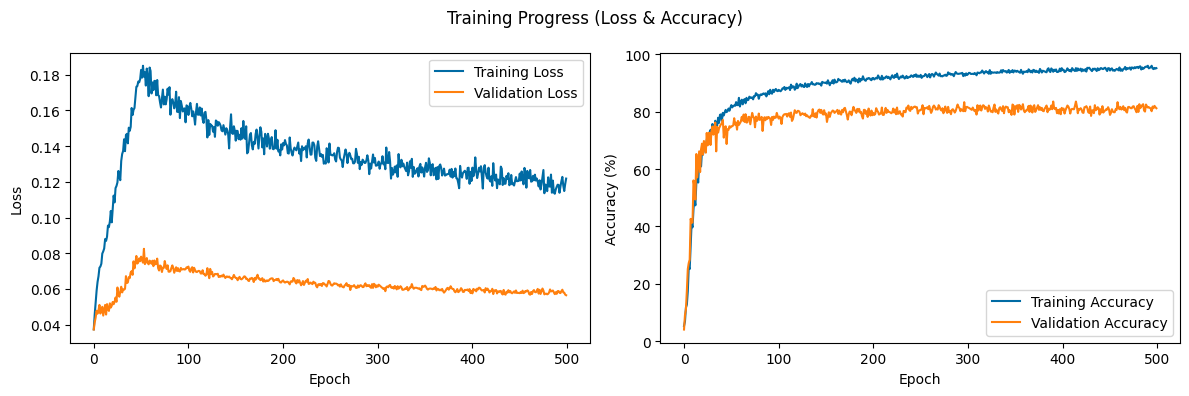

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.style.use('tableau-colorblind10')

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot([v * 100 for v in history["train_acc"]], label="Training Accuracy")
plt.plot([v * 100 for v in history["val_acc"]], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.suptitle("Training Progress (Loss & Accuracy)")
plt.tight_layout()
plt.show()

#evaluate on test datasets

In [24]:
def get_subjectwise_z_stats_from_loader(loader, encoder, device, num_sessions=6):
    """
    For each subject in the given loader, compute the mean and std of their z
    using samples from the first 4 sessions only.

    Returns:
        A dictionary: {sid: (mean, std)}, where each value has shape [1, D]
    """
    encoder.eval()
    z_by_sid = {}

    with torch.no_grad():
        for x, y, sid in loader:
            x = x.to(device)
            _, z = encoder(x)

            for i in range(z.size(0)):
                s = int(sid[i].item())
                if s not in z_by_sid:
                    z_by_sid[s] = []
                z_by_sid[s].append(z[i].unsqueeze(0))

    # Compute mean and std using only the first 104 samples (4 sessions × 26 samples/session)
    samples_per_session = 26
    z_stats = {}
    for sid in z_by_sid:
        z_all = torch.cat(z_by_sid[sid], dim=0)  # total: 156
        z_4sessions = z_all[:samples_per_session * 4]  # first 4 session (104 in total)
        mean = z_4sessions.mean(dim=0, keepdim=True)
        std = z_4sessions.std(dim=0, keepdim=True) + 1e-6
        z_stats[sid] = (mean, std)
    return z_stats

z_stats_test2 = get_subjectwise_z_stats_from_loader(test2_loader, diffe.encoder, device)

In [25]:
def evaluate_on_loader(test_loader, name="test1", z_stats=None):
    diffe.eval()
    labels = np.arange(0, 26)
    Y, Y_hat = [], []
    with torch.no_grad():
        for x, y,sid in test_loader:
            x, y = x.to(device), y.type(torch.LongTensor).to(device)
            encoder_out = diffe.encoder(x)
            z = encoder_out[1]
            z = torch.stack([
                (z[i] - z_stats[int(sid[i].item())][0].squeeze(0)) /
                z_stats[int(sid[i].item())][1].squeeze(0)
                for i in range(z.size(0))
            ])

            y_hat = diffe.fc(encoder_out[1])
            y_hat = F.softmax(y_hat, dim=1)

            Y.append(y.detach().cpu())
            Y_hat.append(y_hat.detach().cpu())

    Y = torch.cat(Y, dim=0).numpy()
    Y_hat = torch.cat(Y_hat, dim=0).numpy()

    accuracy = top_k_accuracy_score(Y, Y_hat, k=1, labels=labels)
    print(f" {name} Accuracy: {accuracy:.2%}")
    return accuracy

In [26]:
def evaluate_on_loader_test2(test_loader, name="test2", num_subjects=2, num_sessions=6):
    diffe.eval()
    labels = np.arange(0, 26)
    Y, Y_hat = [], []
    with torch.no_grad():
        all_x, all_y = [], []
        for x, y, _ in test_loader:
            all_x.append(x)
            all_y.append(y)
        all_x = torch.cat(all_x, dim=0).to(device)
        all_y = torch.cat(all_y, dim=0).to(device)

        samples_per_subject = num_sessions * 26  # Each subject has 6 sessions × 26 samples = 156
        for i in range(num_subjects):
            start = i * samples_per_subject
            end = (i + 1) * samples_per_subject
            x_sub = all_x[start:end]
            y_sub = all_y[start:end]

            encoder_out = diffe.encoder(x_sub)
            z = encoder_out[1]  # shape: [156, 256]

            # Use the first 104 samples (sessions 0–3) to compute mean and std
            z_mean = z[:104].mean(dim=0, keepdim=True)
            z_std = z[:104].std(dim=0, keepdim=True) + 1e-6

            print(f"[Check] Subject {i+1}: z_mean shape {z_mean.shape}, z_std shape {z_std.shape}")

            z = (z - z_mean) / z_std  # normalize all 156 samples

            y_hat = diffe.fc(z)
            y_hat = F.softmax(y_hat, dim=1)

            Y.append(y_sub.detach().cpu())
            Y_hat.append(y_hat.detach().cpu())

    Y = torch.cat(Y, dim=0).numpy()
    Y_hat = torch.cat(Y_hat, dim=0).numpy()
    accuracy = top_k_accuracy_score(Y, Y_hat, k=1, labels=labels)
    print(f" {name} Accuracy: {accuracy:.2%}")
    return accuracy


In [27]:
acc1 = evaluate_on_loader(test1_loader, name="Test1 (Seen Subject)", z_stats=z_stats)
acc2 = evaluate_on_loader_test2(test2_loader, name="Test2 (Unseen Subject)")

 Test1 (Seen Subject) Accuracy: 82.40%
[Check] Subject 1: z_mean shape torch.Size([1, 256]), z_std shape torch.Size([1, 256])
[Check] Subject 2: z_mean shape torch.Size([1, 256]), z_std shape torch.Size([1, 256])
 Test2 (Unseen Subject) Accuracy: 85.58%


#plot

In [28]:
#load saved data for plots
# encoder = EEGNet(nb_classes=num_classes, Chans=channels, Samples=250, dropoutRate=0.2, kernLength=64, F1=16, D=2, F2=32, dropoutType='Dropout').to(device)
# decoder = Decoder(in_channels=channels, n_feat=ddpm_dim, encoder_dim=encoder_dim).to(device)
# fc = LinearClassifier(encoder_dim, fc_dim, emb_dim=num_classes).to(device)

# diffe = DiffE(encoder, decoder, fc).to(device)

# ckpt_path = "/content/drive/MyDrive/project/model/ssvep/diffe_loss-1c-1supcon-1decoder-plus.pth"
# diffe.load_state_dict(torch.load(ckpt_path, map_location=device))

# diffe.eval()

In [29]:
def visualize_signals_grid(original, masked, ddpm_out, decoder_out, sample_idxs, dataset_name, channel=0):
    """
    Creates a grid figure showing Original / Masked / DDPM / Decoder outputs per sample
    """
    import matplotlib.pyplot as plt

    num_samples = len(sample_idxs)
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 4 * num_samples), squeeze=False)

    for i, sample_idx in enumerate(sample_idxs):
        orig_np = original[sample_idx, channel].detach().cpu().numpy()
        masked_np = masked[sample_idx, channel].detach().cpu().numpy()
        ddpm_np = ddpm_out[sample_idx, channel].detach().cpu().numpy()
        decoder_np = decoder_out[sample_idx, channel].detach().cpu().numpy()

        axes[i, 0].plot(orig_np, color='blue')
        axes[i, 0].set_title(f"{dataset_name} Sample {sample_idx} – Original")

        axes[i, 1].plot(masked_np, color='orange')
        axes[i, 1].set_title("Masked")

        axes[i, 2].plot(ddpm_np, color='green')
        axes[i, 2].set_title("DDPM Output")

        axes[i, 3].plot(decoder_np, color='red')
        axes[i, 3].set_title("Decoder Output")

        for j in range(4):
            axes[i, j].set_xlabel("Time")
            axes[i, j].set_ylabel("Amplitude")

    fig.suptitle(f"{dataset_name} EEG Signal Visualization", fontsize=18)
    fig.tight_layout()
    return fig

In [30]:
def visualize_sample_stacked(original, masked, ddpm_out, decoder_out, sample_idxs=[0], channel=0, dataset_name="Dataset"):
    import matplotlib.pyplot as plt

    for idx in sample_idxs:
        fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True)

        signals = [
            original[idx, channel].detach().cpu().numpy(),
            masked[idx, channel].detach().cpu().numpy(),
            ddpm_out[idx, channel].detach().cpu().numpy(),
            decoder_out[idx, channel].detach().cpu().numpy()
        ]
        titles = ["Original", "Masked", "DDPM Output", "Decoder Output"]
        colors = ["blue", "orange", "green", "red"]

        for i in range(4):
            axes[i].plot(signals[i], color=colors[i])
            axes[i].set_title(f"{dataset_name} Sample {idx} – {titles[i]}")
            axes[i].set_ylabel("Amplitude")

        axes[-1].set_xlabel("Time")
        fig.suptitle(f"{dataset_name} Sample {idx} – Channel {channel}", fontsize=16)
        fig.tight_layout()
        plt.show()


In [31]:
def visualize_sample_overlayed(original, masked, ddpm_out, decoder_out, sample_idxs=[0], channel=0, dataset_name="Dataset"):
    import matplotlib.pyplot as plt

    for idx in sample_idxs:
        fig, ax = plt.subplots(figsize=(15, 4))

        signals = [
            original[idx, channel].detach().cpu().numpy(),
            masked[idx, channel].detach().cpu().numpy(),
            ddpm_out[idx, channel].detach().cpu().numpy(),
            decoder_out[idx, channel].detach().cpu().numpy()
        ]
        labels = ["Original", "Masked", "DDPM Output", "Decoder Output"]
        colors = ["blue", "orange", "green", "red"]
        styles = ["solid", "dashed", "dashdot", "solid"]

        for signal, label, color, style in zip(signals, labels, colors, styles):
            ax.plot(signal, label=label, color=color, linestyle=style)

        ax.set_title(f"{dataset_name} Sample {idx} – Overlaid Signals (Channel {channel})")
        ax.set_xlabel("Time")
        ax.set_ylabel("Amplitude")
        ax.legend()
        plt.tight_layout()
        plt.show()


In [32]:
def visualize_all_datasets(loaders_dict, model_ddpm, model_diffe, device, sample_idxs=[0, 1, 2], channel=0):
    model_ddpm.eval()
    model_diffe.eval()

    for name, loader in loaders_dict.items():
        with torch.no_grad():
            for x, _,_ in loader:
                x = x.to(device)

                # Forward through DDPM
                x_hat, down, up, noise, t = model_ddpm(x)
                ddpm_out = (x_hat, down, up, t)
                x_masked = x + noise

                # Align time dimension
                min_len = min(x.shape[2], x_hat.shape[2], noise.shape[2])
                x = x[..., :min_len]
                x_hat = x_hat[..., :min_len]
                x_masked = x_masked[..., :min_len]

                # Forward through DiffE
                decoder_out, _, _ = model_diffe(x, ddpm_out)
                decoder_out = decoder_out[..., :min_len]

                # Visualize
                fig = visualize_signals_grid(x, x_masked, x_hat, decoder_out, sample_idxs, dataset_name=name, channel=channel)
                plt.show()

                visualize_sample_stacked(
                    original=x,
                    masked=x_masked,
                    ddpm_out=x_hat,
                    decoder_out=decoder_out,
                    sample_idxs=sample_idxs,
                    channel=channel,
                    dataset_name=name
                )

                visualize_sample_overlayed(
                    original=x,
                    masked=x_masked,
                    ddpm_out=x_hat,
                    decoder_out=decoder_out,
                    sample_idxs=sample_idxs,
                    channel=channel,
                    dataset_name=name
                )


                break


In [33]:
loaders = {
    "Train": train_loader,
    "Validation": val_loader,
    "Test1": test1_loader,
    "Test2": test2_loader,
}

visualize_all_datasets(loaders, ddpm, diffe, device, sample_idxs=[0, 1, 2], channel=0)

Output hidden; open in https://colab.research.google.com to view.

# t-SNE

In [34]:
#used only for tsne plot
# class EEGDataset(Dataset):
#     "Characterizes a dataset for PyTorch"

#     def __init__(self, X, Y, subject_ids=None, transform=None):
#         "Initialization"
#         self.X = X
#         self.Y = Y
#         self.subject_ids = subject_ids if subject_ids is not None else torch.zeros(len(Y), dtype=torch.long)
#         self.transform = transform

#     def __len__(self):
#         return len(self.X)

#     def __getitem__(self, index):
#         x = self.X[index]
#         y = self.Y[index]
#         sid = self.subject_ids[index]

#         if self.transform:
#             x = self.transform(x)

#         return x.squeeze(), y, sid

# def load_split_dataset(root_dir, num_seen, seed=43):
#     random.seed(seed)

#     all_subjects = list(range(1, 36))
#     seen_subjects = random.sample(all_subjects, num_seen)#25 seen
#     unseen_subjects = [sid for sid in all_subjects if sid not in seen_subjects]#10 unseen

#     split_cfg = {
#         "train":  [(sid, [0, 1, 2, 3]) for sid in seen_subjects],
#         "val":    [(sid, [4]) for sid in seen_subjects],
#         "val2":    [(sid, [4]) for sid in seen_subjects],
#         "test1":  [(sid, [5]) for sid in seen_subjects],
#         "test2":  [(sid, [0, 1, 2, 3, 4, 5]) for sid in unseen_subjects]
#     }

#     print(f"[Split] Seen subjects (train/val/test1): {seen_subjects}")
#     print(f"[Split] Unseen subjects (test2): {unseen_subjects}")

#     loaders = {}
#     subject_id_dict = {}

#     for split, sid_sess in split_cfg.items():
#         X_all, Y_all = [], []
#         subject_ids = []
#         for sid, sess in sid_sess:
#             X, Y = load_data_by_session(root_dir, sid, sess)
#             X_all.append(X)
#             Y_all.append(Y)
#             subject_ids.extend([sid] * len(Y))
#         X_all = torch.cat(X_all, dim=0)
#         Y_all = torch.cat(Y_all, dim=0)
#         dataset = EEGDataset(X_all, Y_all, subject_ids=torch.tensor(subject_ids, dtype=torch.long))
#         loaders[split] = DataLoader(dataset, batch_size=32, shuffle = (split in ["train", "val2"]))
#         subject_id_dict[split] = torch.tensor(subject_ids, dtype=torch.long)

#     # return subject_id list for t-SNE
#     for split in ["train", "val"]:
#         if split in subject_id_dict:
#             loaders[f"{split}_subjects"] = subject_id_dict[split]
#     return loaders


In [35]:
# subject_chars_dir = '/content/drive/MyDrive/project/dataset/ssvep/chars' # Where to store all character data
# subject_ids = list(range(1, 36)) #35 samples + 1

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# batch_size = 32
# batch_size2 = 260
# seed = 44 #same as the training
# shuffle = True

# # load all subjects' data
# loaders = load_split_dataset(subject_chars_dir, num_seen=33, seed=seed)
# train_loader = loaders["train"]
# val_loader = loaders["val"]
# val2_loader = loaders["val2"]
# test1_loader = loaders["test1"]
# test2_loader = loaders["test2"]
# train_iter = iter(train_loader)


In [36]:
# print(">>> First 30 subject_ids from dataloader (sid):")
# with torch.no_grad():
#     x, y, sid = next(train_iter)
#     print(sid[:30].tolist())


In [37]:
#PCA
from sklearn.decomposition import PCA

def pca_and_plot(X, color, title, color_type='label'):
    X_pca = PCA(n_components=2).fit_transform(X)
    classes = sorted(np.unique(color))
    cmap = cm.get_cmap('tab20', len(classes))
    plt.figure(figsize=(12, 9))
    for i, c in enumerate(classes):
        idx = (color == c)
        plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f"{color_type} {c}", color=cmap(i / len(classes)), s=10)
    plt.title(f"{title} (PCA by {color_type})")
    plt.legend(markerscale=2, fontsize="x-small", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    plt.tight_layout()
    plt.show()


>>> First 30 labels from train dataloader (label y):
[8, 8, 8, 7, 20, 16, 13, 14, 11, 19, 22, 18, 3, 15, 16, 5, 13, 17, 18, 3, 10, 5, 1, 25, 7, 10, 7, 6, 7, 17]
>>> First 30 labels used for t-SNE coloring (train):
[8, 8, 8, 7, 20, 16, 13, 14, 11, 19, 22, 18, 3, 15, 16, 5, 13, 17, 18, 3, 10, 5, 1, 25, 7, 10, 7, 6, 7, 17]
>>> First 30 labels from label_all_train:
[8, 8, 8, 7, 20, 16, 13, 14, 11, 19, 22, 18, 3, 15, 16, 5, 13, 17, 18, 3, 10, 5, 1, 25, 7, 10, 7, 6, 7, 17]
Running t-SNE on 3432 samples...


<ipython-input-38-87d8c75c14ac>:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_classes)


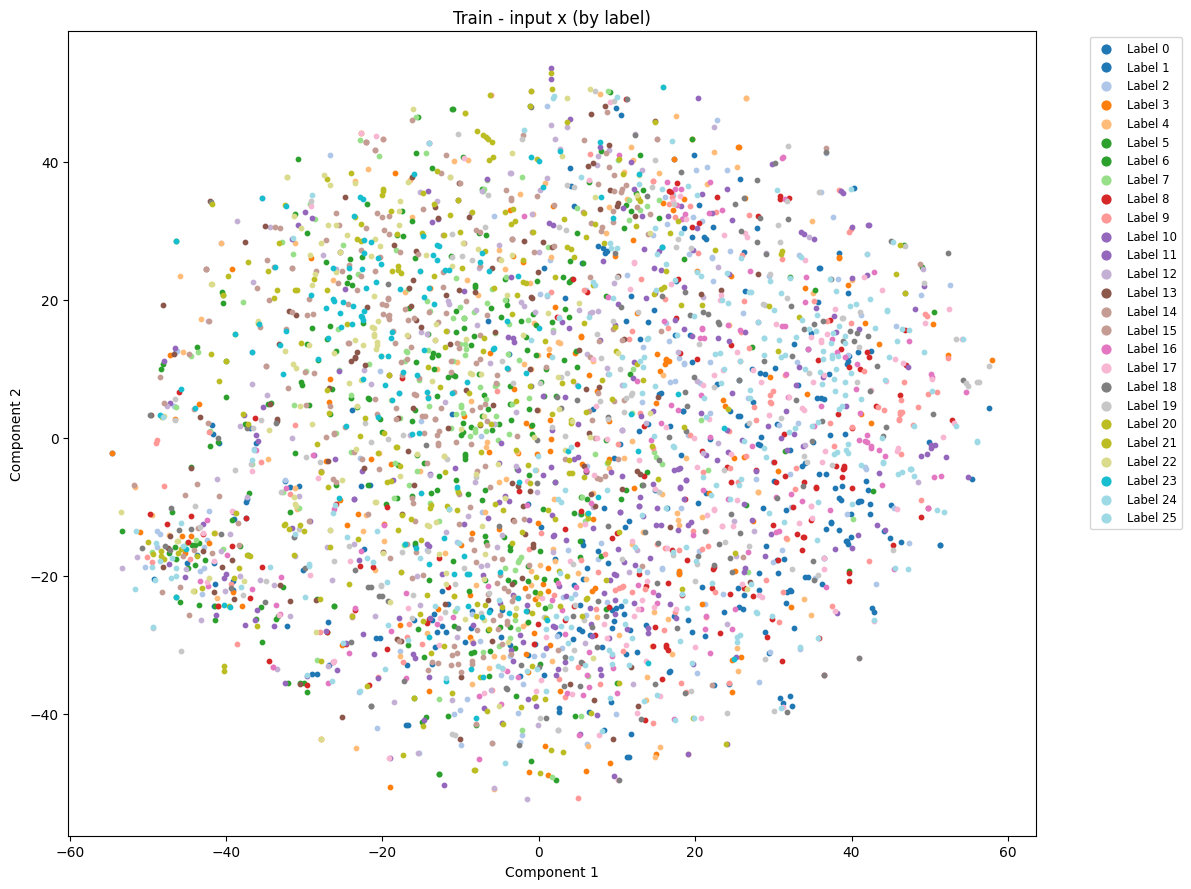

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


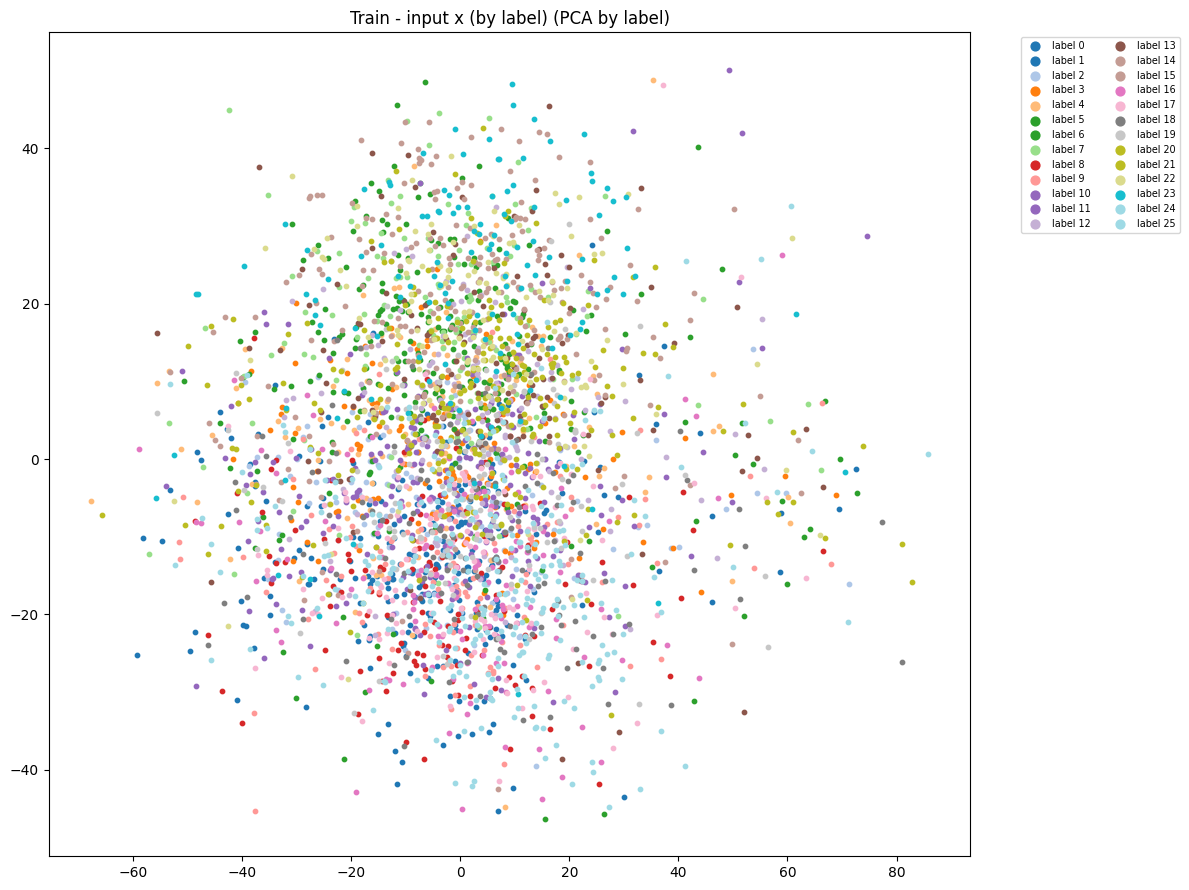

Running t-SNE on 3432 samples...


<ipython-input-38-87d8c75c14ac>:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_classes)


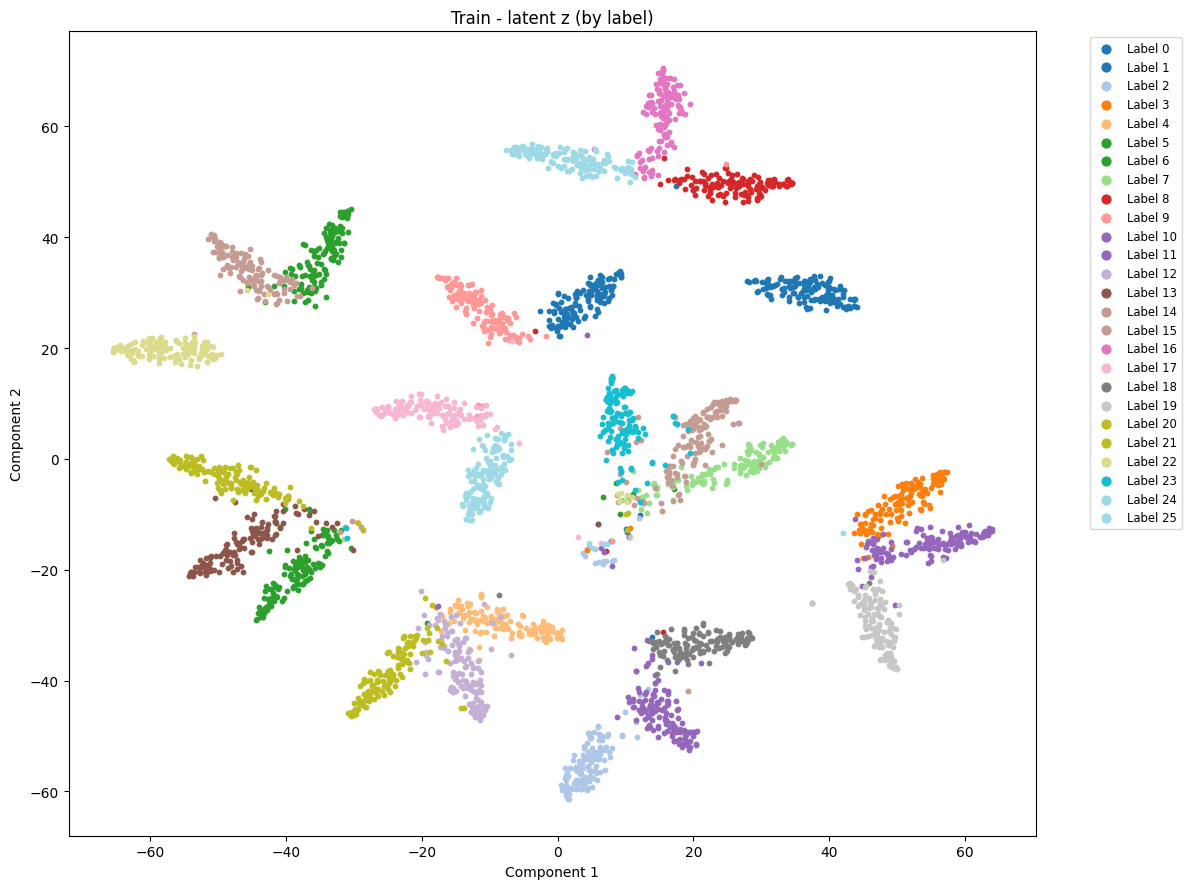

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


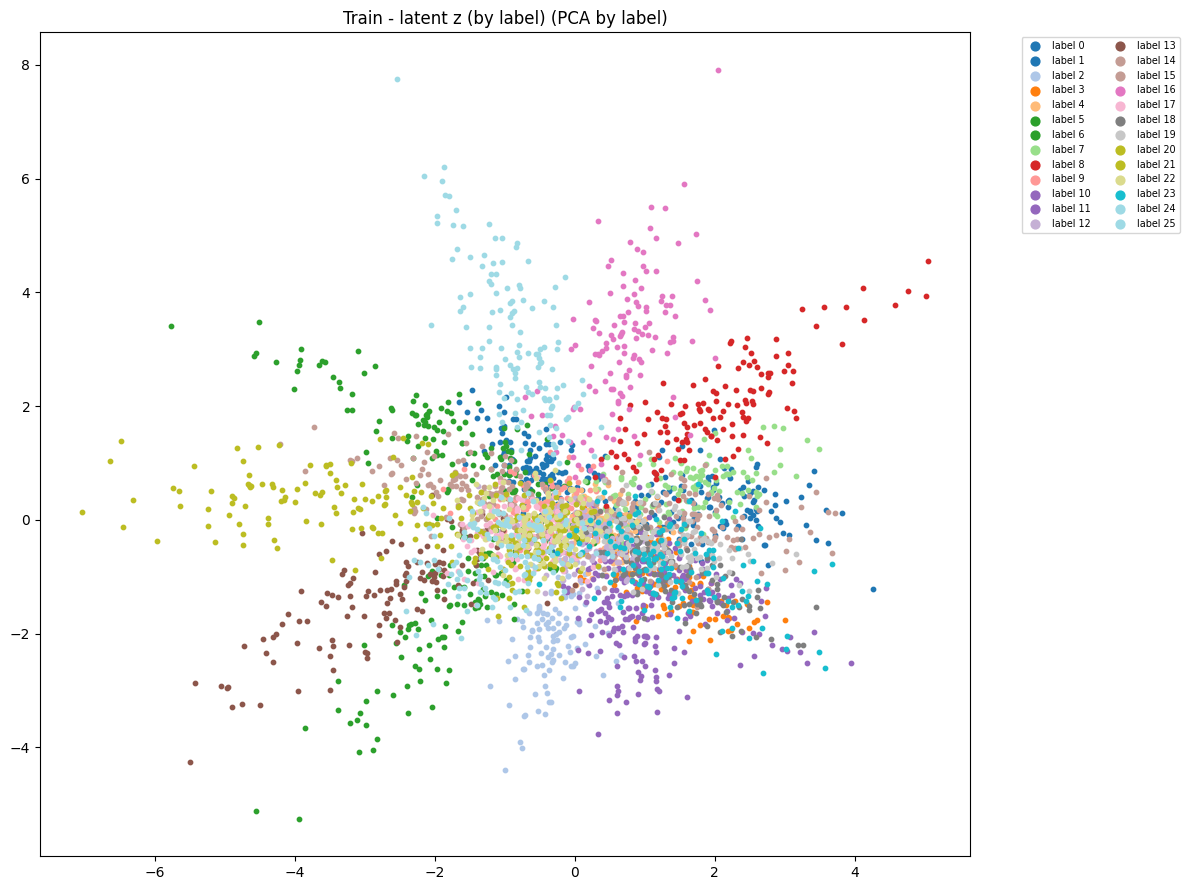

Running t-SNE on 3432 samples...


<ipython-input-38-87d8c75c14ac>:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_classes)


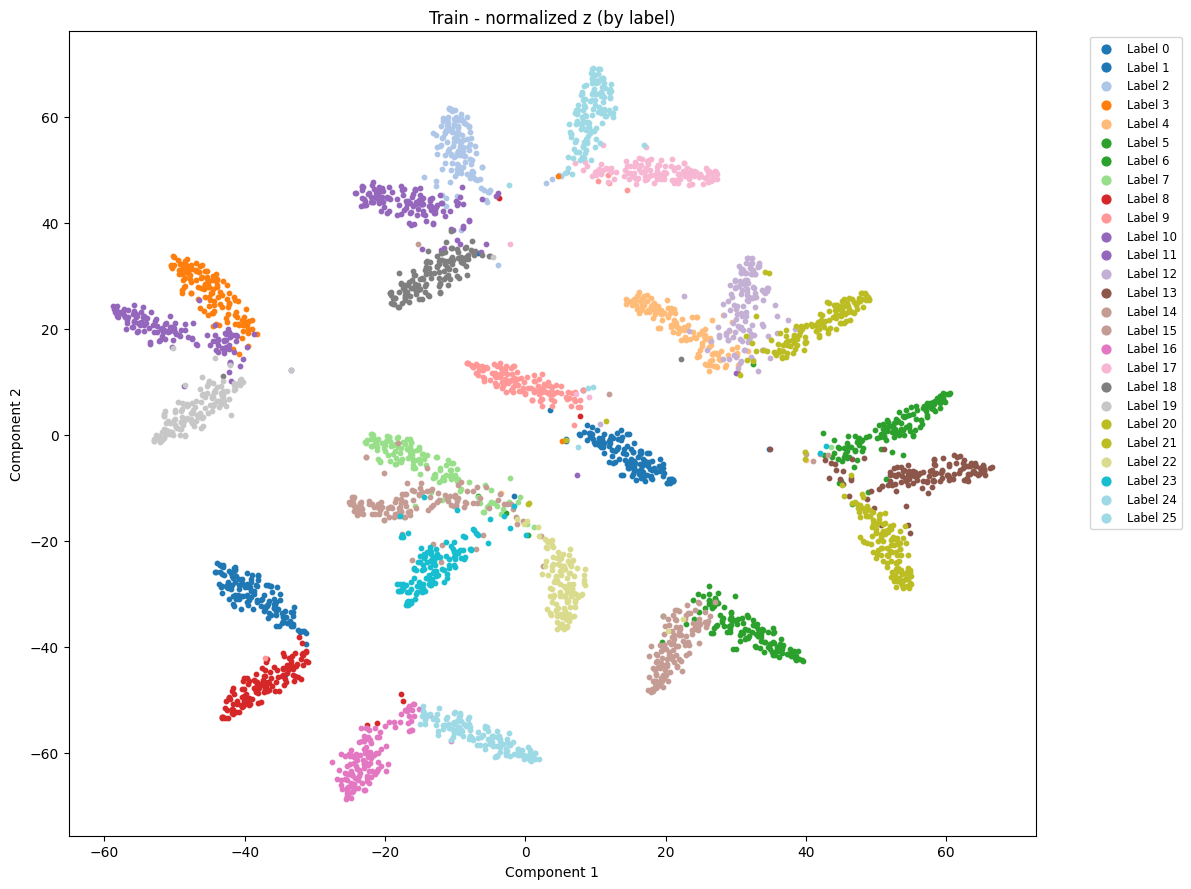

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


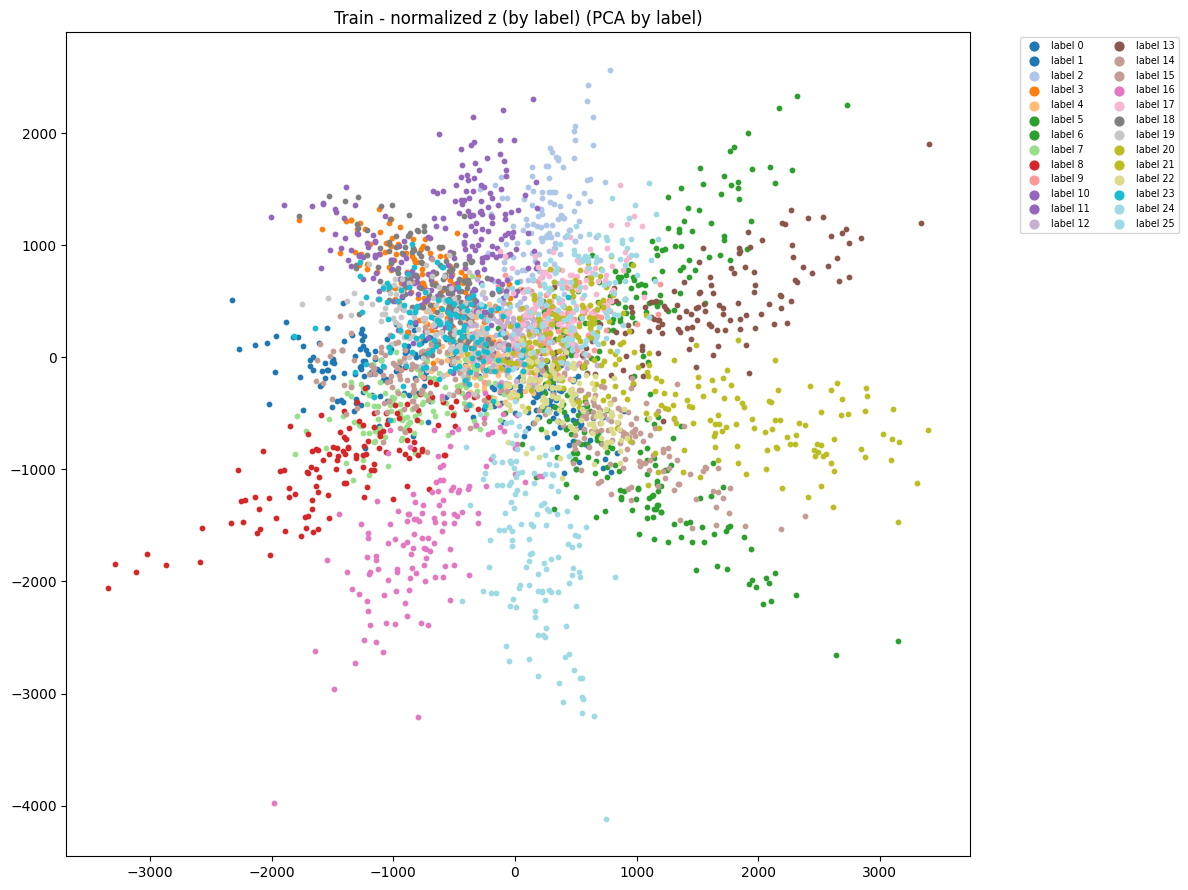

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#train by label
train_iter = iter(train_loader)

x0_train, y0_train, sid0_train = next(train_iter)
print(">>> First 30 labels from train dataloader (label y):")
print(y0_train[:30].tolist())

_, z0_train = encoder(x0_train.to(device))
z_list_train = [z0_train.detach().cpu()]
x_list_train = [x0_train.view(x0_train.size(0), -1).detach().cpu()]
label_list_train = [y0_train.cpu()]
first_30_label_train = y0_train[:30].tolist()

sid_list_train = [sid0_train.cpu()]

with torch.no_grad():
    for x, y, sid in train_iter:
        x = x.to(device)
        _, z = encoder(x)
        z_list_train.append(z.detach().cpu())
        x_list_train.append(x.view(x.size(0), -1).detach().cpu())
        label_list_train.append(y.cpu())
        sid_list_train.append(sid.cpu())

z_all_train_tensor = torch.cat(z_list_train, dim=0)
sid_all_train_tensor = torch.cat(sid_list_train, dim=0)

z_all_train_normed = torch.stack([
    (z_all_train_tensor[i] - z_stats[int(sid_all_train_tensor[i])][0].squeeze(0).cpu()) /
    z_stats[int(sid_all_train_tensor[i])][1].squeeze(0).cpu()
    for i in range(z_all_train_tensor.size(0))
])

z_all_train = torch.cat(z_list_train, dim=0).numpy()
x_all_train = torch.cat(x_list_train, dim=0).numpy()
label_all_train = torch.cat(label_list_train, dim=0).numpy()
sid_all_train = torch.cat(sid_list_train, dim=0).numpy()

print(">>> First 30 labels used for t-SNE coloring (train):")
print(first_30_label_train)
print(">>> First 30 labels from label_all_train:")
print(label_all_train[:30].tolist())

def tsne_visualize_by_label(X, labels, title="t-SNE visualization by label"):
    print(f"Running t-SNE on {len(labels)} samples...")
    X_emb = TSNE(n_components=2, perplexity=30, learning_rate=200).fit_transform(X)

    unique_labels = sorted(np.unique(labels))
    n_classes = len(unique_labels)
    cmap = cm.get_cmap('tab20', n_classes)

    plt.figure(figsize=(12, 9))
    for i, lab in enumerate(unique_labels):
        idx = (labels == lab)
        plt.scatter(X_emb[idx, 0], X_emb[idx, 1], label=f"Label {lab}", color=cmap(i / n_classes), s=10)

    plt.legend(markerscale=2, fontsize="small", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    plt.show()

tsne_visualize_by_label(x_all_train, label_all_train, title="Train - input x (by label)")
pca_and_plot(x_all_train, label_all_train, f"Train - input x (by label)", color_type='label')
tsne_visualize_by_label(z_all_train, label_all_train, title="Train - latent z (by label)")
pca_and_plot(z_all_train, label_all_train, f"Train - latent z (by label)", color_type='label')

tsne_visualize_by_label(z_all_train_normed, label_all_train, title="Train - normalized z (by label)")
pca_and_plot(z_all_train_normed, label_all_train, f"Train - normalized z (by label)", color_type='label')

# perm_train = np.random.permutation(len(label_all_train))
# tsne_visualize_by_label(z_all_train, label_all_train[perm_train], title="Train - Shuffled Label Visualization")
# pca_and_plot(z_all_train, label_all_train[perm_train], f"Train - Shuffled Label Visualization", color_type='label')


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    silhouette_score
)
results = {}

clf = LogisticRegression(max_iter=1000)
clf.fit(z_all_train, label_all_train)
acc = accuracy_score(label_all_train, clf.predict(z_all_train))
results['linear_probe_label_acc'] = acc

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(z_all_train, label_all_train)
knn_acc = accuracy_score(label_all_train, knn.predict(z_all_train))
results['knn_label_acc'] = knn_acc

kmeans_label = KMeans(n_clusters=len(np.unique(label_all_train)), random_state=0).fit(z_all_train)
ari_label = adjusted_rand_score(label_all_train, kmeans_label.labels_)
nmi_label = normalized_mutual_info_score(label_all_train, kmeans_label.labels_)
results['ARI_label'] = ari_label
results['NMI_label'] = nmi_label

sil = silhouette_score(z_all_train, label_all_train)
results['silhouette_z'] = sil

for k, v in results.items():
    print(f"{k}: {v:.4f}")


linear_probe_label_acc: 0.9636
knn_label_acc: 0.9545
ARI_label: 0.5177
NMI_label: 0.7776
silhouette_z: 0.2187


>>> First 30 labels from val dataloader (label y):
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 0, 1, 2, 3]
>>> First 30 labels used for t-SNE coloring (val):
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 0, 1, 2, 3]
>>> First 30 labels from label_all_val:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 0, 1, 2, 3]
Running t-SNE on 858 samples...


<ipython-input-38-87d8c75c14ac>:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_classes)


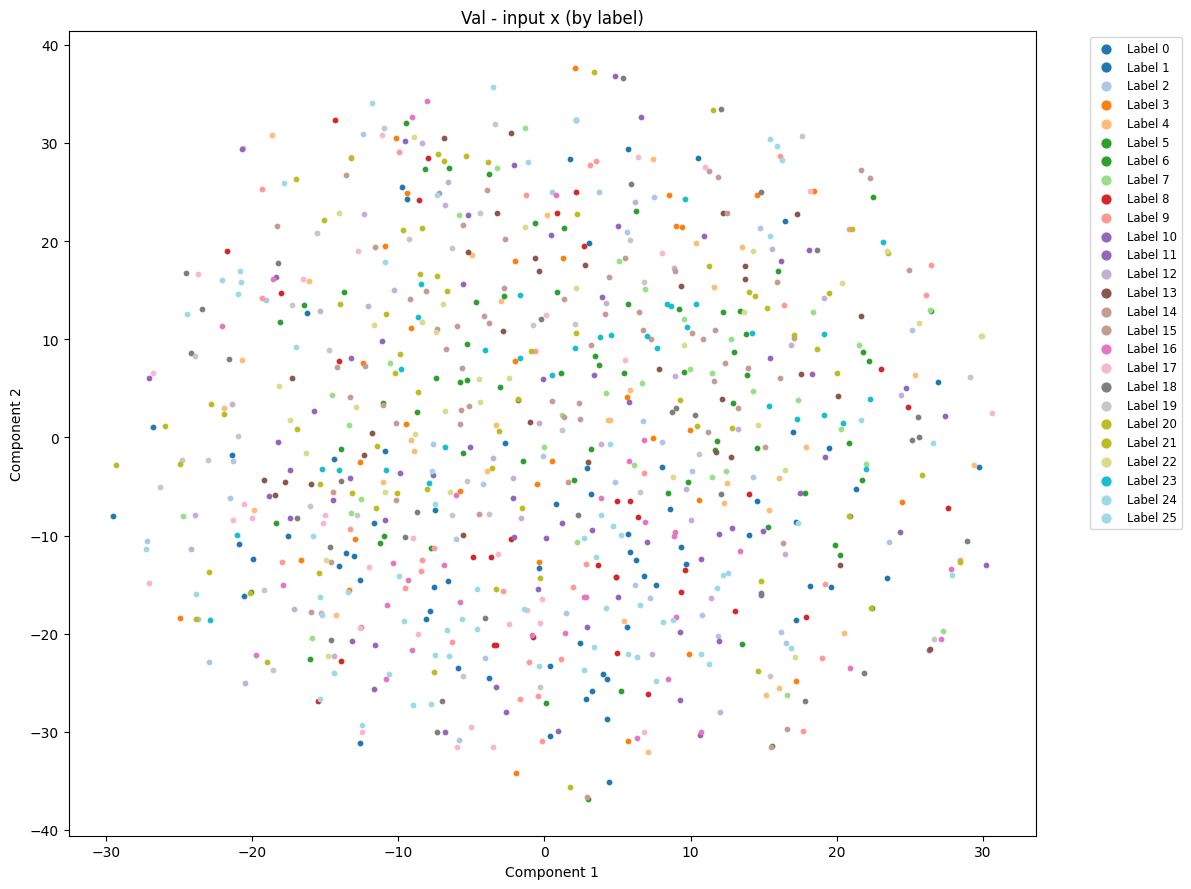

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


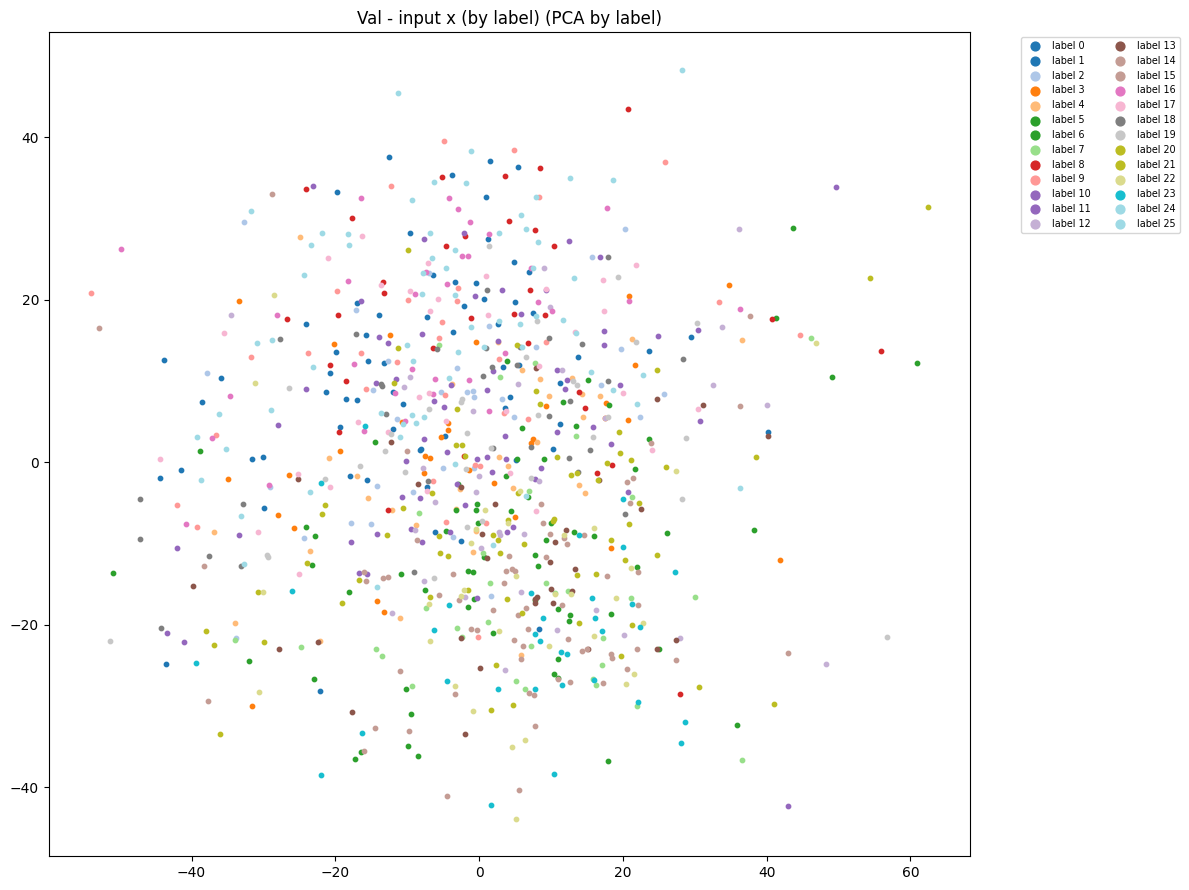

Running t-SNE on 858 samples...


<ipython-input-38-87d8c75c14ac>:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_classes)


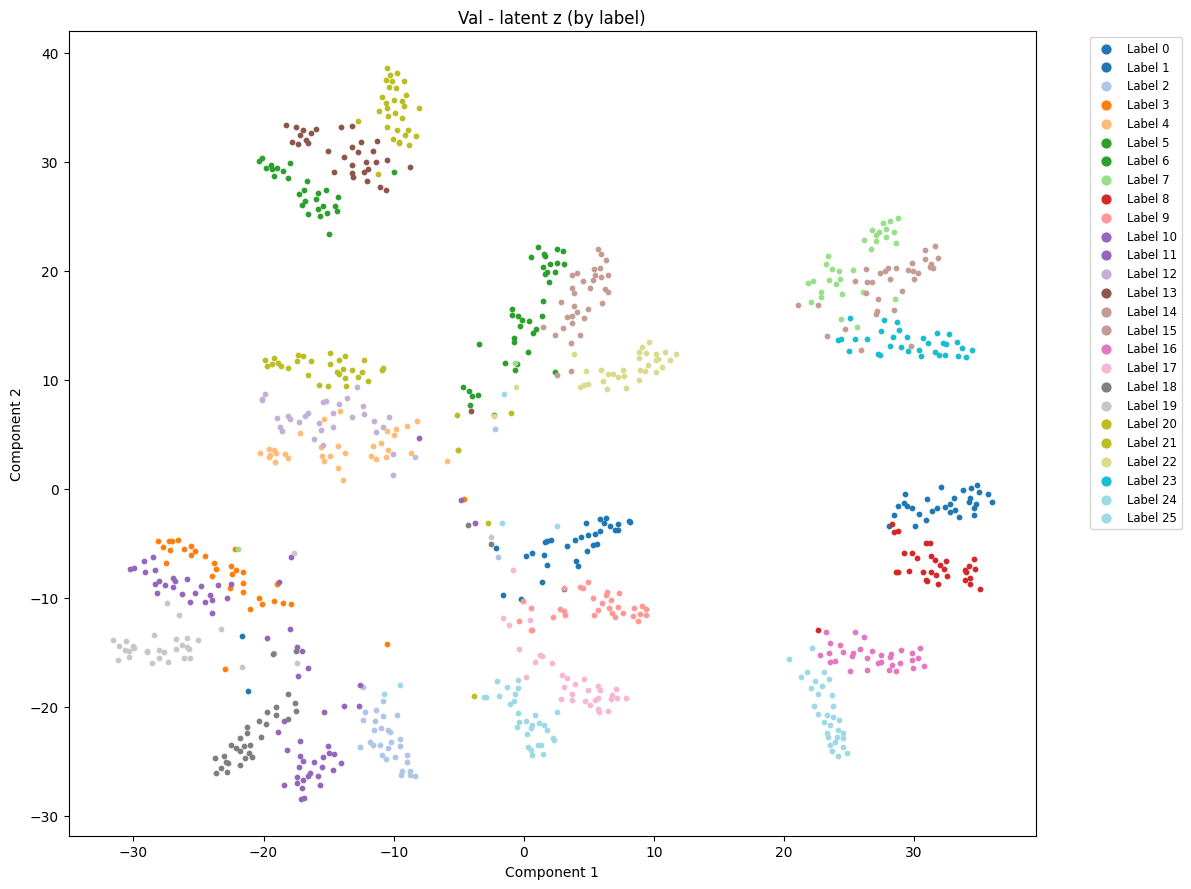

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


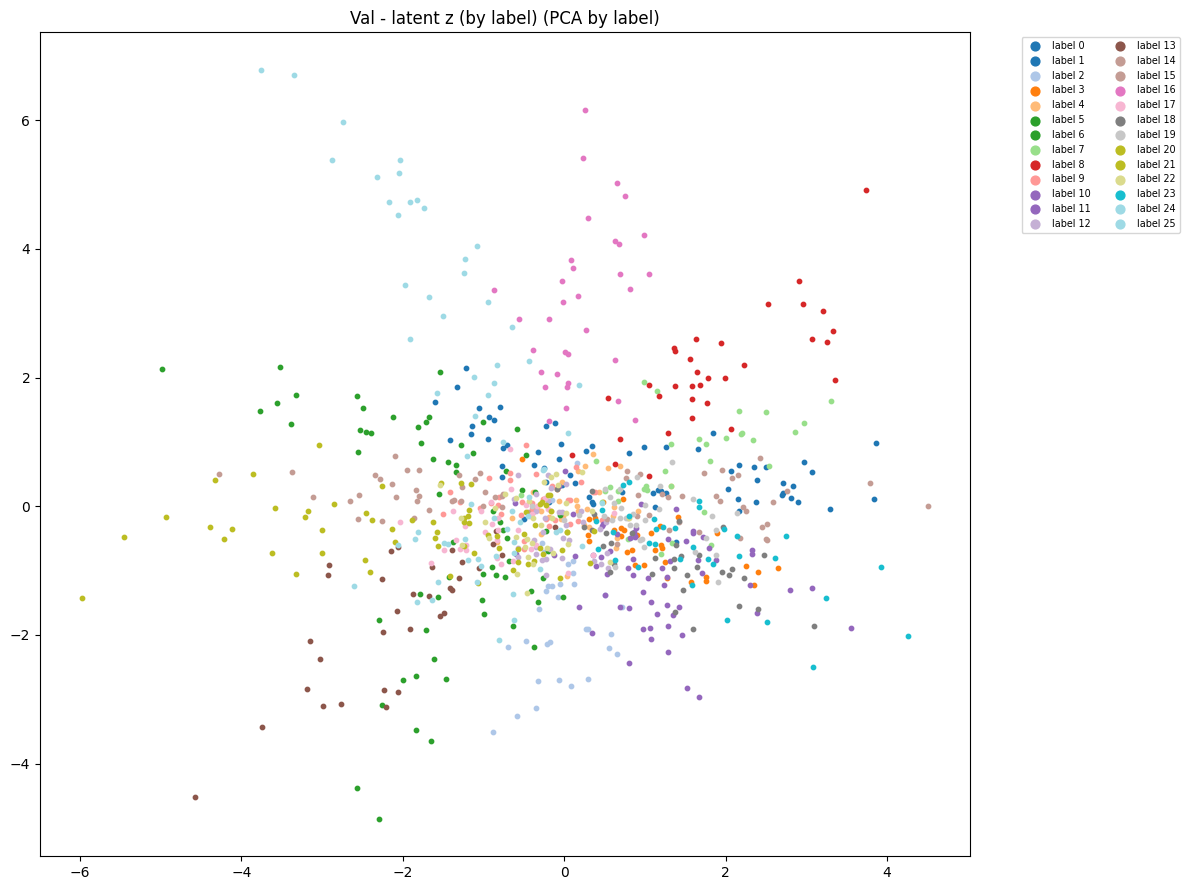

Running t-SNE on 858 samples...


<ipython-input-38-87d8c75c14ac>:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_classes)


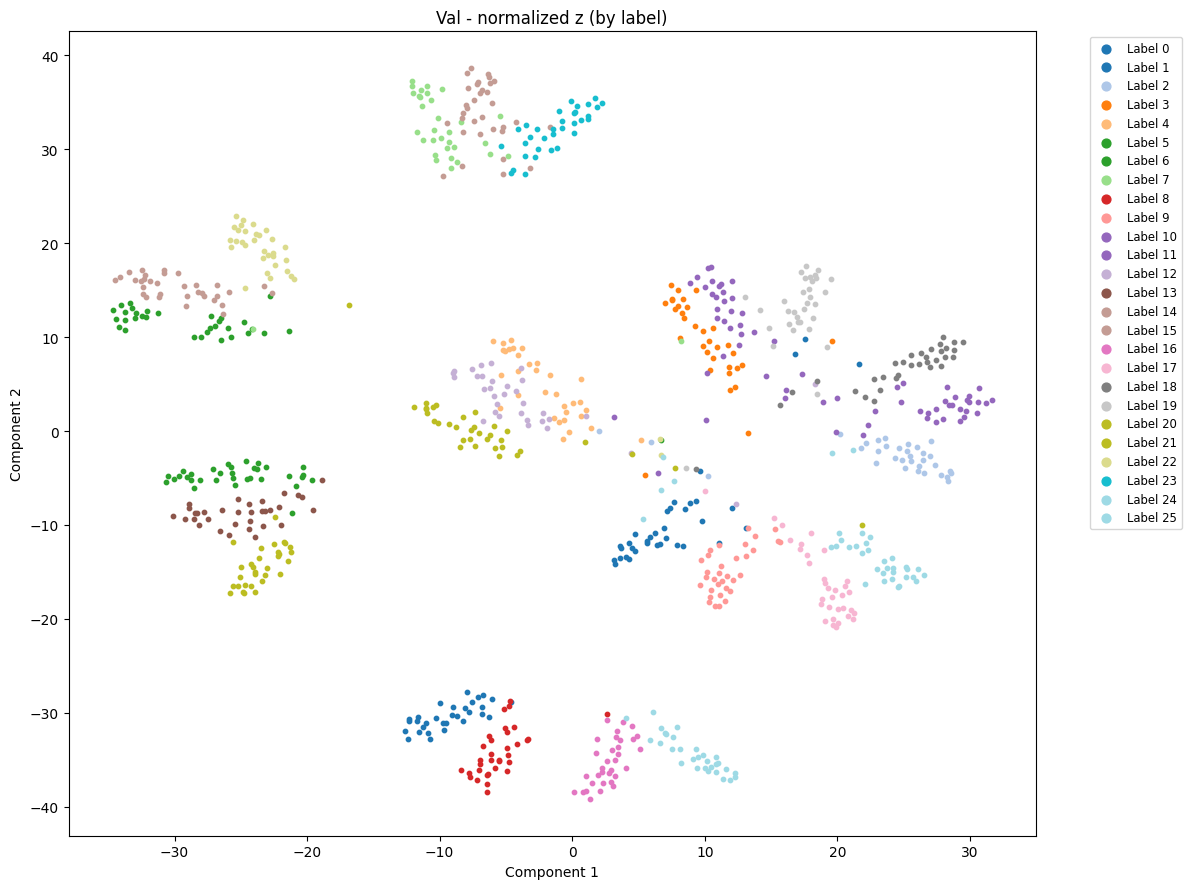

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


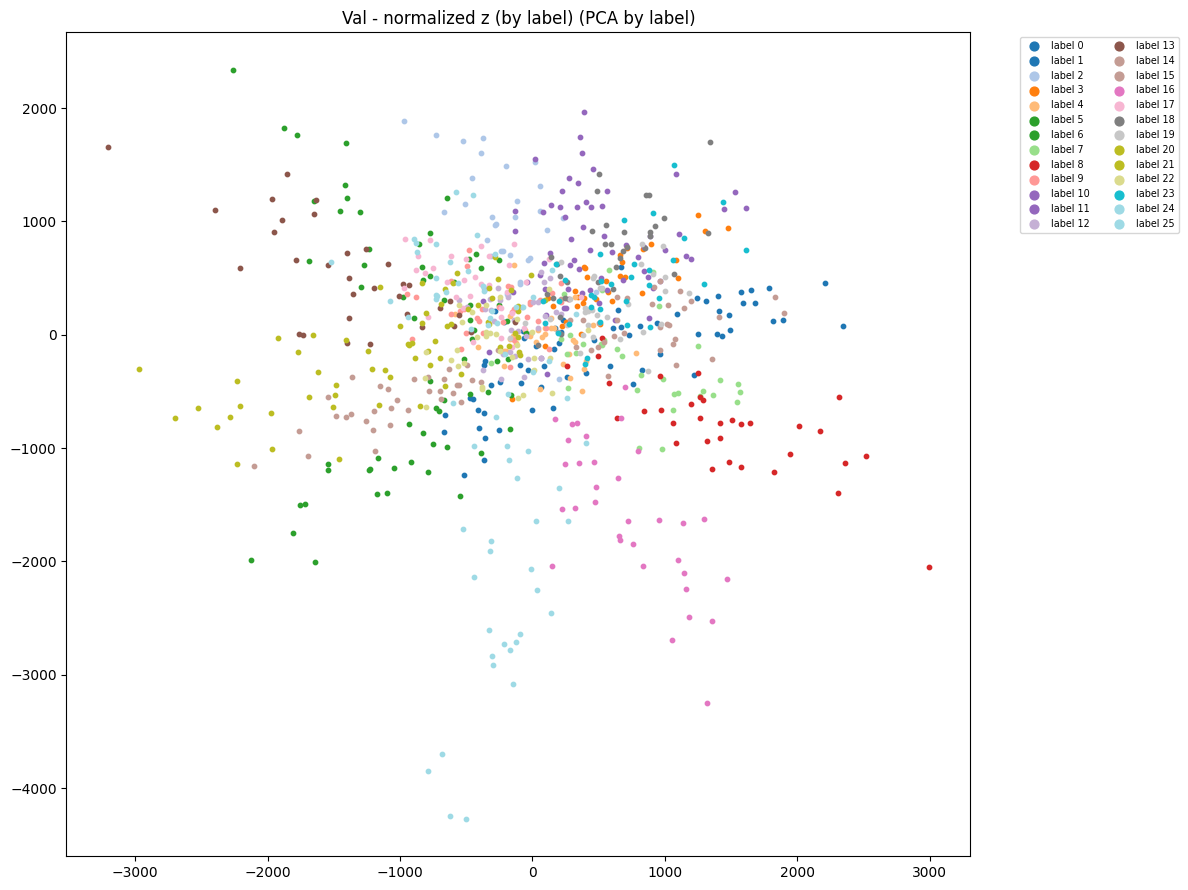

In [40]:
#val by label (shuffle=F)
val_iter = iter(val_loader)

x0_val, y0_val, sid0_val = next(val_iter)
print(">>> First 30 labels from val dataloader (label y):")
print(y0_val[:30].tolist())

_, z0_val = encoder(x0_val.to(device))
z_list_val = [z0_val.detach().cpu()]
x_list_val = [x0_val.view(x0_val.size(0), -1).detach().cpu()]
label_list_val = [y0_val.cpu()]
first_30_label_val = y0_val[:30].tolist()

sid_list_val = [sid0_val.cpu()]

with torch.no_grad():
    for x, y, sid in val_iter:
        x = x.to(device)
        _, z = encoder(x)
        z_list_val.append(z.detach().cpu())
        x_list_val.append(x.view(x.size(0), -1).detach().cpu())
        label_list_val.append(y.cpu())
        sid_list_val.append(sid.cpu())

z_all_val_tensor = torch.cat(z_list_val, dim=0)
sid_all_val_tensor = torch.cat(sid_list_val, dim=0)

z_all_val_normed = torch.stack([
    (z_all_val_tensor[i] - z_stats[int(sid_all_val_tensor[i])][0].squeeze(0).cpu()) /
    z_stats[int(sid_all_val_tensor[i])][1].squeeze(0).cpu()
    for i in range(z_all_val_tensor.size(0))
])

z_all_val = torch.cat(z_list_val, dim=0).numpy()
x_all_val = torch.cat(x_list_val, dim=0).numpy()
label_all_val = torch.cat(label_list_val, dim=0).numpy()
sid_all_val = torch.cat(sid_list_val, dim=0).numpy()  #

print(">>> First 30 labels used for t-SNE coloring (val):")
print(first_30_label_val)
print(">>> First 30 labels from label_all_val:")
print(label_all_val[:30].tolist())

tsne_visualize_by_label(x_all_val, label_all_val, title="Val - input x (by label)")
pca_and_plot(x_all_val, label_all_val, f"Val - input x (by label)", color_type='label')

tsne_visualize_by_label(z_all_val, label_all_val, title="Val - latent z (by label)")
pca_and_plot(z_all_val, label_all_val, f"Val - latent z (by label)", color_type='label')

tsne_visualize_by_label(z_all_val_normed, label_all_val, title="Val - normalized z (by label)")
pca_and_plot(z_all_val_normed, label_all_val, f"Val - normalized z (by label)", color_type='label')


In [41]:
results = {}

clf = LogisticRegression(max_iter=1000)
clf.fit(z_all_val, label_all_val)
acc = accuracy_score(label_all_val, clf.predict(z_all_val))
results['linear_probe_label_acc'] = acc

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(z_all_val, label_all_val)
knn_acc = accuracy_score(label_all_val, knn.predict(z_all_val))
results['knn_label_acc'] = knn_acc

kmeans_label = KMeans(n_clusters=len(np.unique(label_all_val)), random_state=0).fit(z_all_val)
ari_label = adjusted_rand_score(label_all_val, kmeans_label.labels_)
nmi_label = normalized_mutual_info_score(label_all_val, kmeans_label.labels_)
results['ARI_label'] = ari_label
results['NMI_label'] = nmi_label

sil = silhouette_score(z_all_val, label_all_val)
results['silhouette_z'] = sil

for k, v in results.items():
    print(f"{k}: {v:.4f}")


linear_probe_label_acc: 0.9324
knn_label_acc: 0.9114
ARI_label: 0.4351
NMI_label: 0.7412
silhouette_z: 0.1680


>>> First 30 labels from val dataloader (label y):
[3, 9, 21, 15, 4, 23, 3, 14, 17, 2, 21, 8, 4, 7, 23, 25, 17, 14, 15, 4, 15, 21, 13, 2, 19, 5, 22, 16, 22, 4]
>>> First 30 labels used for t-SNE coloring (val):
[3, 9, 21, 15, 4, 23, 3, 14, 17, 2, 21, 8, 4, 7, 23, 25, 17, 14, 15, 4, 15, 21, 13, 2, 19, 5, 22, 16, 22, 4]
>>> First 30 labels from label_all_val:
[3, 9, 21, 15, 4, 23, 3, 14, 17, 2, 21, 8, 4, 7, 23, 25, 17, 14, 15, 4, 15, 21, 13, 2, 19, 5, 22, 16, 22, 4]
Running t-SNE on 858 samples...


<ipython-input-38-87d8c75c14ac>:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_classes)


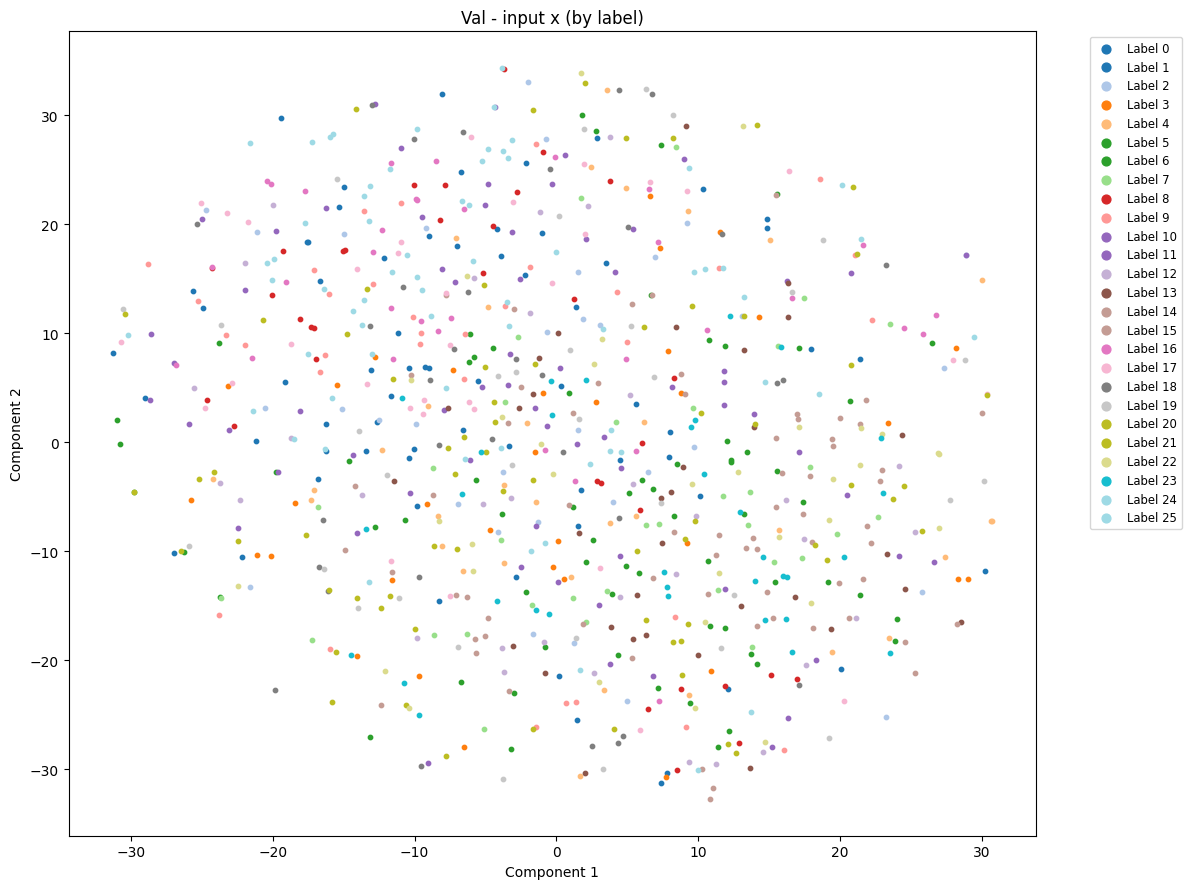

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


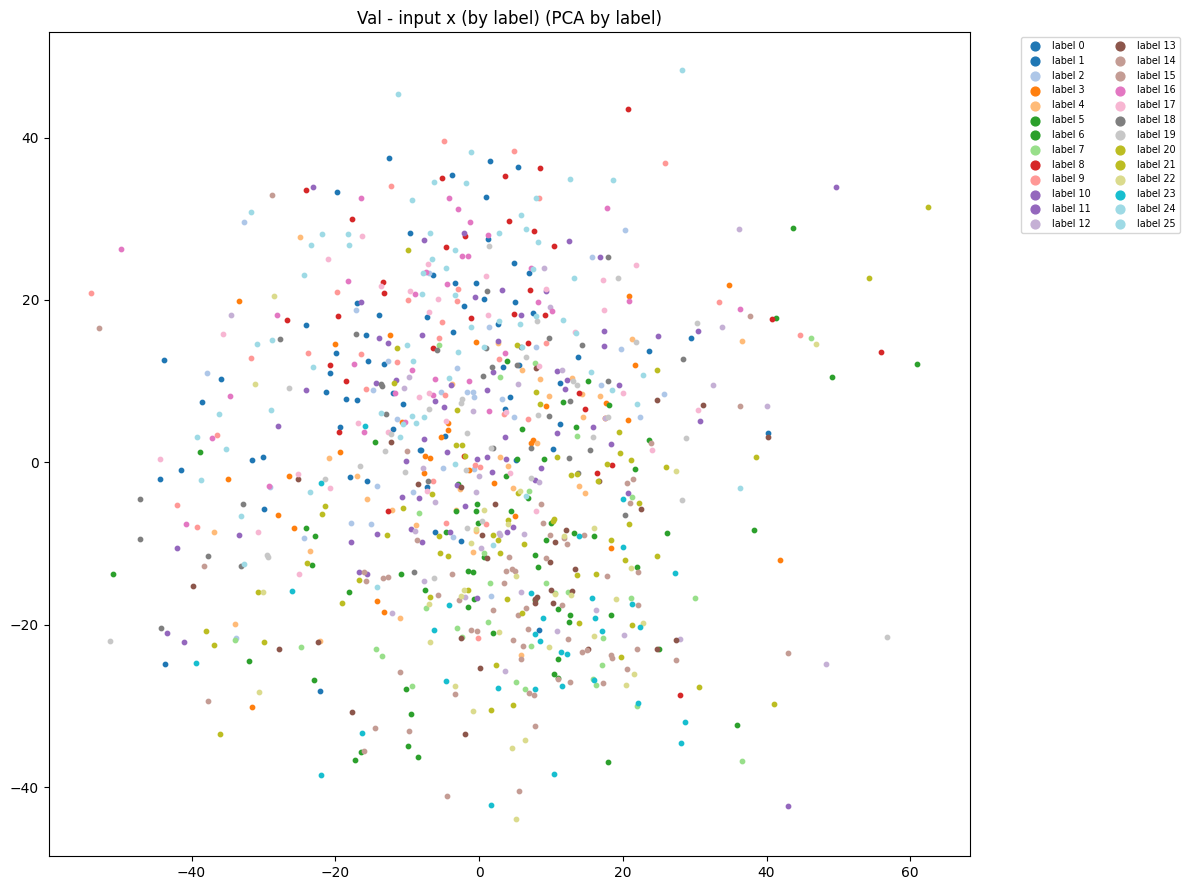

Running t-SNE on 858 samples...


<ipython-input-38-87d8c75c14ac>:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_classes)


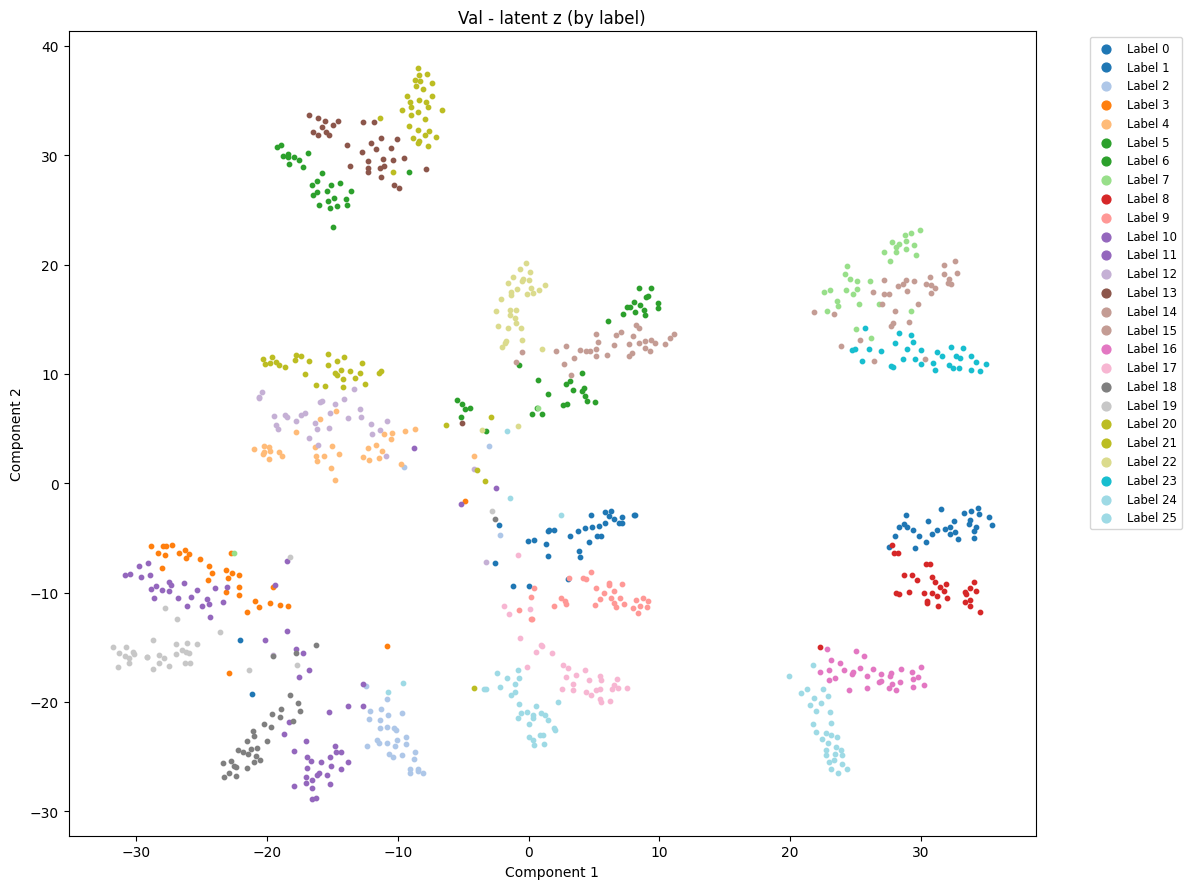

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


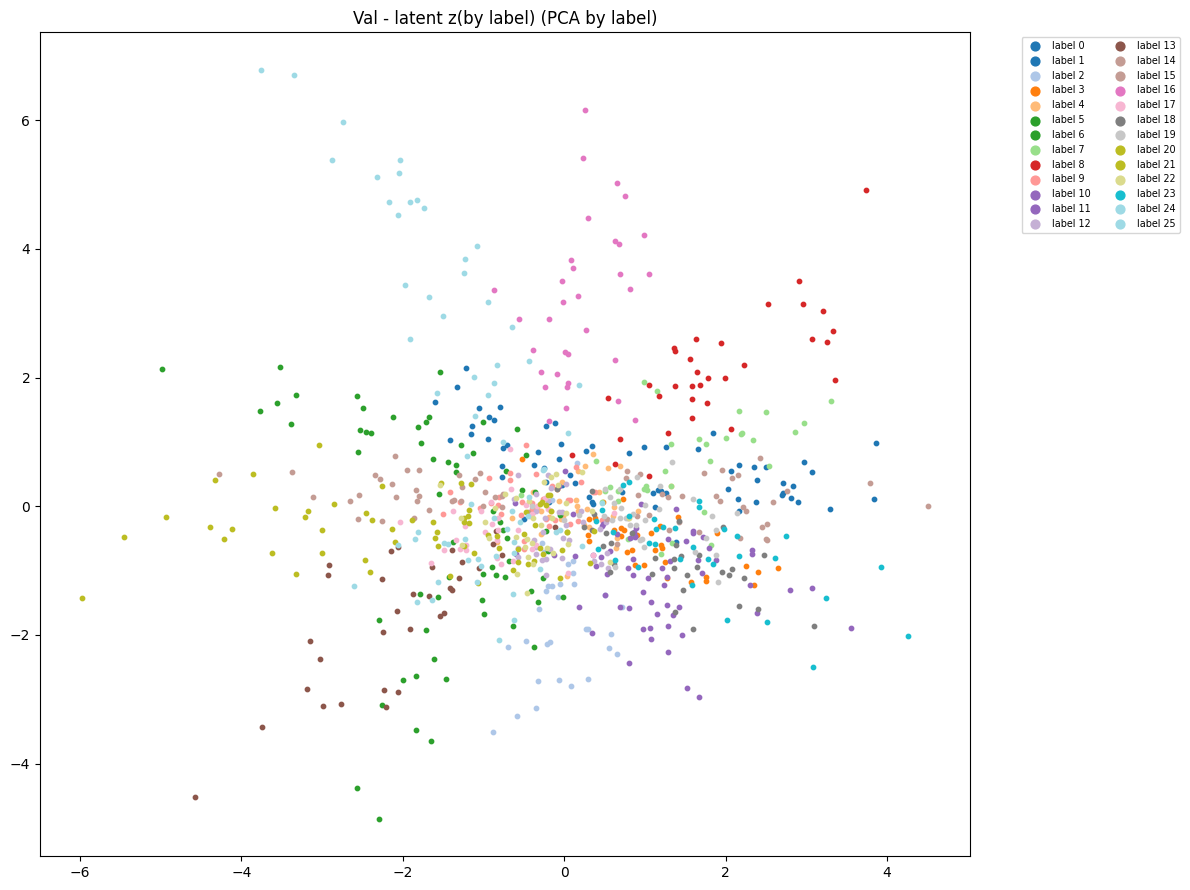

In [42]:
#val2 by label (shuffle=T)
val_iter = iter(val2_loader)

x0_val, y0_val, sid0_val = next(val_iter)
print(">>> First 30 labels from val dataloader (label y):")
print(y0_val[:30].tolist())

_, z0_val = encoder(x0_val.to(device))
z_list_val = [z0_val.detach().cpu()]
x_list_val = [x0_val.view(x0_val.size(0), -1).detach().cpu()]
label_list_val = [y0_val.cpu()]
first_30_label_val = y0_val[:30].tolist()

sid_list_val = [sid0_val.cpu()]

with torch.no_grad():
    for x, y, sid in val_iter:
        x = x.to(device)
        _, z = encoder(x)
        z_list_val.append(z.detach().cpu())
        x_list_val.append(x.view(x.size(0), -1).detach().cpu())
        label_list_val.append(y.cpu())
        sid_list_val.append(sid.cpu())

z_all_val = torch.cat(z_list_val, dim=0).numpy()
x_all_val = torch.cat(x_list_val, dim=0).numpy()
label_all_val = torch.cat(label_list_val, dim=0).numpy()
sid_all_val = torch.cat(sid_list_val, dim=0).numpy()  #

print(">>> First 30 labels used for t-SNE coloring (val):")
print(first_30_label_val)
print(">>> First 30 labels from label_all_val:")
print(label_all_val[:30].tolist())

tsne_visualize_by_label(x_all_val, label_all_val, title="Val - input x (by label)")
pca_and_plot(x_all_val, label_all_val, f"Val - input x (by label)", color_type='label')

tsne_visualize_by_label(z_all_val, label_all_val, title="Val - latent z (by label)")
pca_and_plot(z_all_val, label_all_val, f"Val - latent z(by label)", color_type='label')

In [43]:
results = {}

clf = LogisticRegression(max_iter=1000)
clf.fit(z_all_val, label_all_val)
acc = accuracy_score(label_all_val, clf.predict(z_all_val))
results['linear_probe_label_acc'] = acc

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(z_all_val, label_all_val)
knn_acc = accuracy_score(label_all_val, knn.predict(z_all_val))
results['knn_label_acc'] = knn_acc

kmeans_label = KMeans(n_clusters=len(np.unique(label_all_val)), random_state=0).fit(z_all_val)
ari_label = adjusted_rand_score(label_all_val, kmeans_label.labels_)
nmi_label = normalized_mutual_info_score(label_all_val, kmeans_label.labels_)
results['ARI_label'] = ari_label
results['NMI_label'] = nmi_label

sil = silhouette_score(z_all_val, label_all_val)
results['silhouette_z'] = sil

for k, v in results.items():
    print(f"{k}: {v:.4f}")


linear_probe_label_acc: 0.9324
knn_label_acc: 0.9114
ARI_label: 0.4340
NMI_label: 0.7421
silhouette_z: 0.1680


In [44]:
def tsne_visualize_latentz_by_subject(X, subject_ids, title="t-SNE of latent z (colored by subject)"):
    print(f"Running t-SNE on {len(subject_ids)} samples...")
    X_emb = TSNE(n_components=2, perplexity=30, learning_rate=200).fit_transform(X)

    unique_subjects = sorted(np.unique(subject_ids))
    n_subjects = len(unique_subjects)
    colormap = cm.get_cmap('tab20', n_subjects)

    plt.figure(figsize=(12, 9))
    for i, sid in enumerate(unique_subjects):
        idx = (subject_ids == sid)
        plt.scatter(X_emb[idx, 0], X_emb[idx, 1], label=f"Subject {sid}", color=colormap(i / n_subjects), s=10)

    plt.legend(markerscale=2, fontsize="x-small", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    plt.show()


>>> First 30 subject_ids from dataloader (sid):
[4, 28, 2, 4, 20, 19, 10, 26, 1, 5, 10, 29, 27, 3, 3, 2, 27, 3, 1, 11, 11, 24, 27, 13, 10, 15, 20, 19, 15, 12]
>>> First 30 subject_ids used for t-SNE coloring:
[4, 28, 2, 4, 20, 19, 10, 26, 1, 5, 10, 29, 27, 3, 3, 2, 27, 3, 1, 11, 11, 24, 27, 13, 10, 15, 20, 19, 15, 12]
ARI score: -0.003844303723399809
Running t-SNE on 3432 samples...


<ipython-input-44-3c2b76cb6440>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', n_subjects)


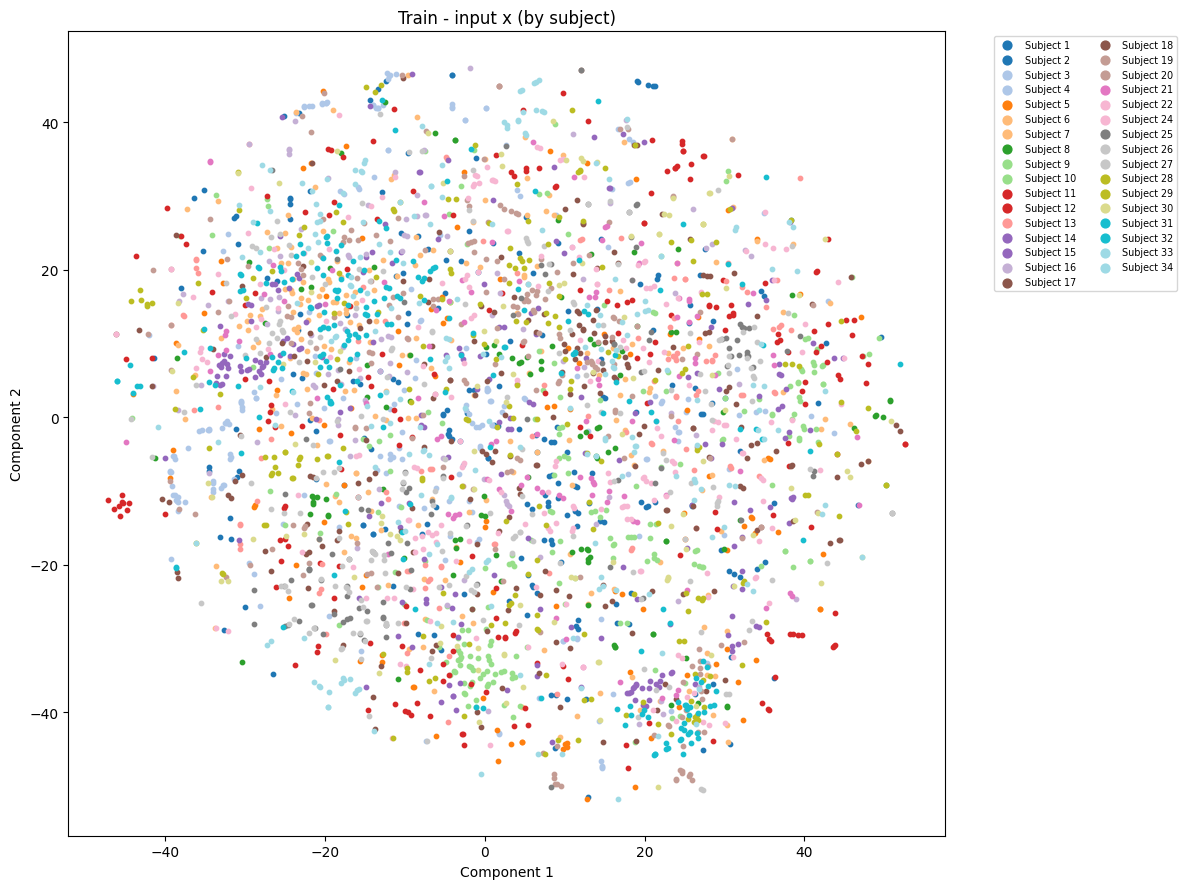

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


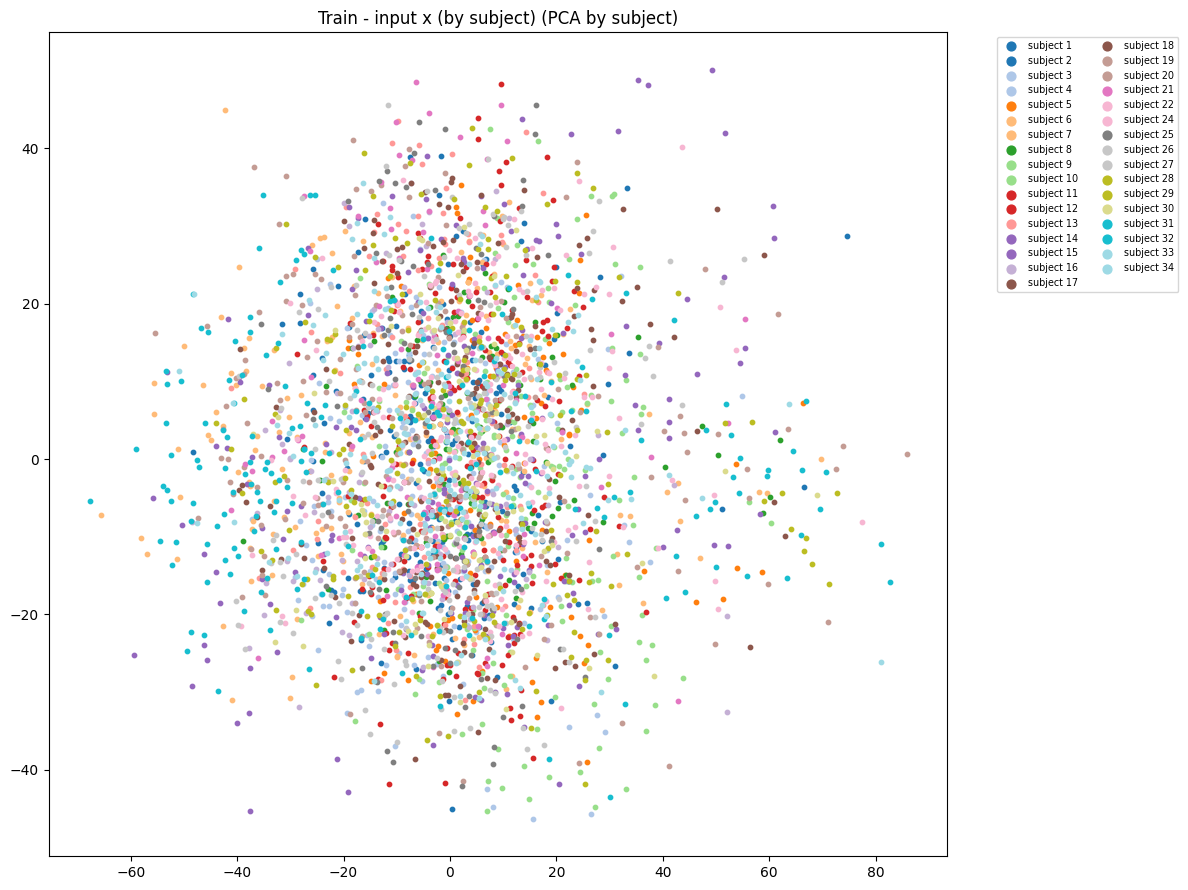

Running t-SNE on 3432 samples...


<ipython-input-44-3c2b76cb6440>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', n_subjects)


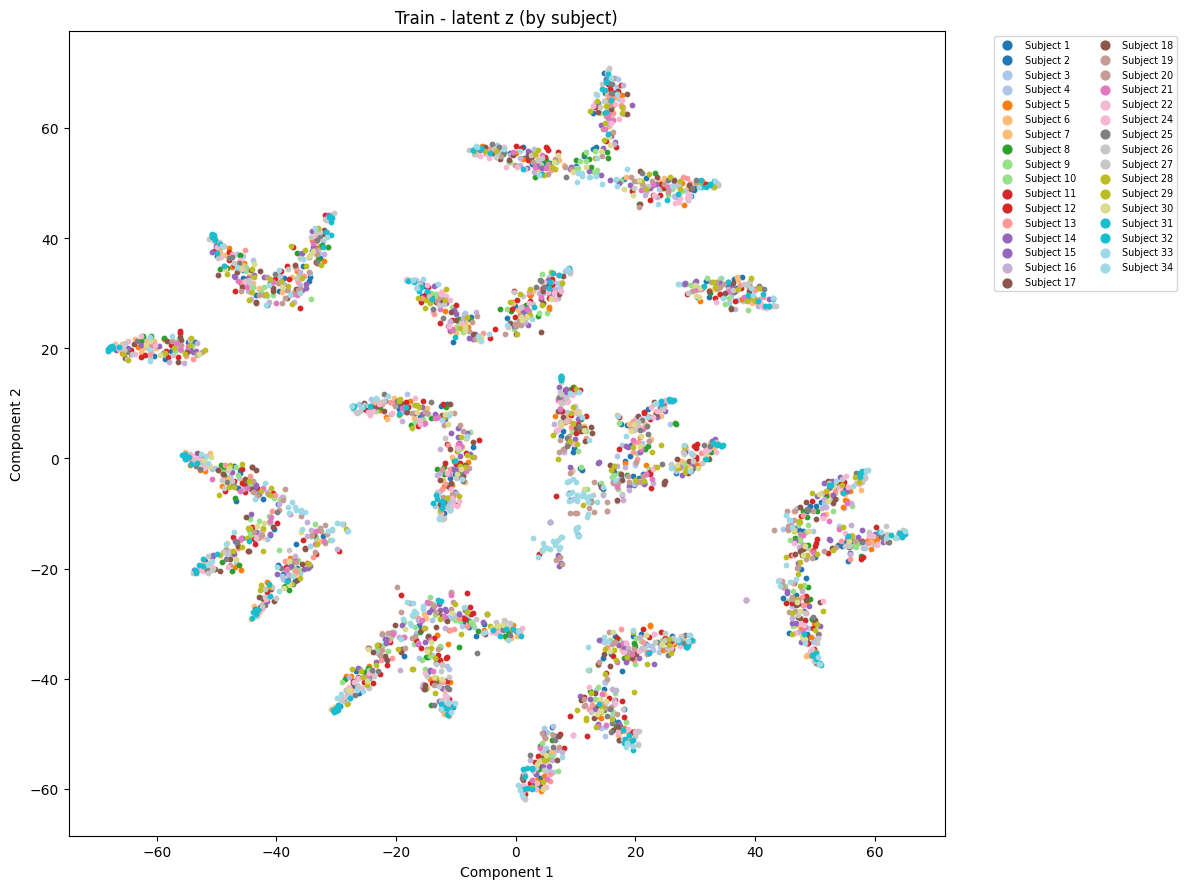

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


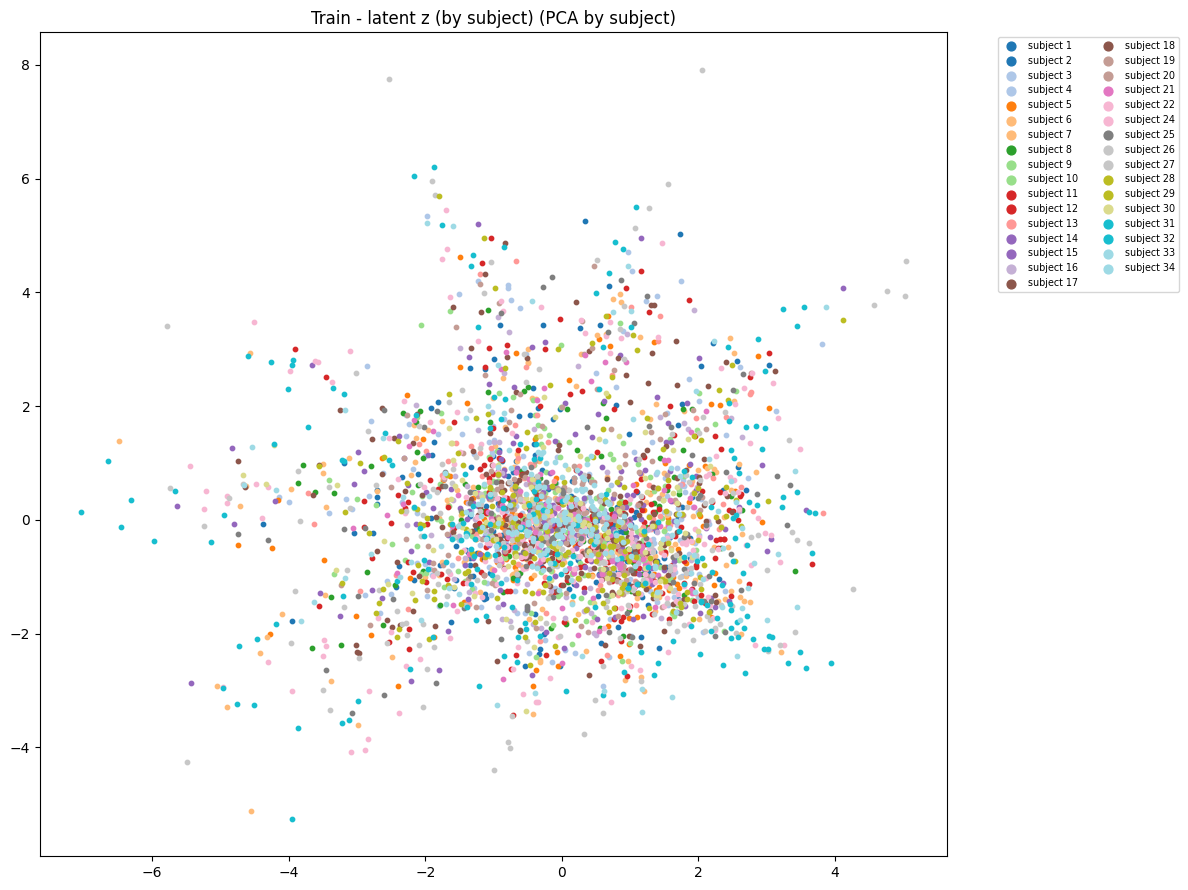

Running t-SNE on 3432 samples...


<ipython-input-44-3c2b76cb6440>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', n_subjects)


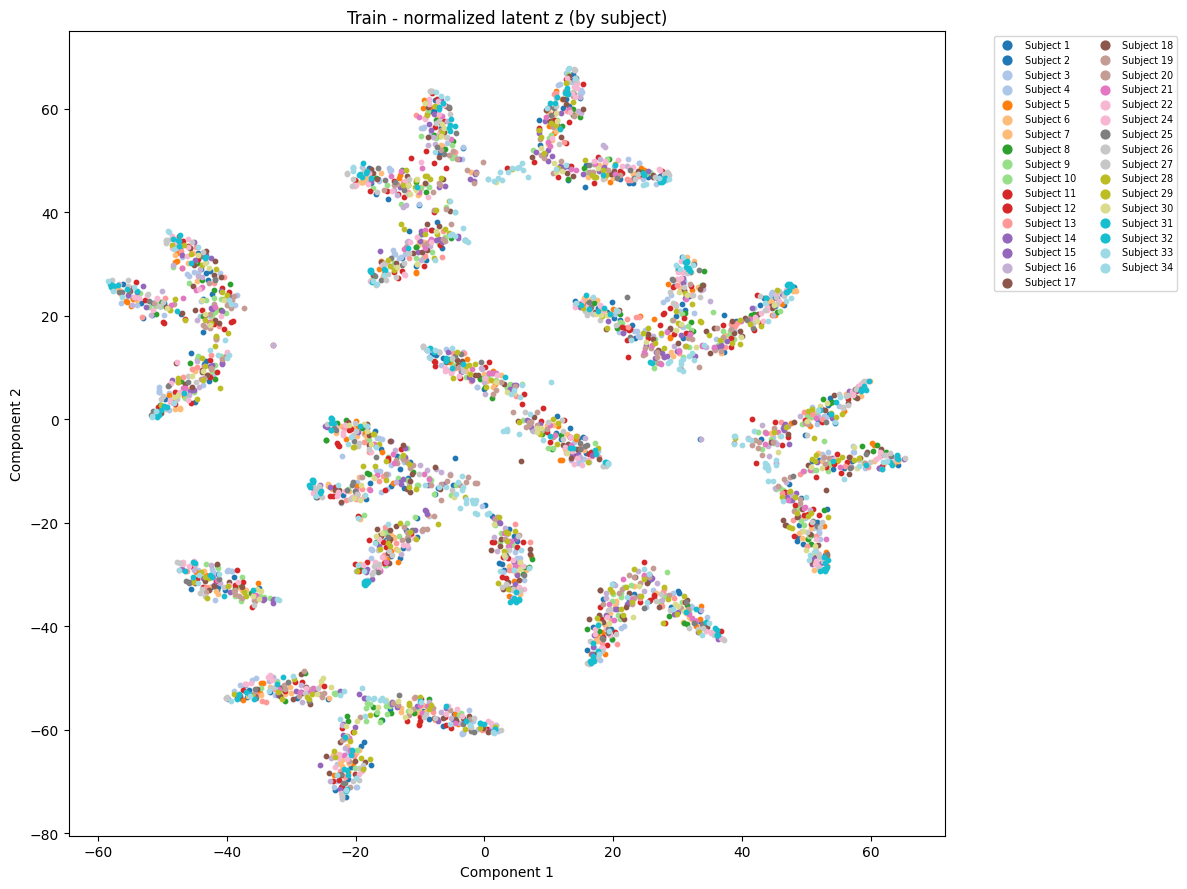

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


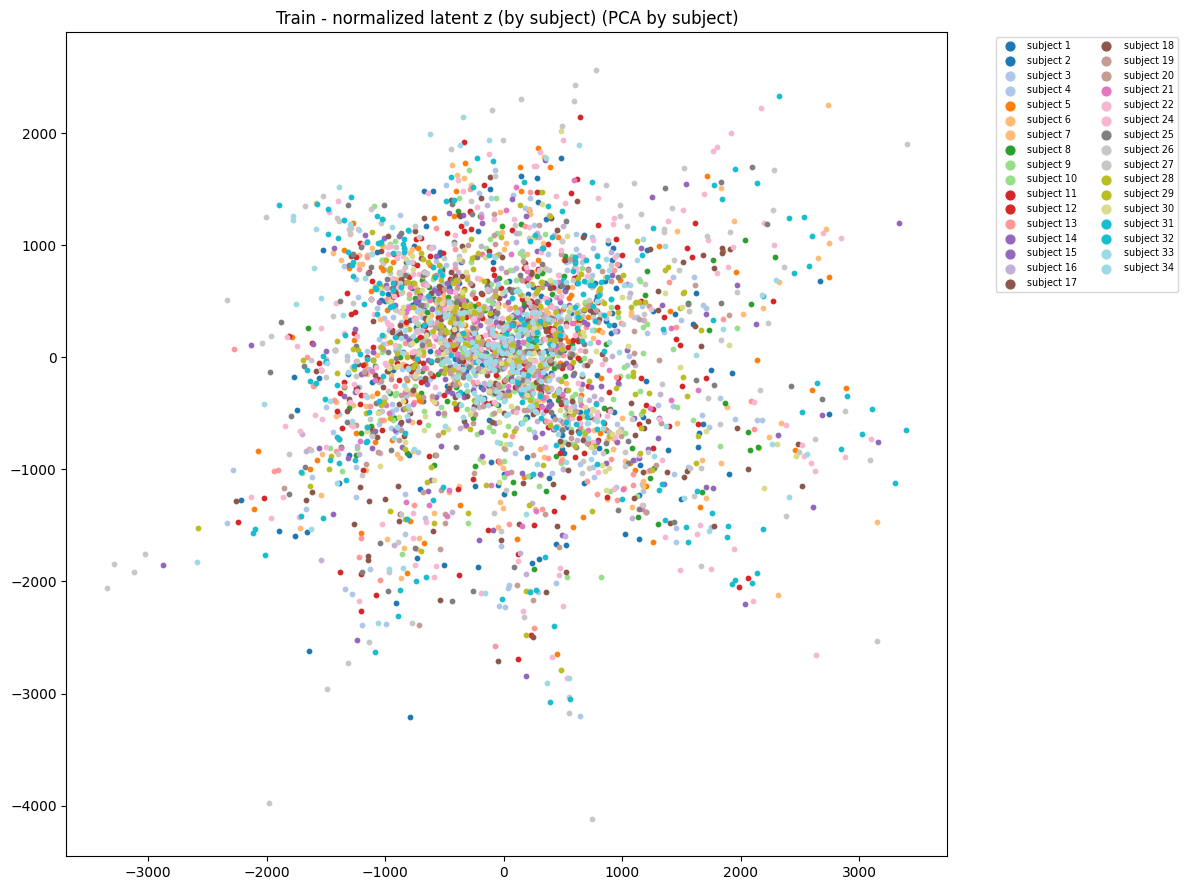

In [45]:
#train by subject
train_iter = iter(train_loader)

x0, y0, sid0 = next(train_iter)
print(">>> First 30 subject_ids from dataloader (sid):")
print(sid0[:30].tolist())

_, z0 = encoder(x0.to(device))
z_list = [z0.detach().cpu()]
x_list = [x0.view(x0.size(0), -1).detach().cpu()]
sid_list = [sid0.cpu()]
first_30_sid = sid0[:30].tolist()

with torch.no_grad():
    for x, _, sid in train_iter:
        x = x.to(device)
        _, z = encoder(x)
        z_list.append(z.detach().cpu())
        x_list.append(x.view(x.size(0), -1).detach().cpu())
        sid_list.append(sid.cpu())

z_all_tensor = torch.cat(z_list, dim=0)
sid_all_tensor = torch.cat(sid_list, dim=0)

z_all_normed = torch.stack([
    (z_all_tensor[i] - z_stats[int(sid_all_tensor[i])][0].squeeze(0).cpu()) /
    z_stats[int(sid_all_tensor[i])][1].squeeze(0).cpu()
    for i in range(z_all_tensor.size(0))
])


z_all = torch.cat(z_list, dim=0).numpy()
x_all = torch.cat(x_list, dim=0).numpy()
sid_all = torch.cat(sid_list, dim=0).numpy()

print(">>> First 30 subject_ids used for t-SNE coloring:")
print(first_30_sid)

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=33, random_state=42).fit(z_all_val)
print("ARI score:", adjusted_rand_score(sid_all_val, kmeans.labels_))

tsne_visualize_latentz_by_subject(x_all, sid_all, title="Train - input x (by subject)")
pca_and_plot(x_all, sid_all, f"Train - input x (by subject)", color_type='subject')
tsne_visualize_latentz_by_subject(z_all, sid_all, title="Train - latent z (by subject)")
pca_and_plot(z_all, sid_all, f"Train - latent z (by subject)", color_type='subject')

tsne_visualize_latentz_by_subject(z_all_normed, sid_all, title="Train - normalized latent z (by subject)")
pca_and_plot(z_all_normed, sid_all, f"Train - normalized latent z (by subject)", color_type='subject')



In [46]:
results = {}

clf = LogisticRegression(max_iter=1000)
clf.fit(z_all, sid_all)
acc = accuracy_score(sid_all, clf.predict(z_all))
results['linear_probe_subject_acc'] = acc

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(z_all, sid_all)
knn_acc = accuracy_score(sid_all, knn.predict(z_all))
results['knn_subject_acc'] = knn_acc

kmeans_subject = KMeans(n_clusters=len(np.unique(sid_all)), random_state=0).fit(z_all)
ari_subject = adjusted_rand_score(sid_all, kmeans_subject.labels_)
nmi_subject = normalized_mutual_info_score(sid_all, kmeans_subject.labels_)
results['ARI_subject'] = ari_subject
results['NMI_subject'] = nmi_subject

sil_subject = silhouette_score(z_all, sid_all)
results['silhouette_subject'] = sil_subject

for k, v in results.items():
    print(f"{k}: {v:.4f}")

linear_probe_subject_acc: 0.2474
knn_subject_acc: 0.3797
ARI_subject: 0.0224
NMI_subject: 0.0873
silhouette_subject: -0.2140


>>> First 30 subject_ids from val dataloader (sid):
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 34, 34, 34, 34]
>>> First 30 subject_ids used for t-SNE coloring (val):
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 34, 34, 34, 34]
>>> First 30 subject_ids from sid_all_val:
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 34, 34, 34, 34]
Running t-SNE on 858 samples...


<ipython-input-44-3c2b76cb6440>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', n_subjects)


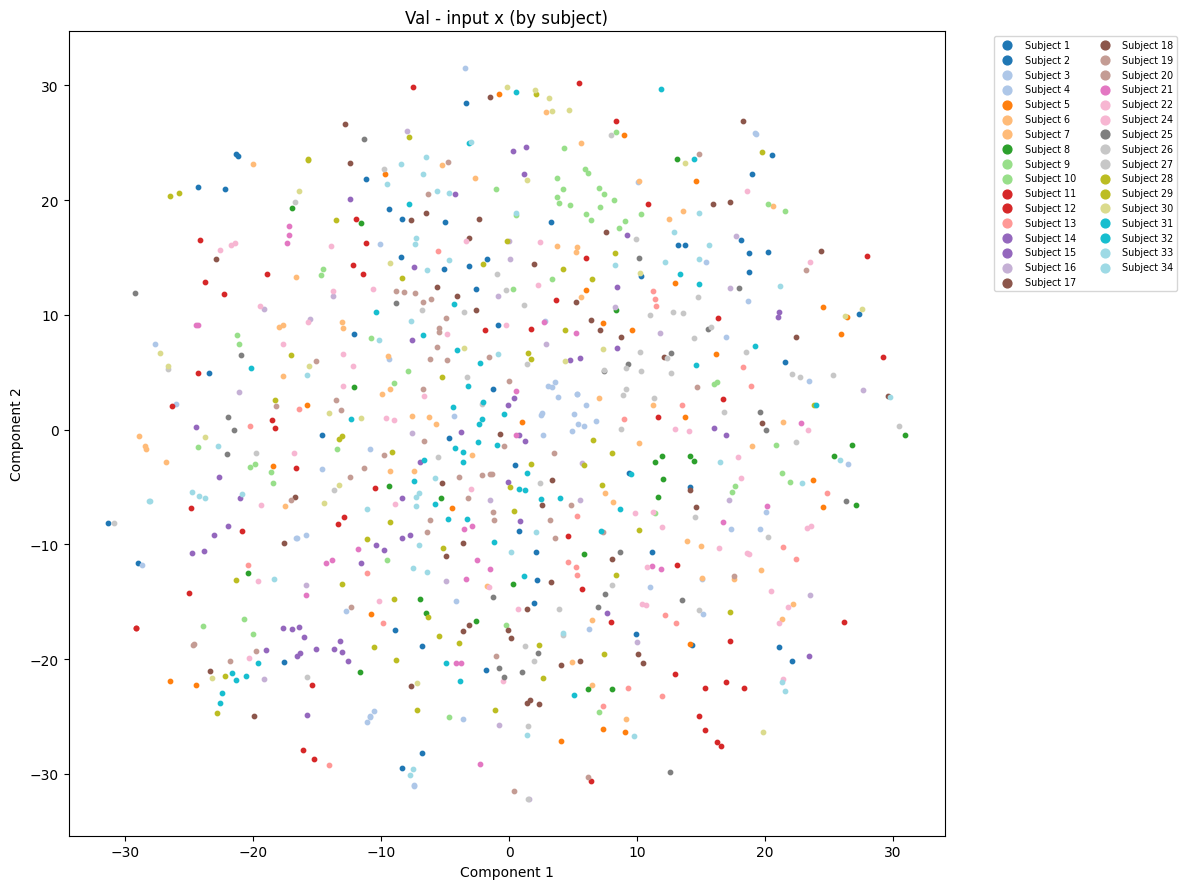

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


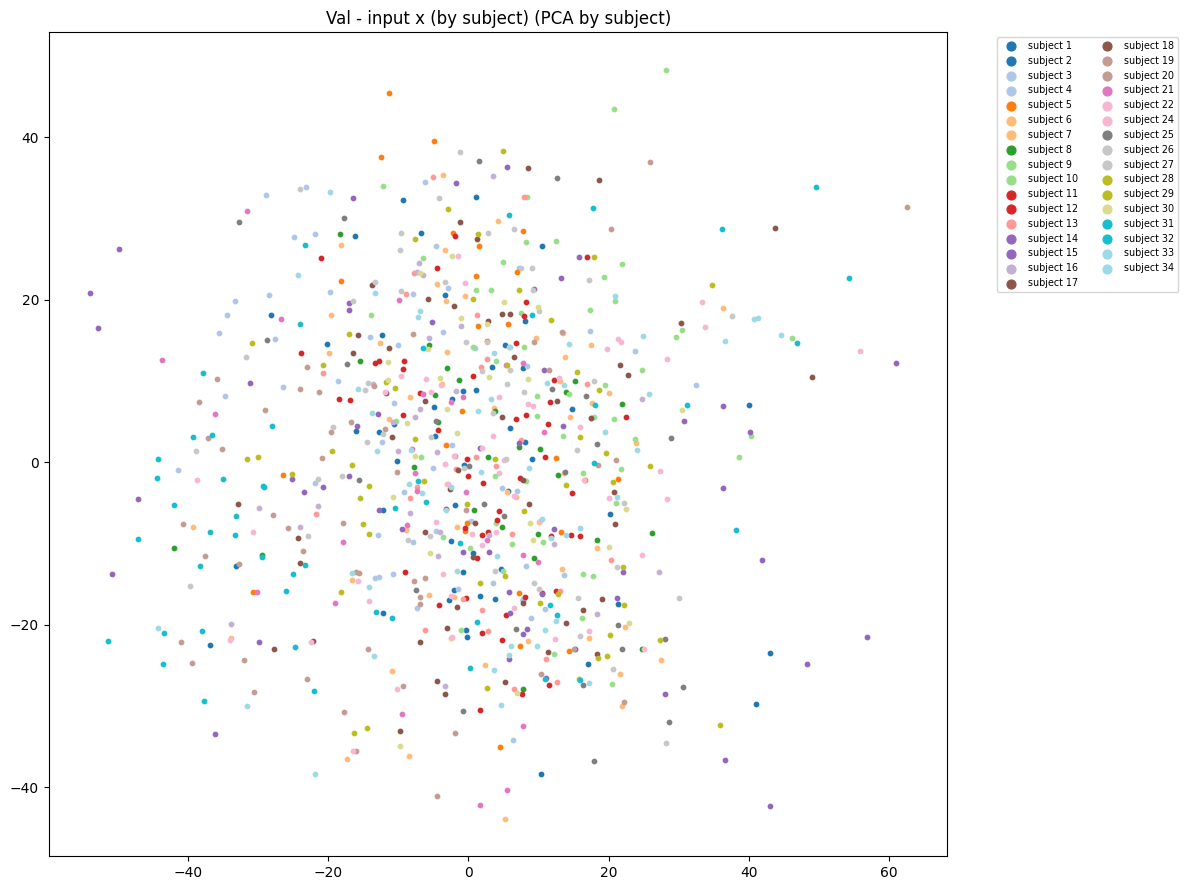

Running t-SNE on 858 samples...


<ipython-input-44-3c2b76cb6440>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', n_subjects)


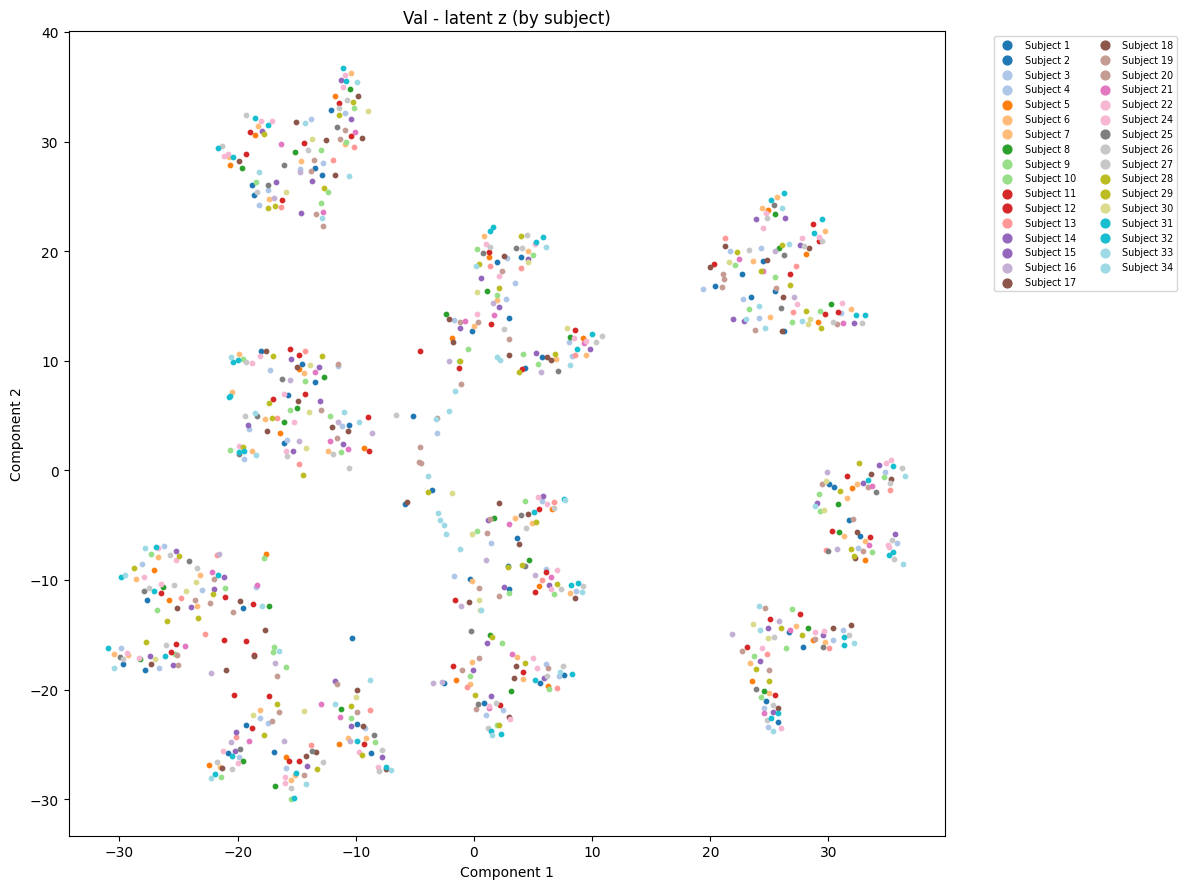

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


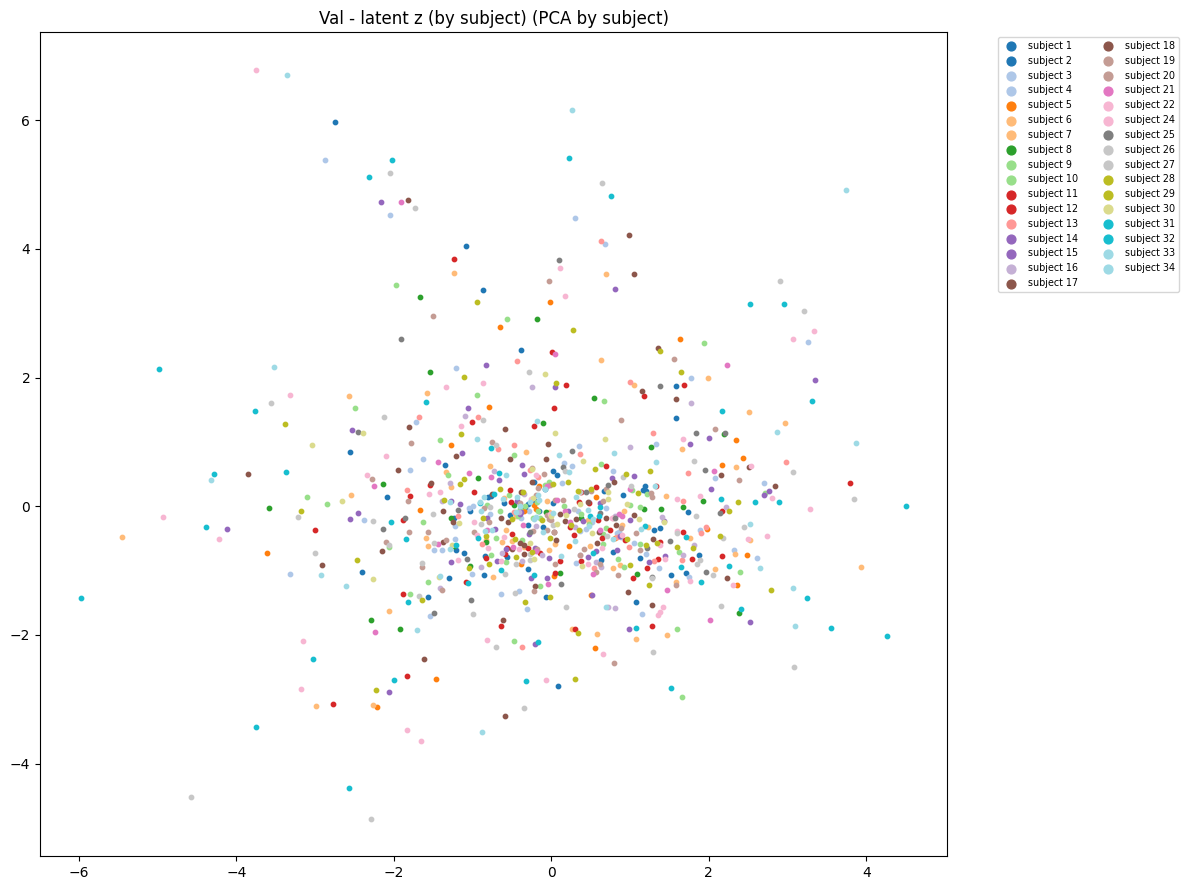

Running t-SNE on 858 samples...


<ipython-input-44-3c2b76cb6440>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', n_subjects)


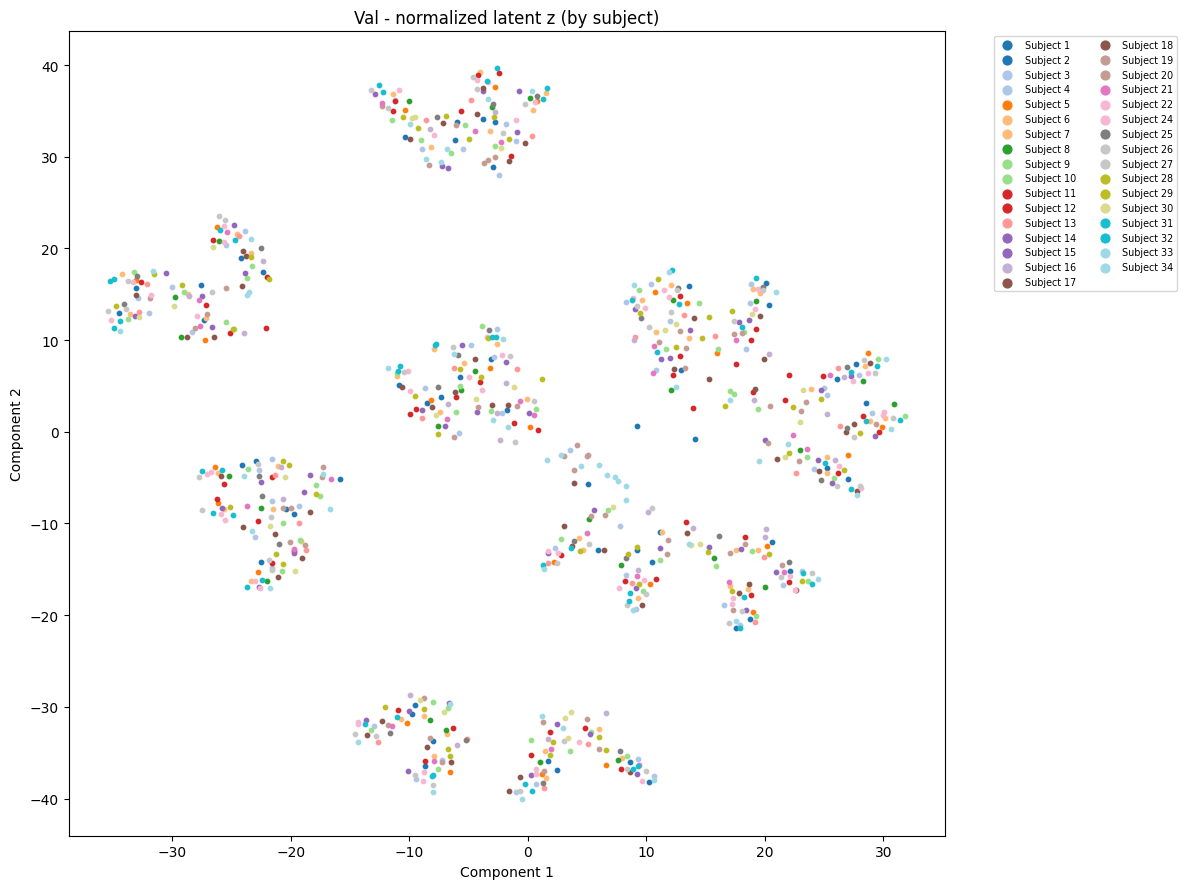

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


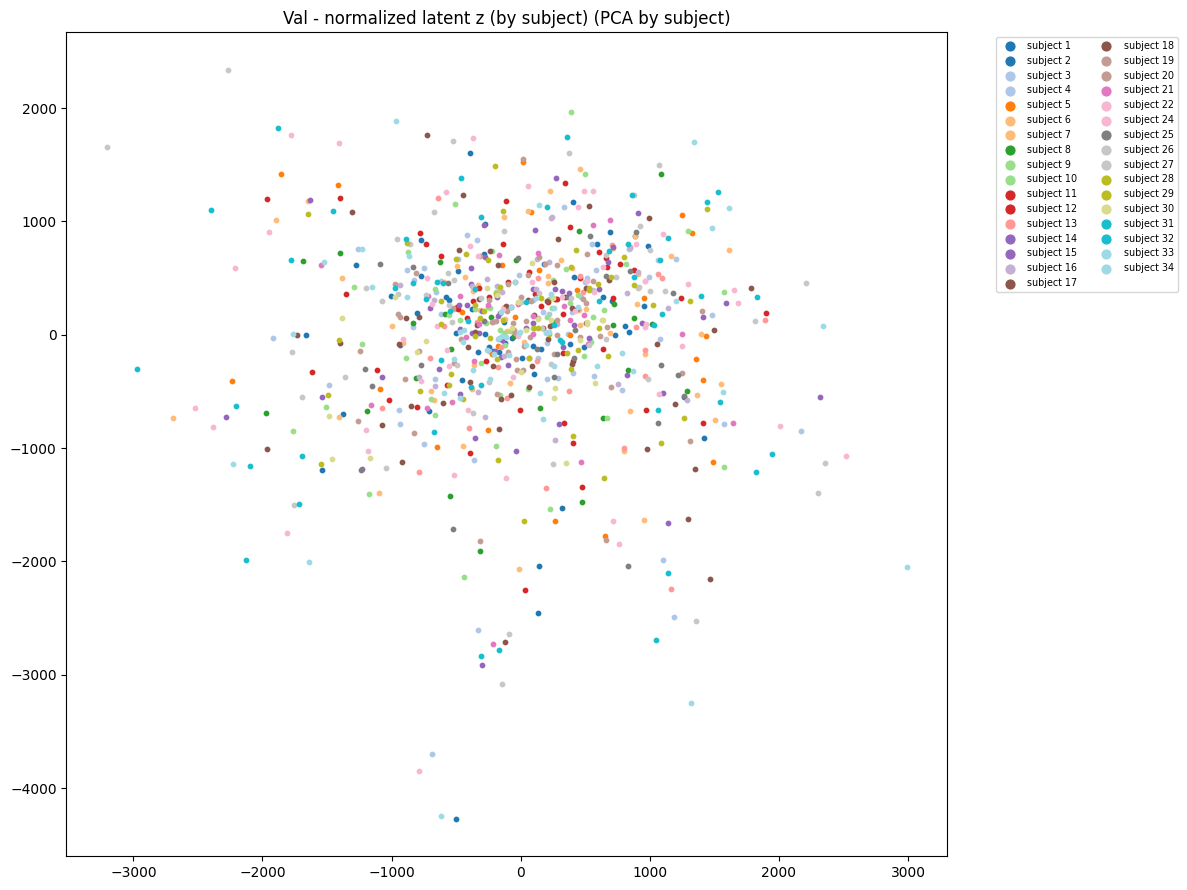

In [47]:
#val by subject (shuffle = F)
val_iter = iter(val_loader)

x0_val, y0_val, sid0_val = next(val_iter)
print(">>> First 30 subject_ids from val dataloader (sid):")
print(sid0_val[:30].tolist())

_, z0_val = encoder(x0_val.to(device))
z_list_val = [z0_val.detach().cpu()]
x_list_val = [x0_val.view(x0_val.size(0), -1).detach().cpu()]
sid_list_val = [sid0_val.cpu()]
first_30_sid_val = sid0_val[:30].tolist()

with torch.no_grad():
    for x, _, sid in val_iter:
        x = x.to(device)
        _, z = encoder(x)
        z_list_val.append(z.detach().cpu())
        x_list_val.append(x.view(x.size(0), -1).detach().cpu())
        sid_list_val.append(sid.cpu())

z_all_val_tensor = torch.cat(z_list_val, dim=0)
sid_all_val_tensor = torch.cat(sid_list_val, dim=0)

z_all_val_normed = torch.stack([
    (z_all_val_tensor[i] - z_stats[int(sid_all_val_tensor[i])][0].squeeze(0).cpu()) /
    z_stats[int(sid_all_val_tensor[i])][1].squeeze(0).cpu()
    for i in range(z_all_val_tensor.size(0))
])

z_all_val = torch.cat(z_list_val, dim=0).numpy()
x_all_val = torch.cat(x_list_val, dim=0).numpy()
sid_all_val = torch.cat(sid_list_val, dim=0).numpy()

print(">>> First 30 subject_ids used for t-SNE coloring (val):")
print(first_30_sid_val)
print(">>> First 30 subject_ids from sid_all_val:")
print(sid_all_val[:30].tolist())

tsne_visualize_latentz_by_subject(x_all_val, sid_all_val, title="Val - input x (by subject)")
pca_and_plot(x_all_val, sid_all_val, f"Val - input x (by subject)", color_type='subject')
tsne_visualize_latentz_by_subject(z_all_val, sid_all_val, title="Val - latent z (by subject)")
pca_and_plot(z_all_val, sid_all_val, f"Val - latent z (by subject)", color_type='subject')

tsne_visualize_latentz_by_subject(z_all_val_normed, sid_all_val, title="Val - normalized latent z (by subject)")
pca_and_plot(z_all_val_normed, sid_all_val, f"Val - normalized latent z (by subject)", color_type='subject')



In [48]:
results = {}

clf = LogisticRegression(max_iter=1000)
clf.fit(z_all_val, sid_all_val)
acc = accuracy_score(sid_all_val, clf.predict(z_all_val))
results['linear_probe_subject_acc'] = acc

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(z_all_val, sid_all_val)
knn_acc = accuracy_score(sid_all_val, knn.predict(z_all_val))
results['knn_subject_acc'] = knn_acc

kmeans_subject = KMeans(n_clusters=len(np.unique(sid_all_val)), random_state=0).fit(z_all_val)
ari_subject = adjusted_rand_score(sid_all_val, kmeans_subject.labels_)
nmi_subject = normalized_mutual_info_score(sid_all_val, kmeans_subject.labels_)
results['ARI_subject'] = ari_subject
results['NMI_subject'] = nmi_subject

sil_subject = silhouette_score(z_all_val, sid_all_val)
results['silhouette_subject'] = sil_subject

for k, v in results.items():
    print(f"{k}: {v:.4f}")

linear_probe_subject_acc: 0.2401
knn_subject_acc: 0.2214
ARI_subject: -0.0021
NMI_subject: 0.1562
silhouette_subject: -0.2293


>>> First 30 subject_ids from val dataloader (sid):
[24, 14, 24, 21, 7, 30, 12, 27, 11, 27, 34, 4, 34, 32, 25, 32, 33, 10, 13, 3, 27, 9, 11, 16, 3, 14, 20, 33, 9, 8]
>>> First 30 subject_ids used for t-SNE coloring (val):
[24, 14, 24, 21, 7, 30, 12, 27, 11, 27, 34, 4, 34, 32, 25, 32, 33, 10, 13, 3, 27, 9, 11, 16, 3, 14, 20, 33, 9, 8]
>>> First 30 subject_ids from sid_all_val:
[24, 14, 24, 21, 7, 30, 12, 27, 11, 27, 34, 4, 34, 32, 25, 32, 33, 10, 13, 3, 27, 9, 11, 16, 3, 14, 20, 33, 9, 8]
Running t-SNE on 858 samples...


<ipython-input-44-3c2b76cb6440>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', n_subjects)


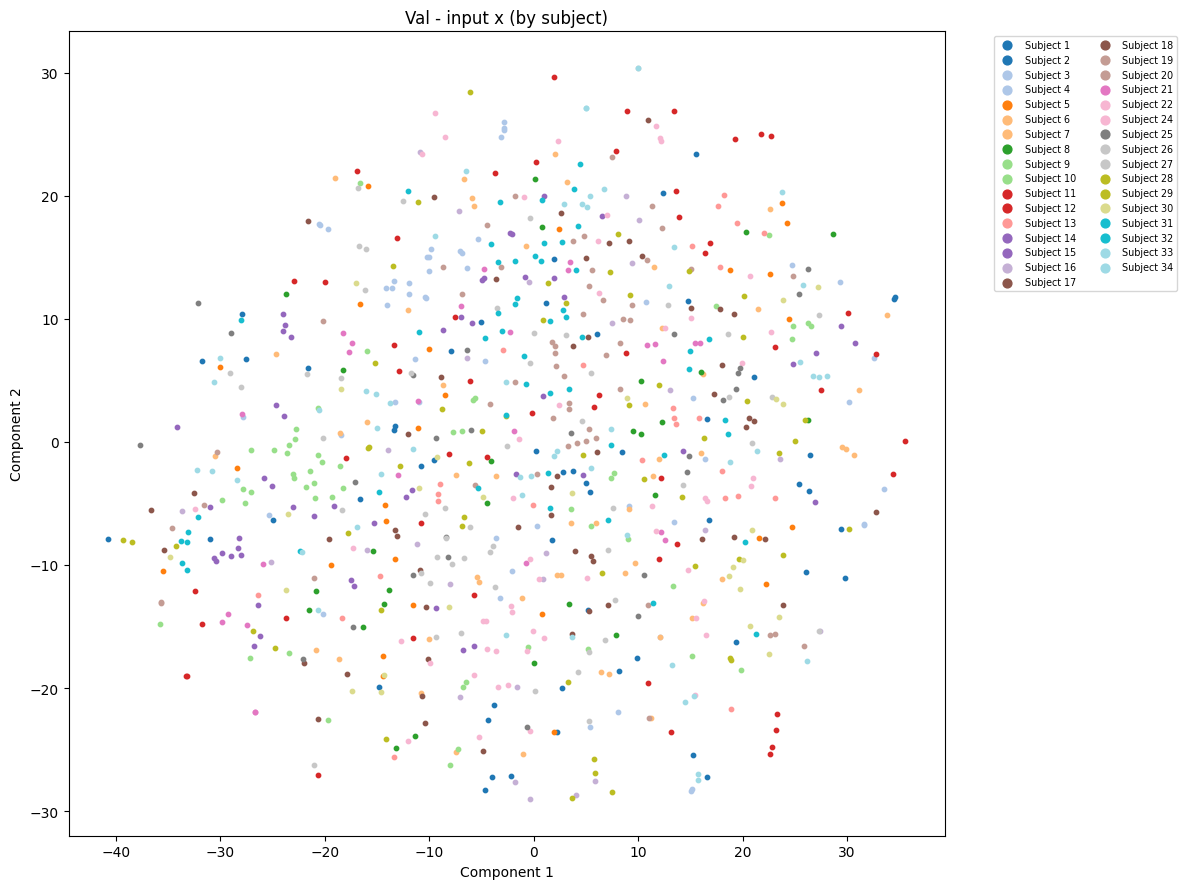

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


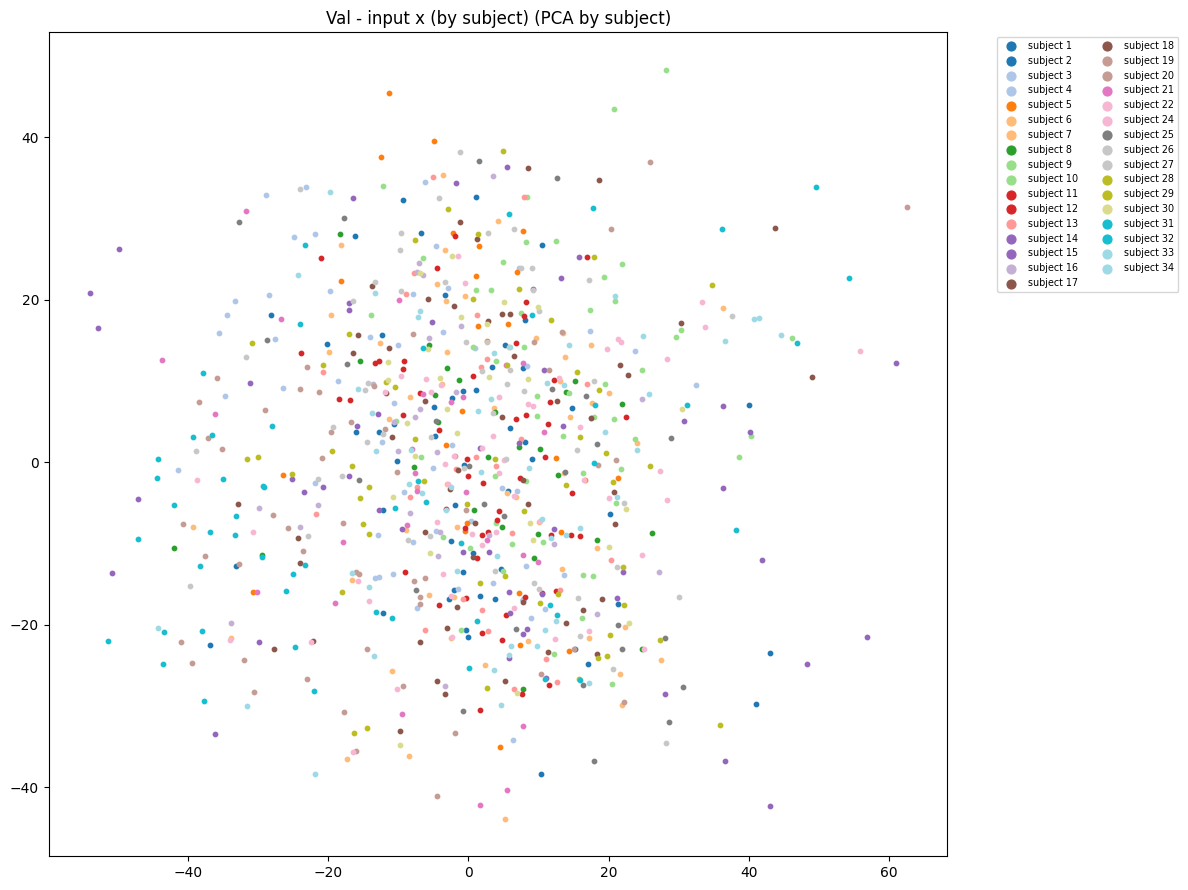

Running t-SNE on 858 samples...


<ipython-input-44-3c2b76cb6440>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', n_subjects)


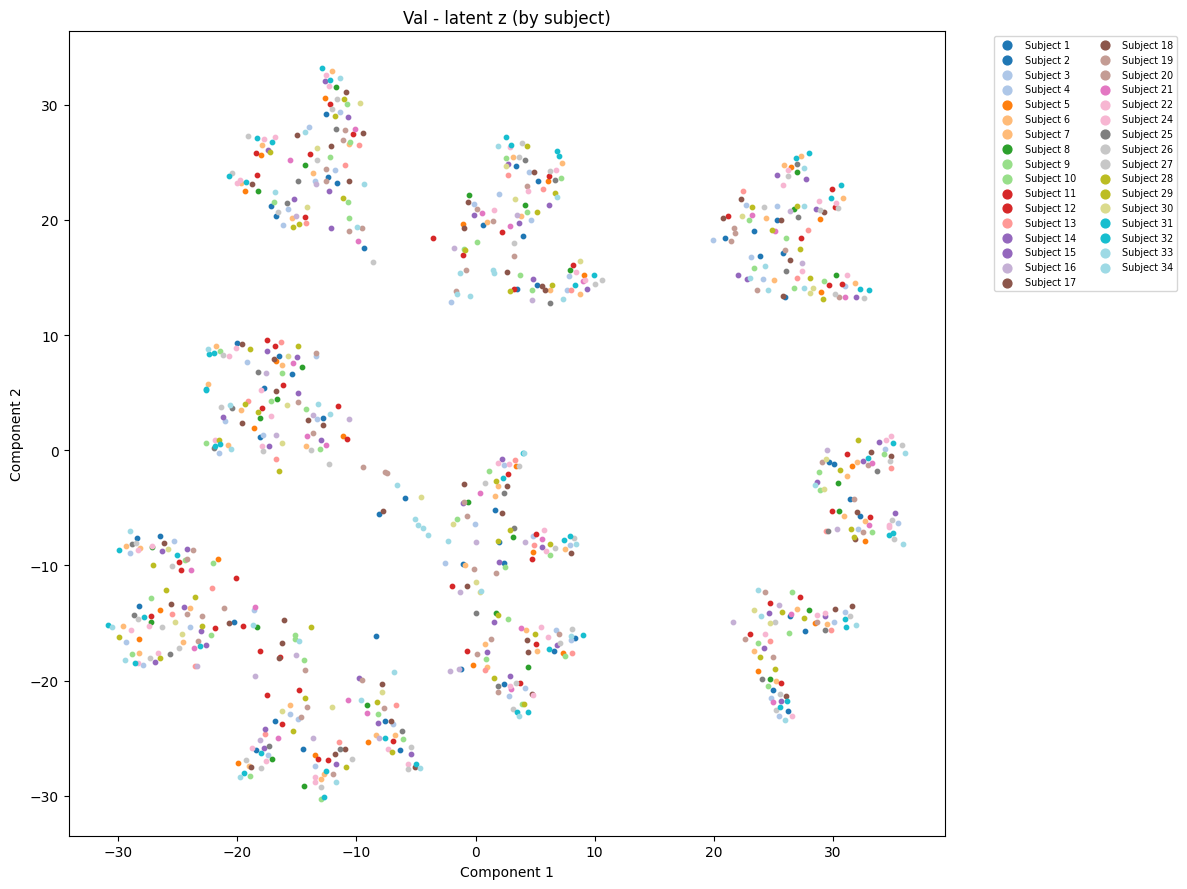

<ipython-input-37-bf21395d0ef5>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(classes))


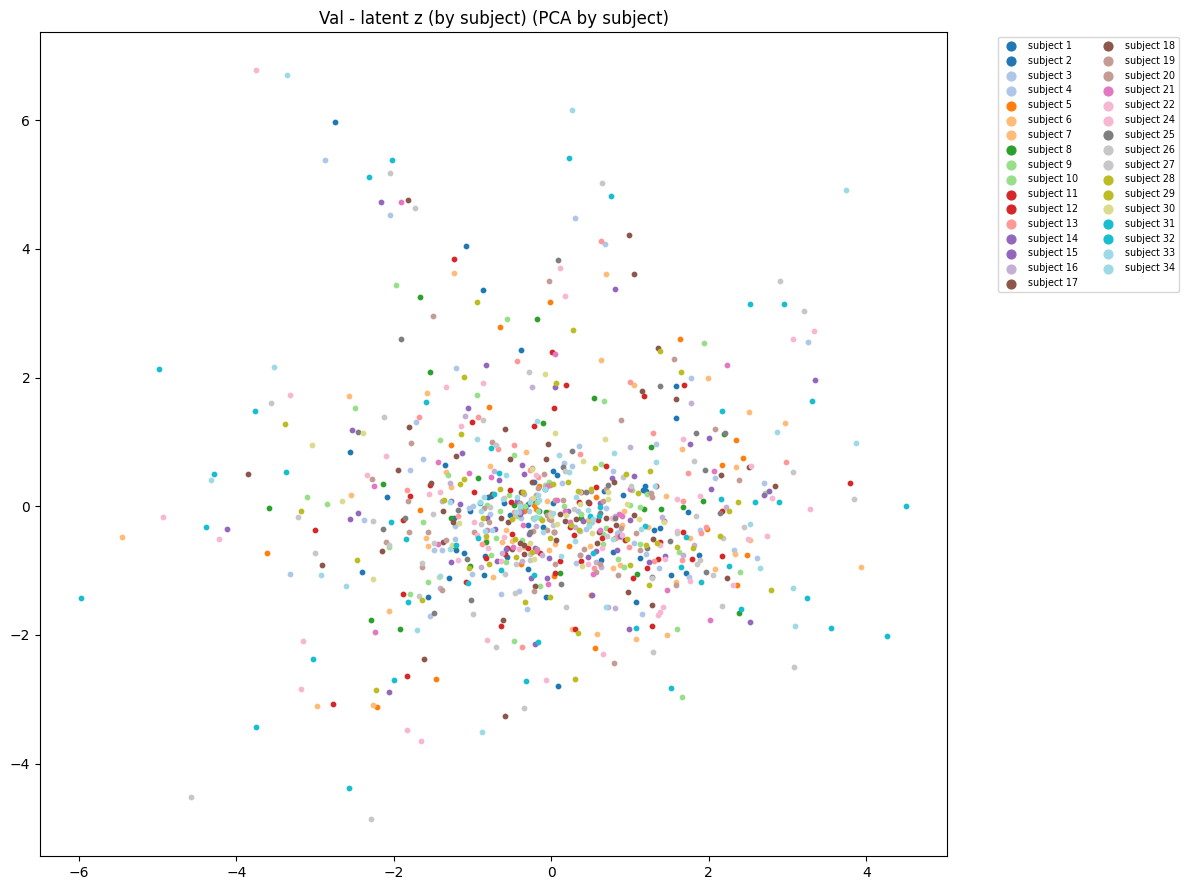

In [49]:
#val2 by subject (shuffle = T)
val_iter = iter(val2_loader)

x0_val, y0_val, sid0_val = next(val_iter)
print(">>> First 30 subject_ids from val dataloader (sid):")
print(sid0_val[:30].tolist())

_, z0_val = encoder(x0_val.to(device))
z_list_val = [z0_val.detach().cpu()]
x_list_val = [x0_val.view(x0_val.size(0), -1).detach().cpu()]
sid_list_val = [sid0_val.cpu()]
first_30_sid_val = sid0_val[:30].tolist()

with torch.no_grad():
    for x, _, sid in val_iter:
        x = x.to(device)
        _, z = encoder(x)
        z_list_val.append(z.detach().cpu())
        x_list_val.append(x.view(x.size(0), -1).detach().cpu())
        sid_list_val.append(sid.cpu())

z_all_val = torch.cat(z_list_val, dim=0).numpy()
x_all_val = torch.cat(x_list_val, dim=0).numpy()
sid_all_val = torch.cat(sid_list_val, dim=0).numpy()

print(">>> First 30 subject_ids used for t-SNE coloring (val):")
print(first_30_sid_val)
print(">>> First 30 subject_ids from sid_all_val:")
print(sid_all_val[:30].tolist())

tsne_visualize_latentz_by_subject(x_all_val, sid_all_val, title="Val - input x (by subject)")
pca_and_plot(x_all_val, sid_all_val, f"Val - input x (by subject)", color_type='subject')
tsne_visualize_latentz_by_subject(z_all_val, sid_all_val, title="Val - latent z (by subject)")
pca_and_plot(z_all_val, sid_all_val, f"Val - latent z (by subject)", color_type='subject')


In [50]:
results = {}

clf = LogisticRegression(max_iter=1000)
clf.fit(z_all_val, sid_all_val)
acc = accuracy_score(sid_all_val, clf.predict(z_all_val))
results['linear_probe_subject_acc'] = acc

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(z_all_val, sid_all_val)
knn_acc = accuracy_score(sid_all_val, knn.predict(z_all_val))
results['knn_subject_acc'] = knn_acc

kmeans_subject = KMeans(n_clusters=len(np.unique(sid_all_val)), random_state=0).fit(z_all_val)
ari_subject = adjusted_rand_score(sid_all_val, kmeans_subject.labels_)
nmi_subject = normalized_mutual_info_score(sid_all_val, kmeans_subject.labels_)
results['ARI_subject'] = ari_subject
results['NMI_subject'] = nmi_subject

sil_subject = silhouette_score(z_all_val, sid_all_val)
results['silhouette_subject'] = sil_subject

for k, v in results.items():
    print(f"{k}: {v:.4f}")

linear_probe_subject_acc: 0.2401
knn_subject_acc: 0.2214
ARI_subject: 0.0005
NMI_subject: 0.1500
silhouette_subject: -0.2293


| Metric                  | Train-Label | Val-Label (shuffle=F) | Val2-Label (shuffle=T) | Train-Subject | Val-Subject (shuffle=F) | Val2-Subject (shuffle=T) | Reference Meaning                                                | Good if ↑ |
|-------------------------|-------------|------------------------|-------------------------|----------------|--------------------------|---------------------------|-------------------------------------------------------------------|------------|
| Linear Probe Accuracy   | 0.5402      | 0.5979                 | 0.6900                  | 0.2832         | 0.8042                   | 0.4417                    | Accuracy of logistic regression on latent `z`                    | ↑          |
| KNN Accuracy (k=5)      | 0.4983      | 0.3508                 | 0.4895                  | 0.2584         | 0.7517                   | 0.2366                    | Accuracy of 5-NN classifier on latent `z`                        | ↑          |
| ARI                     | 0.0076      | 0.0143                 | 0.0141                  | -0.0000        | 0.0142                   | -0.0006                   | Adjusted Rand Index between true labels and cluster assignments | ↑          |
| NMI                     | 0.1251      | 0.1792                 | 0.2155                  | 0.0544         | 0.3616                   | 0.1600                    | Normalized Mutual Information between true and cluster labels    | ↑          |
| Silhouette Score        | -0.1957     | -0.2082                | -0.1973                 | -0.1286        | -0.0161                  | -0.1486                   | How well-separated the embeddings are by ground truth labels     | ↑          |


### original wrong return label method (static)

In [51]:
#used only for tsne plot
class EEGDataset(Dataset):
    "Characterizes a dataset for PyTorch"

    def __init__(self, X, Y, transform=None):
        "Initialization"
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        "Denotes the total number of samples"
        return len(self.X)

    def __getitem__(self, index):
        "Generates one sample of data"
        # Load data and get label
        x = self.X[index]
        y = self.Y[index]
        if self.transform:
            x = self.transform(x)
        return x.squeeze(), y

def load_split_dataset(root_dir, num_seen, seed=43):
    random.seed(seed)

    all_subjects = list(range(1, 36))
    seen_subjects = random.sample(all_subjects, num_seen)#25 seen
    unseen_subjects = [sid for sid in all_subjects if sid not in seen_subjects]#10 unseen

    split_cfg = {
        "train":  [(sid, [0, 1, 2, 3]) for sid in seen_subjects],
        "val":    [(sid, [4]) for sid in seen_subjects],
        "test1":  [(sid, [5]) for sid in seen_subjects],
        "test2":  [(sid, [0, 1, 2, 3, 4, 5]) for sid in unseen_subjects]
    }

    print(f"[Split] Seen subjects (train/val/test1): {seen_subjects}")
    print(f"[Split] Unseen subjects (test2): {unseen_subjects}")

    loaders = {}
    subject_id_dict = {}  # 临时存 subject_id list

    for split, sid_sess in split_cfg.items():
        X_all, Y_all = [], []
        subject_ids = []
        for sid, sess in sid_sess:
            X, Y = load_data_by_session(root_dir, sid, sess)
            X_all.append(X)
            Y_all.append(Y)
            subject_ids.extend([sid] * len(Y))
        X_all = torch.cat(X_all, dim=0)
        Y_all = torch.cat(Y_all, dim=0)
        dataset = EEGDataset(X_all, Y_all)
        loaders[split] = DataLoader(dataset, batch_size=32, shuffle=(split == "train"))
        subject_id_dict[split] = torch.tensor(subject_ids, dtype=torch.long)

    # return subject_id list for t-SNE
    for split in ["train", "val"]:
        if split in subject_id_dict:
            loaders[f"{split}_subjects"] = subject_id_dict[split]
    return loaders


In [52]:
subject_chars_dir = '/content/drive/MyDrive/project/dataset/ssvep/chars' # Where to store all character data
subject_ids = list(range(1, 36)) #35 samples + 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
batch_size2 = 260
seed = 44
shuffle = True

# load all subjects' data
loaders = load_split_dataset(subject_chars_dir, num_seen=33, seed=seed)
train_loader = loaders["train"]
val_loader = loaders["val"]
test1_loader = loaders["test1"]
test2_loader = loaders["test2"]


[Split] Seen subjects (train/val/test1): [27, 34, 8, 12, 13, 33, 10, 1, 30, 4, 19, 28, 26, 6, 17, 29, 31, 25, 11, 32, 2, 22, 5, 20, 3, 15, 9, 16, 18, 24, 21, 7, 14]
[Split] Unseen subjects (test2): [23, 35]


In [53]:
loaders["train_subjects"]

print(">>> First 10 subject_ids from static subject_ids:")
print(loaders["train_subjects"][:30].tolist())

print(">>> First 10 subject_ids corresponding to z from dataloader (mismatched):")
with torch.no_grad():
    for i, (x, y) in enumerate(loaders["train"]):
        print(f"x.shape: {x.shape}")
        break


>>> First 10 subject_ids from static subject_ids:
[27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27]
>>> First 10 subject_ids corresponding to z from dataloader (mismatched):
x.shape: torch.Size([32, 64, 250])


In [54]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def visualize_tsne(encoder, dataloader, device):
    encoder.eval()
    features = []
    labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            _, z = encoder(x)
            features.append(z.cpu())
            labels.append(y.cpu())

    X = torch.cat(features, dim=0).numpy()
    y = torch.cat(labels, dim=0).numpy()

    print("Running t-SNE...")
    X_emb = TSNE(n_components=2, perplexity=30, learning_rate=200).fit_transform(X)

    n_classes = len(np.unique(y))
    cmap = cm.get_cmap('tab20', n_classes)

    plt.figure(figsize=(12, 9))
    for i in range(n_classes):
        idx = (y == i)
        color = cmap(i / n_classes)
        plt.scatter(X_emb[idx, 0], X_emb[idx, 1], label=f"Label {i}", color=color, s=10)

    plt.legend(markerscale=2, fontsize="small", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("t-SNE visualization of latent z (colored by label)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    plt.show()

Running t-SNE...


<ipython-input-54-f721b021d189>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_classes)


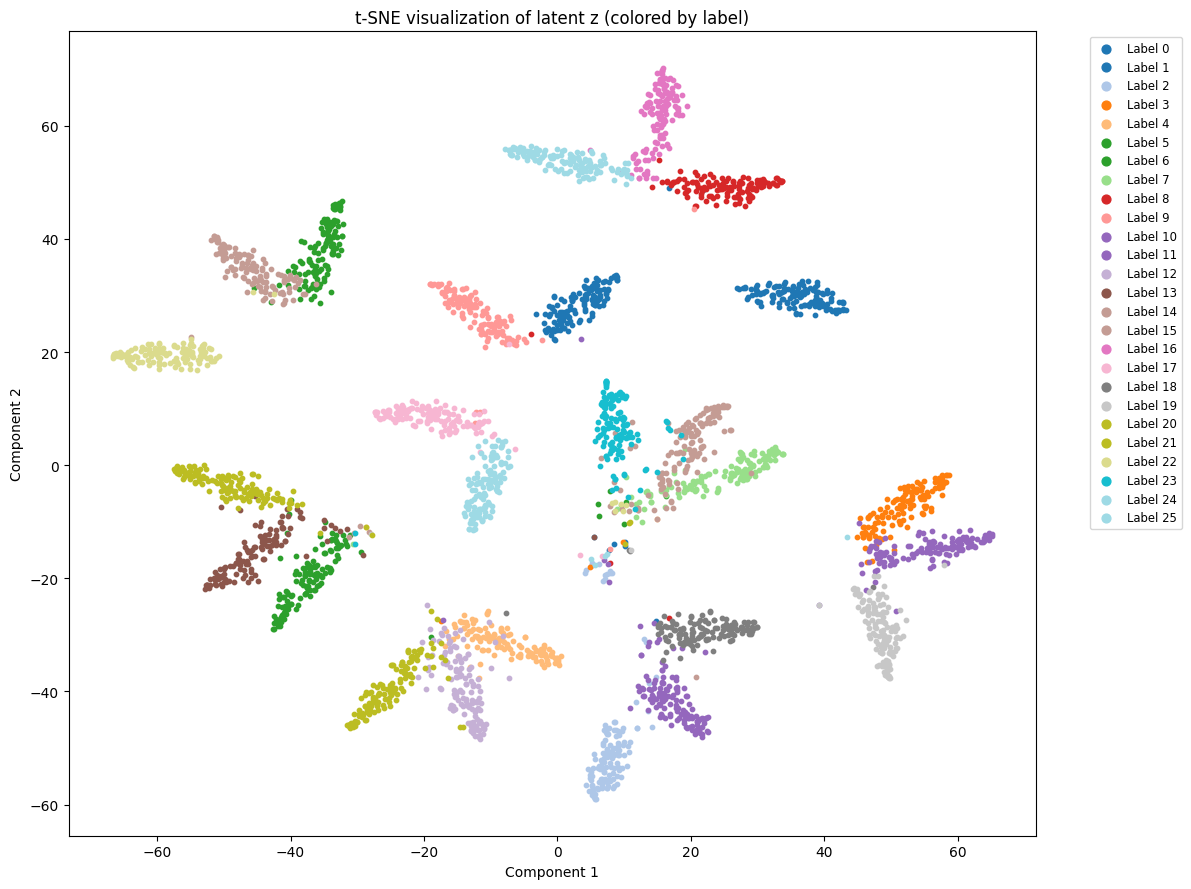

Running t-SNE...


<ipython-input-54-f721b021d189>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', n_classes)


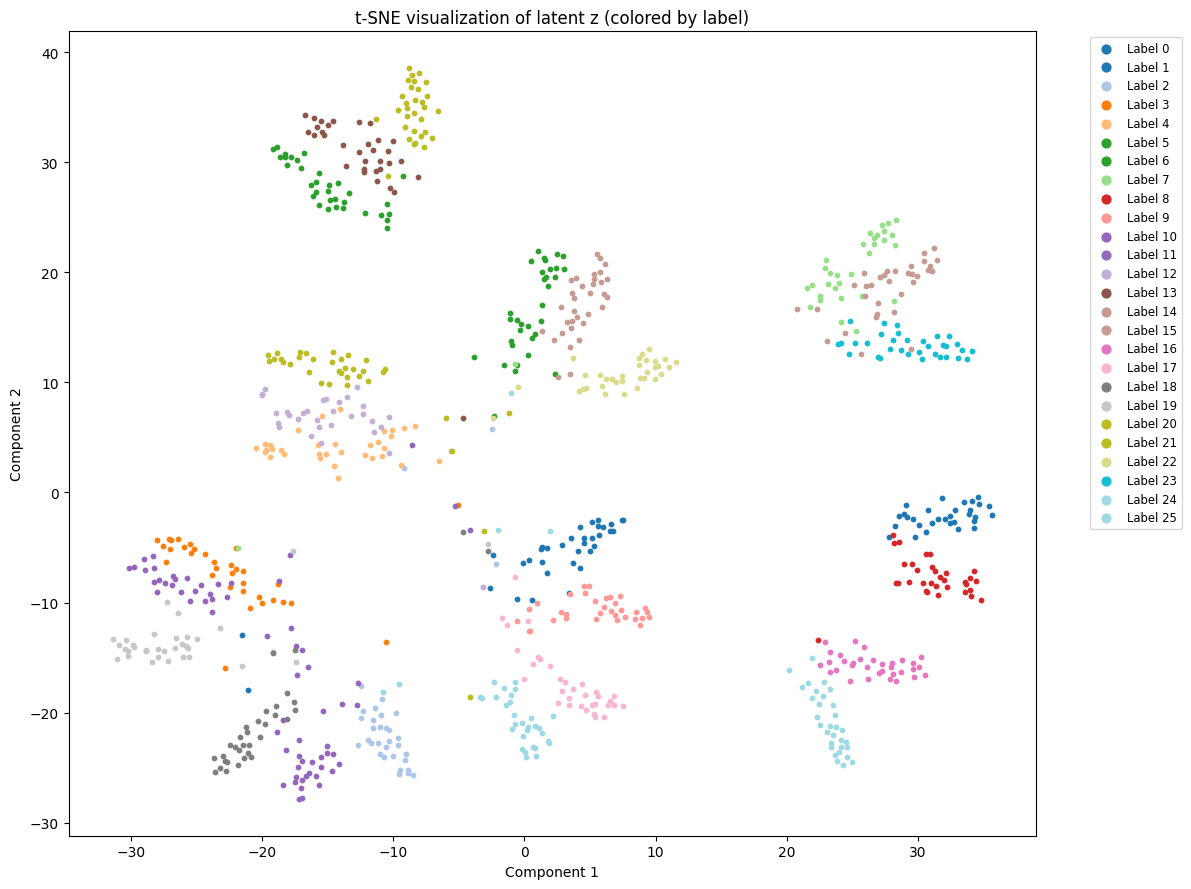

In [55]:
visualize_tsne(diffe.encoder, train_loader, device)
visualize_tsne(diffe.encoder, val_loader, device)

In [56]:
import matplotlib.cm as cm

def visualize_tsne_subject_temp(encoder, dataloader, subject_ids, device, title="t-SNE"):
    encoder.eval()
    features = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            _, z = encoder(x)
            features.append(z.cpu())

    X = torch.cat(features, dim=0).numpy()
    subjects = subject_ids.numpy()

    print("Running t-SNE...")
    X_emb = TSNE(n_components=2, perplexity=30, learning_rate=200).fit_transform(X)

    unique_subjects = sorted(np.unique(subjects))
    n_subjects = len(unique_subjects)
    colormap = cm.get_cmap('tab20', n_subjects)

    plt.figure(figsize=(12, 9))
    for i, sid in enumerate(unique_subjects):
        idx = (subjects == sid)
        color = colormap(i / n_subjects)
        plt.scatter(X_emb[idx, 0], X_emb[idx, 1], label=f"Subject {sid}", color=color, s=8)

    plt.legend(markerscale=2, fontsize="x-small", bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    plt.title(f"{title} (colored by subject)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    plt.show()


Running t-SNE...


<ipython-input-56-31efca889ba5>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', n_subjects)


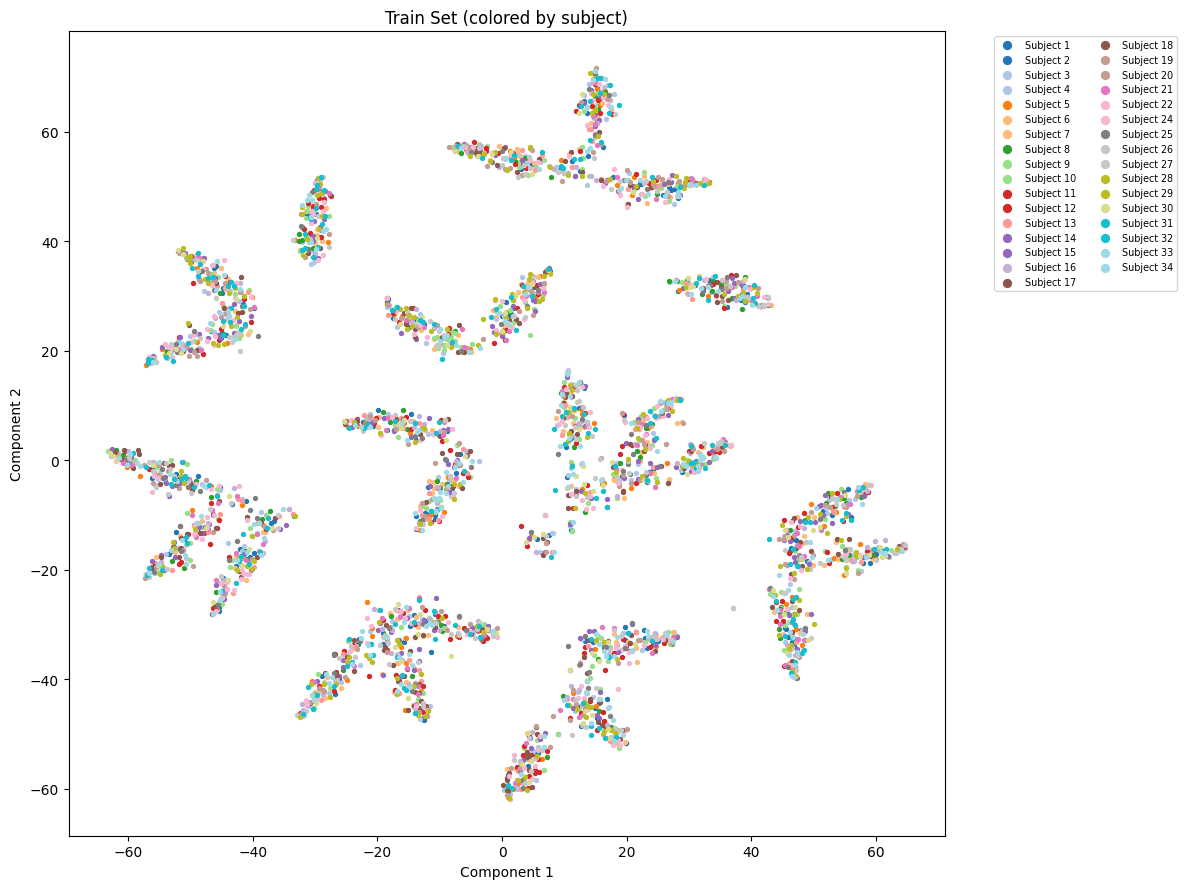

Running t-SNE...


<ipython-input-56-31efca889ba5>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', n_subjects)


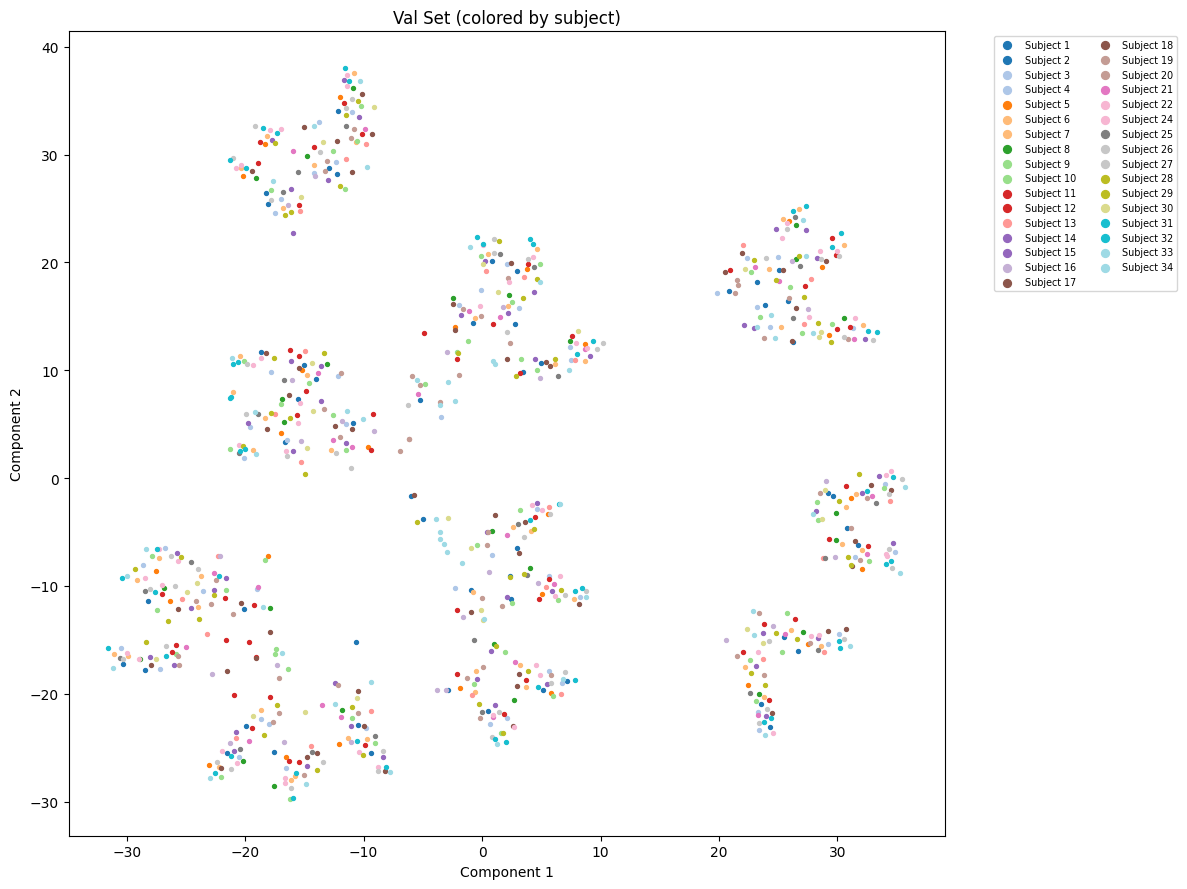

In [57]:
visualize_tsne_subject_temp(encoder, loaders["train"], loaders["train_subjects"], device, title="Train Set")
visualize_tsne_subject_temp(encoder, loaders["val"], loaders["val_subjects"], device, title="Val Set")